#  Measuring the chromosome size

One of the issues when doing experiments in genetic studies is the correct numbering of the chromosomes. Chromosomes are traditionally numbered from largest to smallest, considering their number of nucleotide base pairs, but that lengh is often variable in each individual and even among cells of a single individual. Techniques to extract DNA material from cells allow to measure the length of each individual chromosome, but assigning the number for each chromosome is a much harder task that is not easily achievable in most experimental settings. 

For instance, mice have 19 chromosomes in their cells. Using an immunofluorescence protocol, we can determine the lengh of each chromosome, in microns. But with only that information we cannot do the number assignment (from 1 to 19) with any degree of certainty without further analysis. A degree of overlap between chromosome lenghts is expected, so it is not as simple as ranking them by length to do the assignment. A more sensitive approach would be to group chromosomes with similar length, so they can be assigned soly based on their length.

As a reference, we have the dataset from the [Froenicke et al. 2002](https://www.sciencedirect.com/science/article/pii/S000292970760857X), that in addition to measuring the chromosome length, they also identified their correct chromosome number using the [FIRC technique](https://en.wikipedia.org/wiki/Fluorescein_isothiocyanate). Using this dataset, we can try to determine the correct number of groups based on chromosome length similarity, so we can assign our own experimental data to these groups.

This project notebook will depend on R and the ggplot2 visualization library.

In [1]:
# First let's make sure R is correctly installed and up to date
R.version

               _                           
platform       x86_64-conda_cos6-linux-gnu 
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

## Data acquisition
Load the data from Froenicke et al. 2002 (*mouse data Froenicke et al 2002.csv*) into a dataframe (`data`):

In [4]:
data <- read.csv("mouse data Froenicke et al 2002.csv", sep = ";")
head(data)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2
1   NA 0.60       NA    
2   NA 0.49       NA    
3   NA 0.65       NA    
4 0.96 0.33     0.96    
5   NA 0.42       NA    
6   NA 0.38       NA

Data description:
- mouse: mouse specimen ID (1 to 3).
- Set.ID: cell ID (string).
- FITC.Rank: Chromosome rank number (1 to 19), based on the FITC technique. This is the "true" chromosome number that we will be used as a reference.
- Len: Length of the chromosome, in microns.
- Total.Len: Total length of the cell genome, in microns.
- Rel.len: Len/Total.Len.
- Lgth.Rank: Rel.len, ranked (1 to 19).

We don't really need all columns. The features mentioned above (columns 1 to 7) are enough for our purpose, so we will trim the dataframe:

In [7]:
data <- data[, 1:7]
head(data)
summary(data)
nrow(data)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18

     mouse                       Set.ID       FITC.Rank    Lgth.Rank 
 Min.   :1.000   m1-3 s4 nu         :  19   Min.   : 1   Min.   : 1  
 1st Qu.:2.000   M1-5 s25 200% im nu:  19   1st Qu.: 5   1st Qu.: 5  
 Median :2.000   M1-5 s3            :  19   Median :10   Median :10  
 Mean   :2.042   M1-5 s32 I im      :  19   Mean   :10   Mean   :10  
 3rd Qu.:2.250   m1-6 s11 I big im  :  19   3rd Qu.:15   3rd Qu.:15  
 Max.   :3.000   m1-6 s13 I im      :  19   Max.   :19   Max.   :19  
                 (Other)            :1254                            
    Rel.len          Total.Len          Len        
 Min.   :0.02067   Min.   :103.6   Min.   : 2.550  
 1st Qu.:0.04277   1st Qu.:155.8   1st Qu.: 6.930  
 Median :0.05247   Median :175.9   Median : 8.845  
 Mean   :0.05263   Mean   :173.8   Mean   : 9.150  
 3rd Qu.:0.06160   3rd Qu.:197.9   3rd Qu.:11.130  
 Max.   :0.10244   Max.   :255.8   Max.   :20.440  
                                                   

[1] 1368

The first step will be checking if the Length rank (`lgth.Rank`) matches the chromosome number (`FITC.Rank`).
A new column (`Rank.Match`) will be added to the dataframe to store whether the rank matches or not (boolean variable):

In [8]:
data$Rank.Match <- NA
head(data)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   Rank.Match
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 NA        
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 NA        
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 NA        
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 NA        
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 NA        
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 NA

Set the predefined clusters:

Chromosome size rank

1-2

3-5

6-11

12-16

17-19

(In a new dataframe: df_ranks)

In [5]:
df_ranks <- data.frame("rank_interval" = c(1, 2, 3, 4, 5),
                 "chr_start" = c(1, 3, 6, 12, 17),
                 "chr_end" = c(2, 5, 11, 16, 19))


# df_ranks[nrow(df_ranks) + 1,] <- c(6, 20, 30) # adds additional row with values
df_ranks

rank_interval chr_start chr_end
1 1              1         2     
2 2              3         5     
3 3              6        11     
4 4             12        16     
5 5             17        19

In [6]:
# Alternative way to create a table for the ranks using a list of lists
rank1 <- list(1, 2)
rank2 <- list(3, 5)
rank3 <- list(6, 11)
rank4 <- list(12, 16)
rank5 <- list(17, 19)

ranks_all_together_now <- list(rank1, rank2, rank3, rank4, rank5)


print(ranks_all_together_now[[5]][[2]]) # Row 5, column 2

[1] 19


In [7]:
# testing
typeof(data) # check type of variable
print(is.data.frame(data)) # check if variable is indeed a dataframe
print(ncol(data)) # number of columns in the dataframe
print(nrow(data)) # number of rows in the dataframe
head(data["Set.ID"]) # show a column of the dataframe

[1] "list"

[1] TRUE
[1] 9
[1] 1368


Set.ID    
1 m1-3 s4 nu
2 m1-3 s4 nu
3 m1-3 s4 nu
4 m1-3 s4 nu
5 m1-3 s4 nu
6 m1-3 s4 nu

In [8]:
results <- vector()
for(i in 1:nrow(data)) {       # for-loop over rows
    #print(data[[i,"FITC.Rank"]])
    if (data[[i,"FITC.Rank"]] == data[[i,"Lgth.Rank"]]){
        #print("Son lo mateix.")
        results <- c(results, TRUE)
    }
    else {
        #print("No coincideixen")
        results <- c(results, FALSE)
    }
}
print(head(results))


data$Rank.Match <- results # insert the values of vector "results" to the Rank.Match column in the data dataframe
head(data)

[1] FALSE FALSE  TRUE FALSE  TRUE FALSE


mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match
1 FALSE     
2 FALSE     
3  TRUE     
4 FALSE     
5  TRUE     
6 FALSE

In [9]:
data[78, "Set.ID", drop = FALSE] # get specific value (row and column)

Set.ID           
78 m1-6 s11 I big im

In [10]:
head(data)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match
1 FALSE     
2 FALSE     
3  TRUE     
4 FALSE     
5  TRUE     
6 FALSE

Graph a boxplot of the actual chromosome rank for each mouse

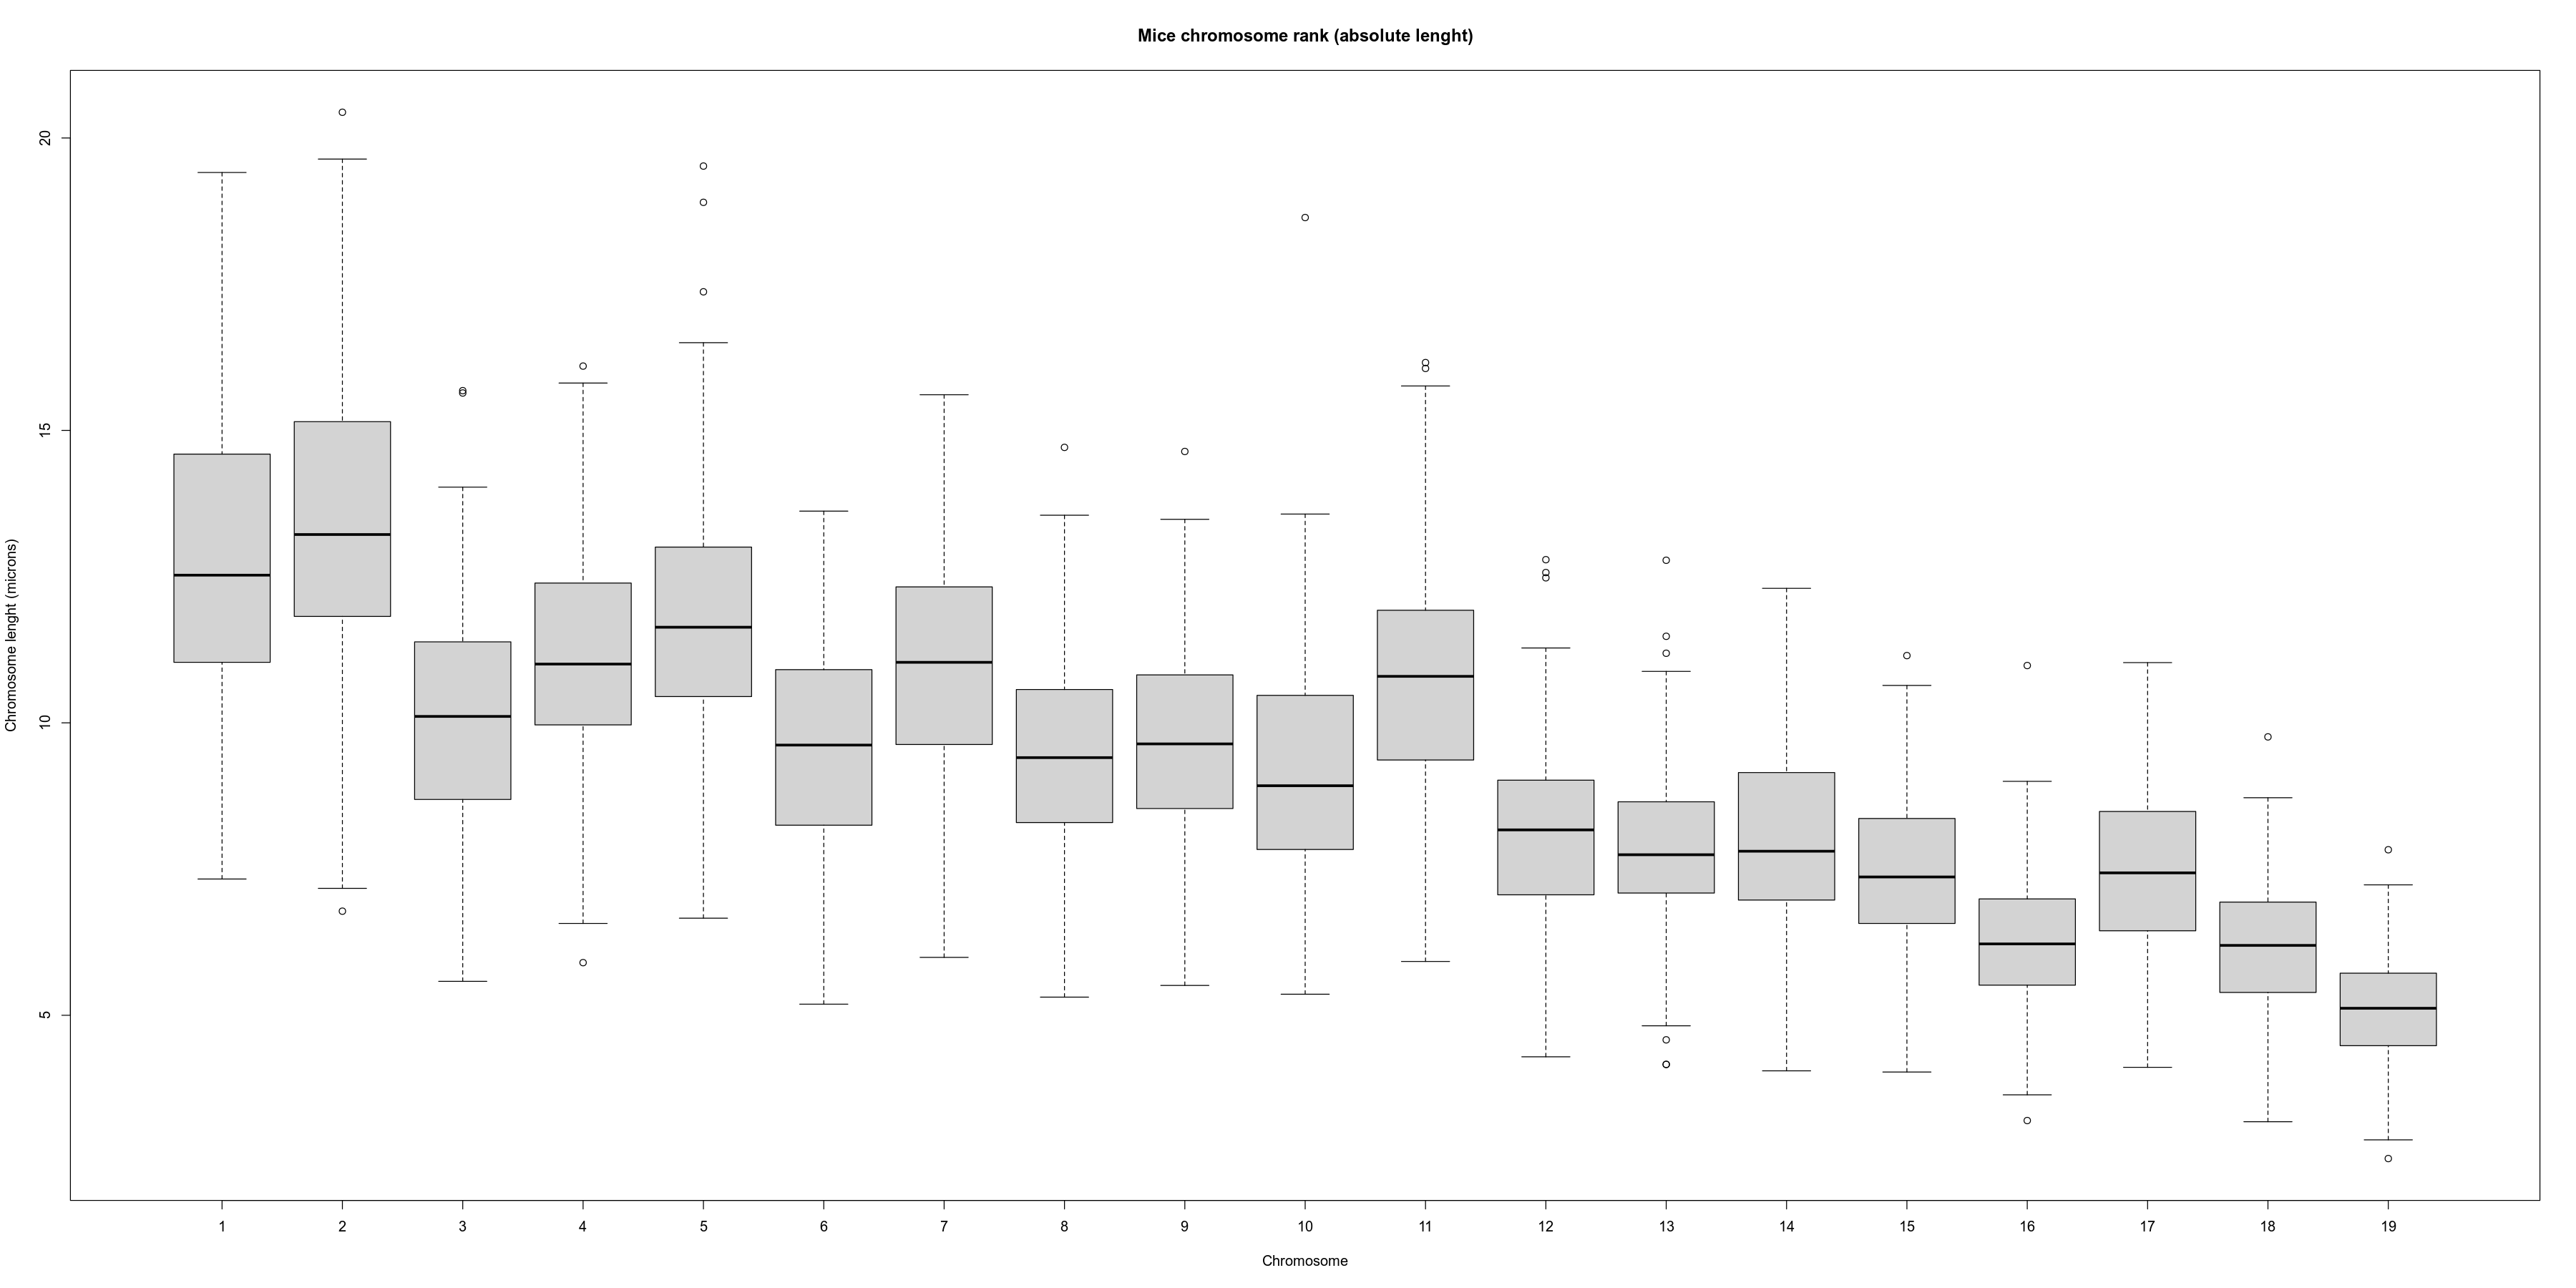

In [11]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot(Len ~ FITC.Rank, data = data, main = "Mice chromosome rank (absolute lenght)",
   xlab = "Chromosome", ylab = "Chromosome lenght (microns)")

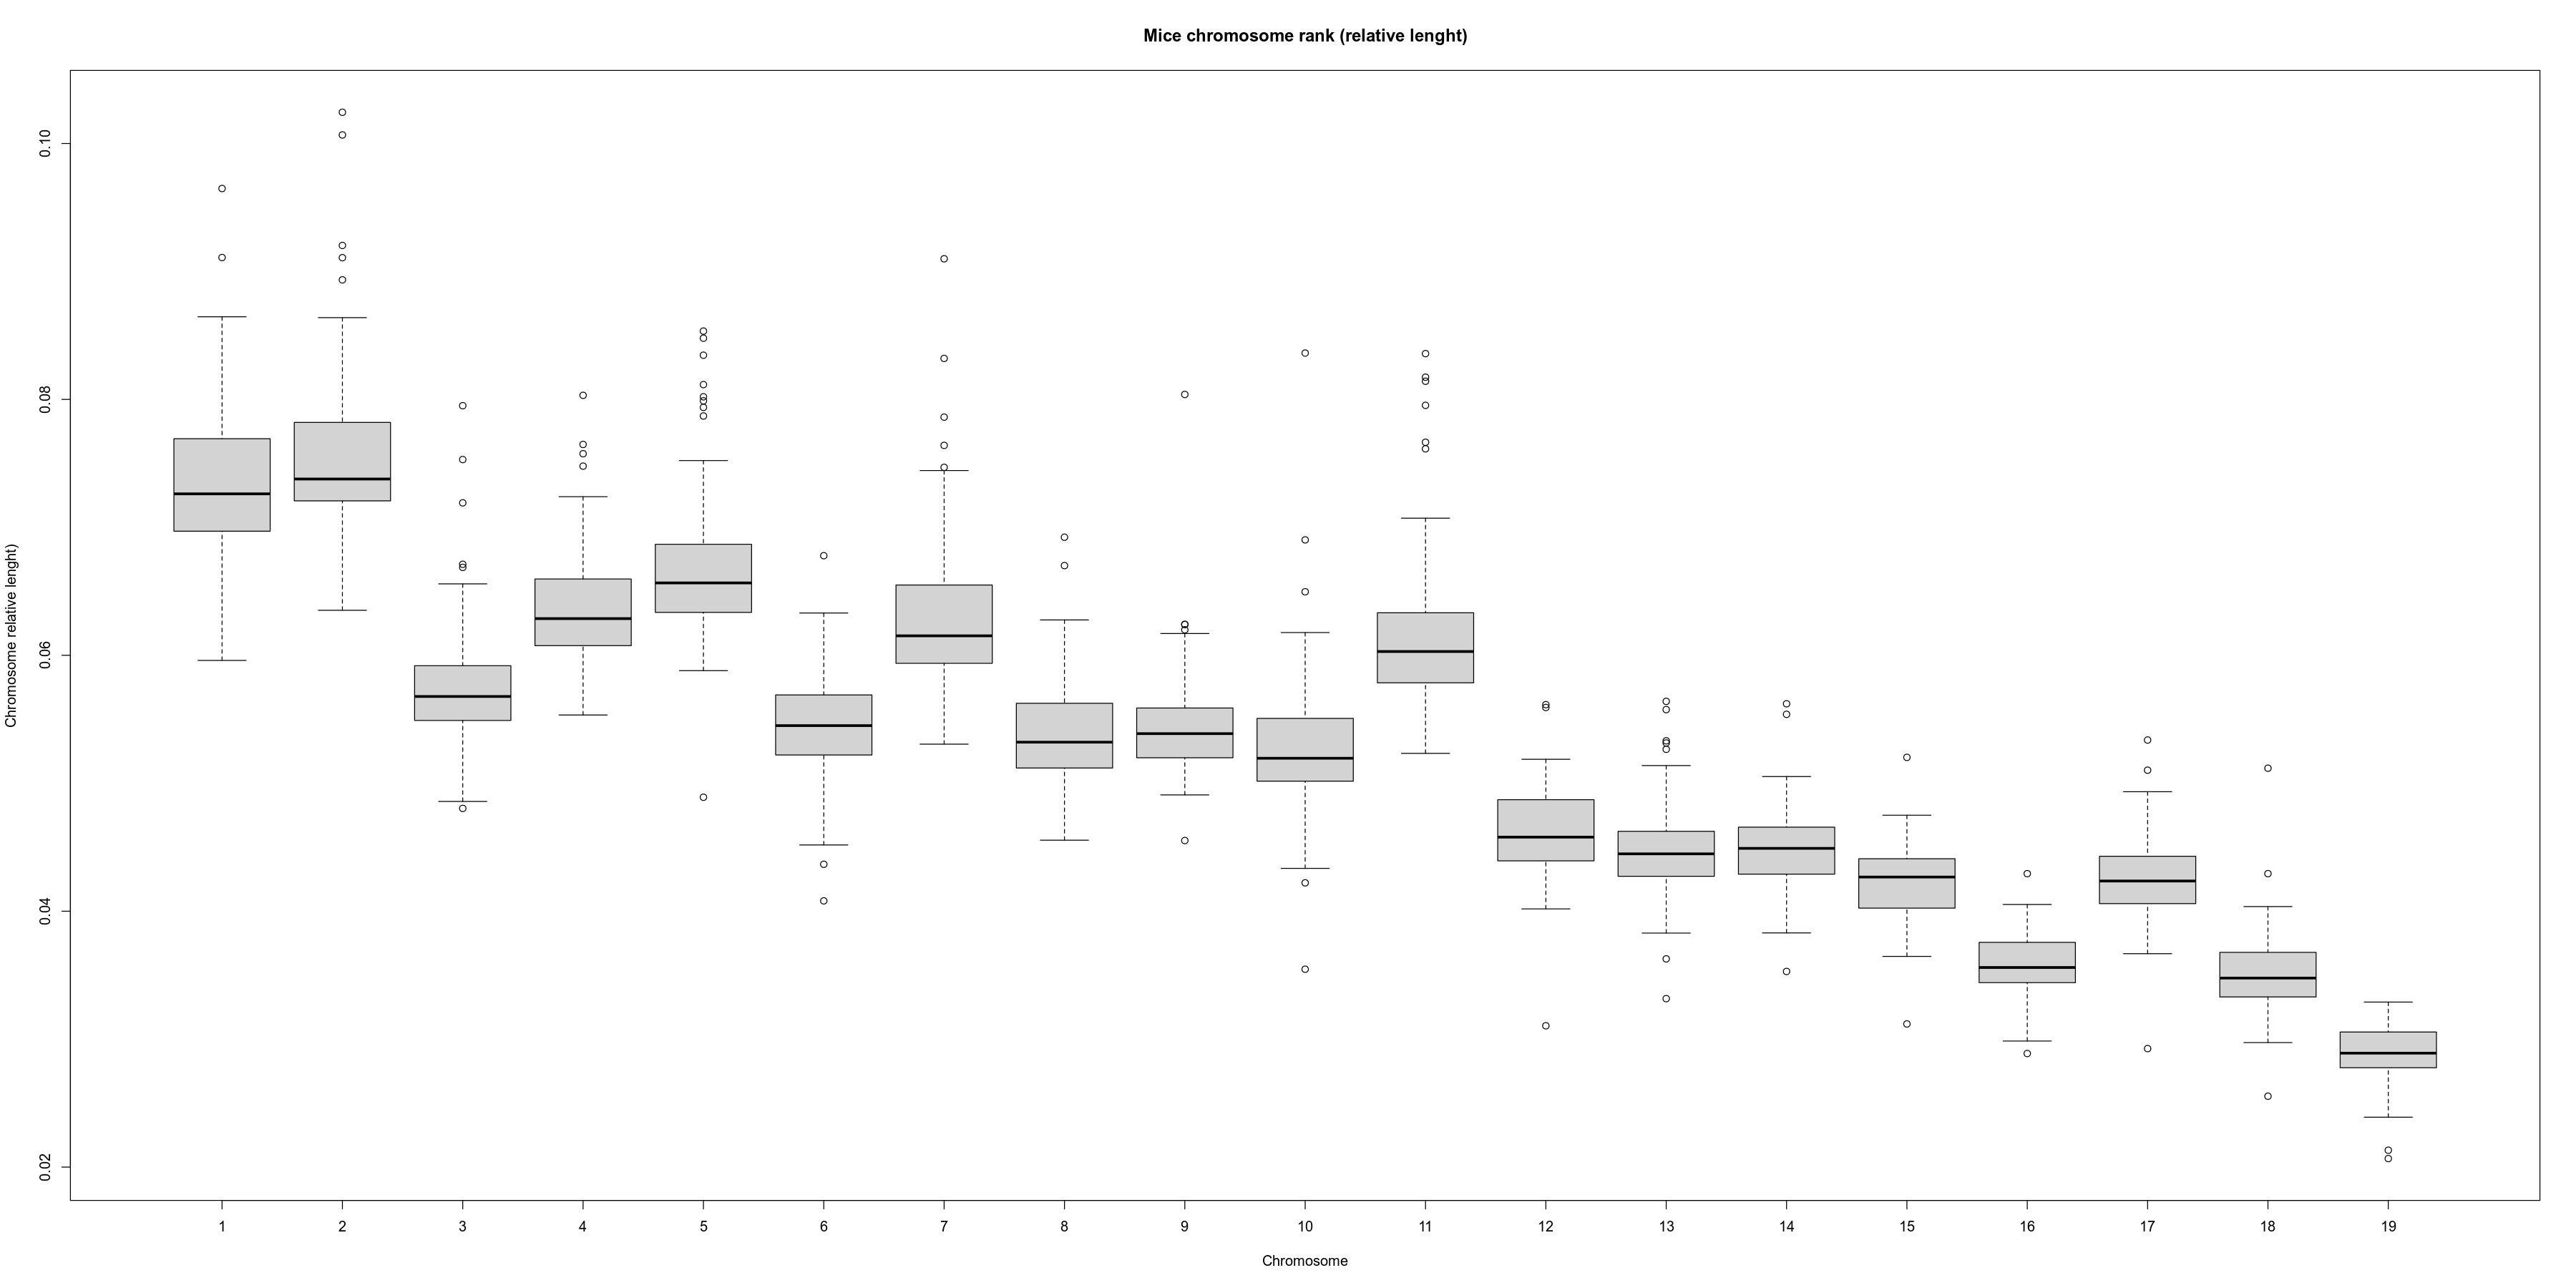

In [12]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot(Rel.len ~ FITC.Rank, data = data, main = "Mice chromosome rank (relative lenght)",
   xlab = "Chromosome", ylab = "Chromosome relative lenght)")

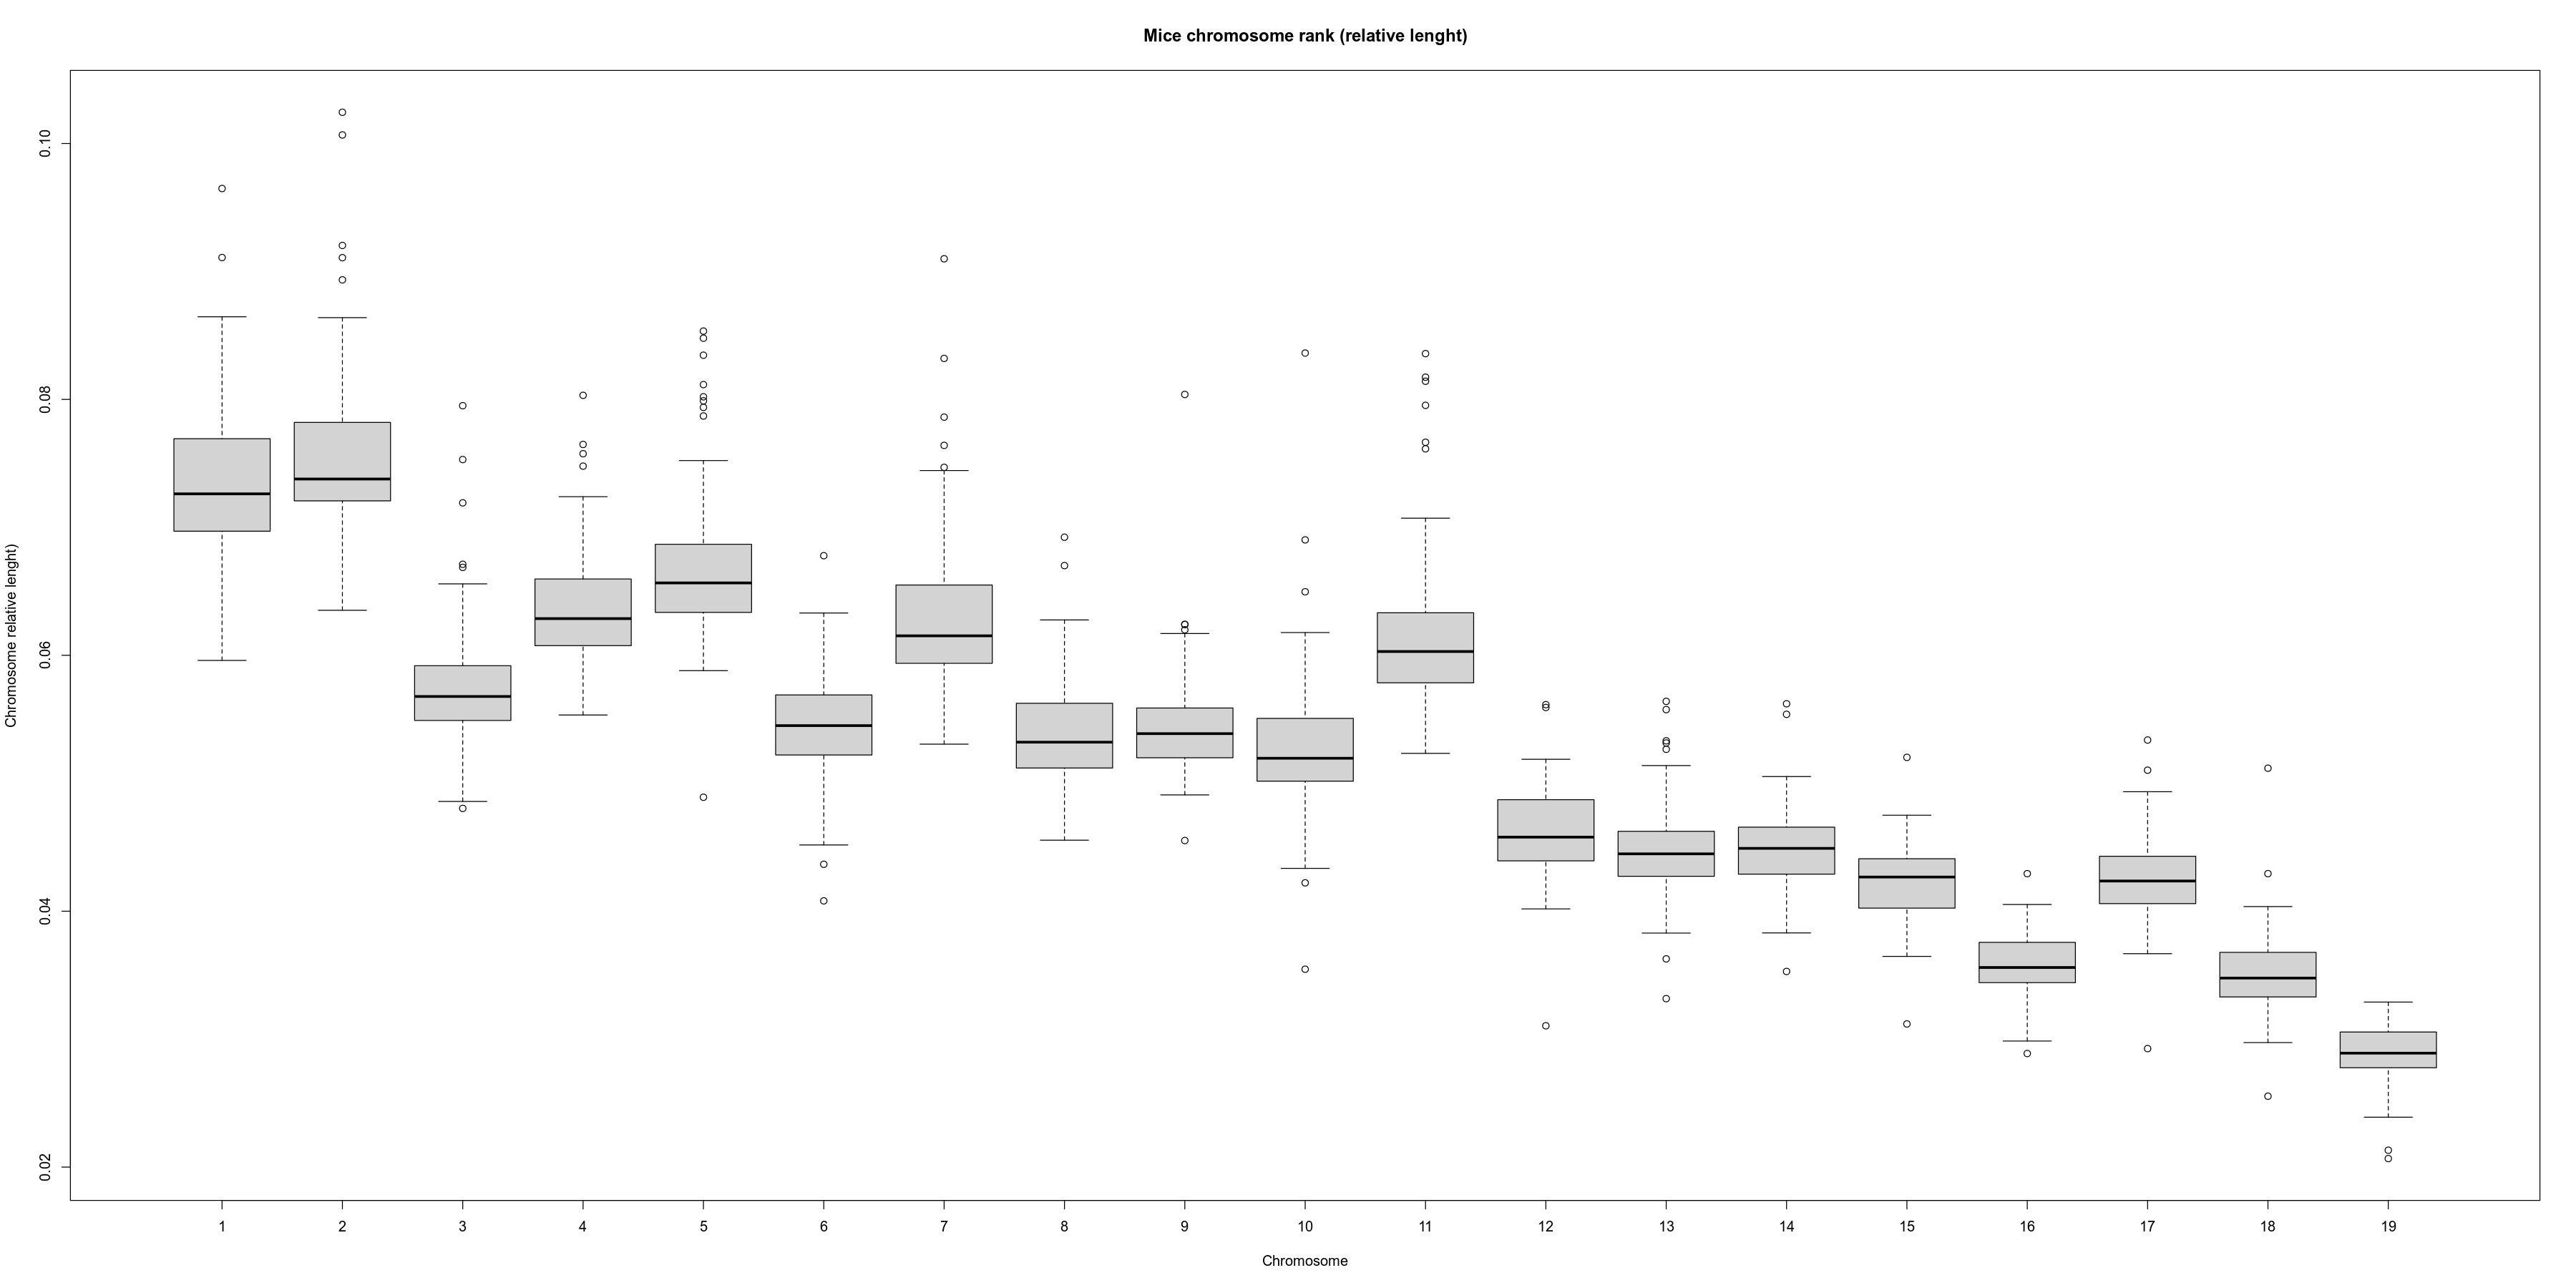

In [13]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot(Rel.len ~ FITC.Rank, data = data, main = "Mice chromosome rank (relative lenght)",
   xlab = "Chromosome", ylab = "Chromosome relative lenght)")

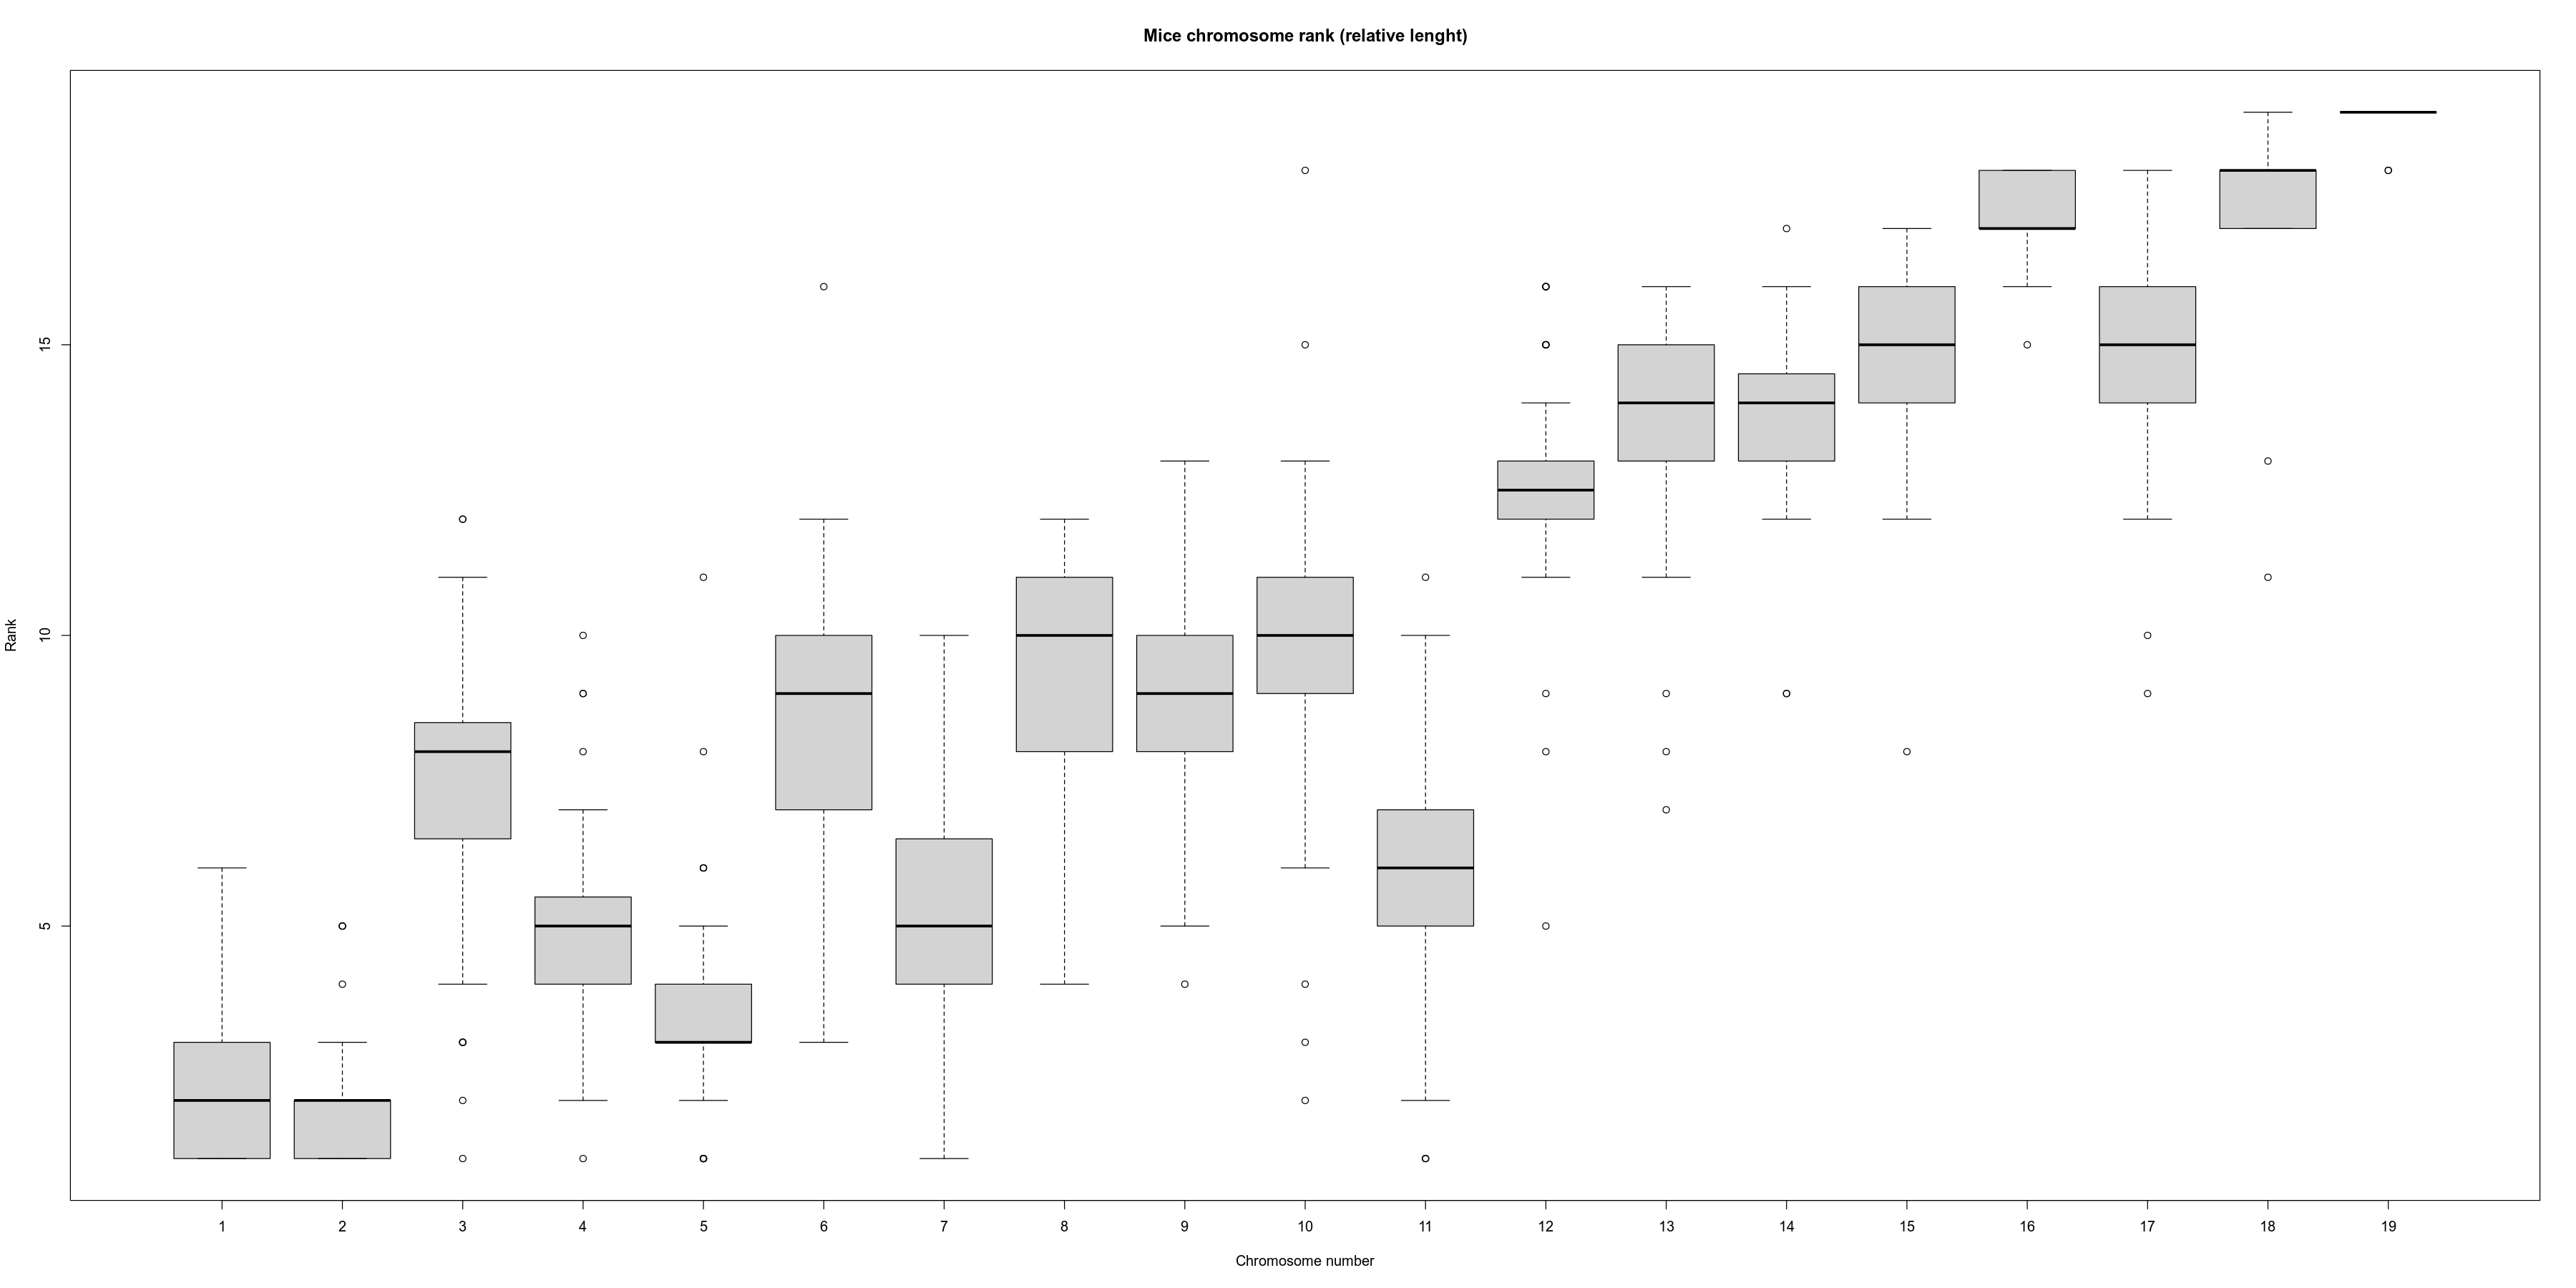

In [14]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot (Lgth.Rank ~ FITC.Rank, data = data, main = "Mice chromosome rank (relative lenght)",
   xlab = "Chromosome number", ylab = "Rank")

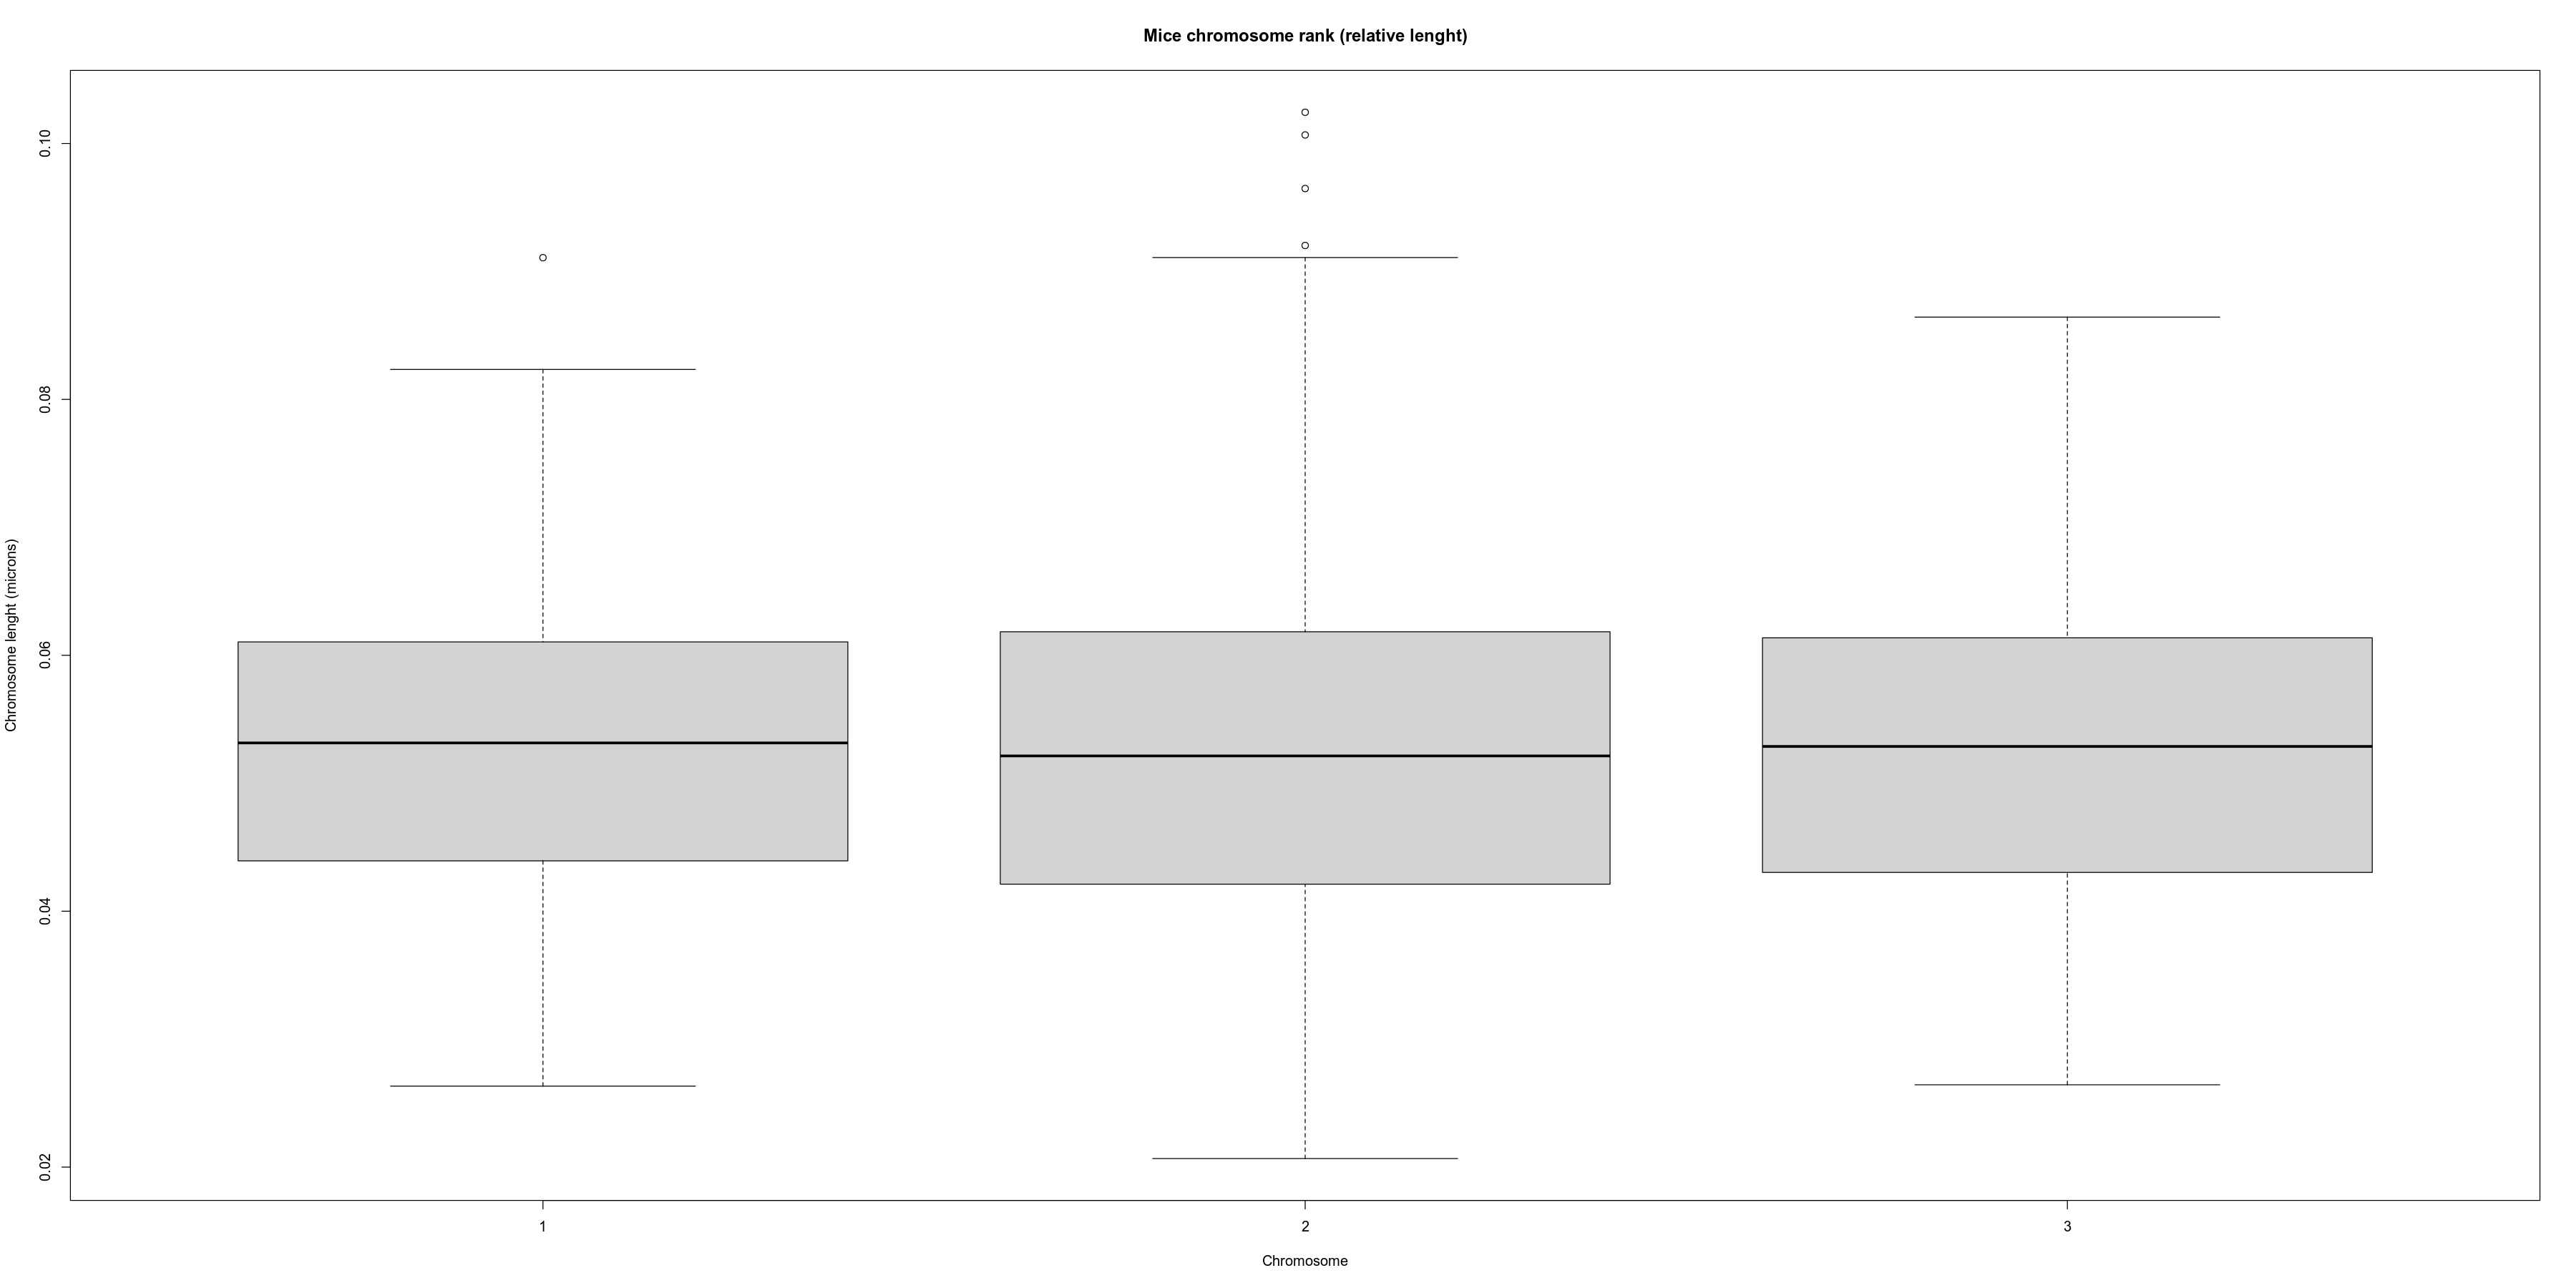

In [15]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot(Rel.len ~ mouse, data = data, main = "Mice chromosome rank (relative lenght)",
   xlab = "Mouse", ylab = "Chromosome lenght (microns)")

Scatterplot

In [16]:
# Simple Scatterplot
attach(data)
#plot(Set.ID, Total.Len, main = "Mice chromosome rank", xlab = "Cell", ylab = "Chromosome Lenght (microns)", pch=19, ylim = c(0,300))

# lines(lowess(Set.ID, Total.Len), col = "blue") # lowess line (x,y)

The following objects are masked from data (pos = 3):

    FITC.Rank, Len, Lgth.Rank, mouse, No_foci, Rank.Match, Rel.len,
    Set.ID, Total.Len




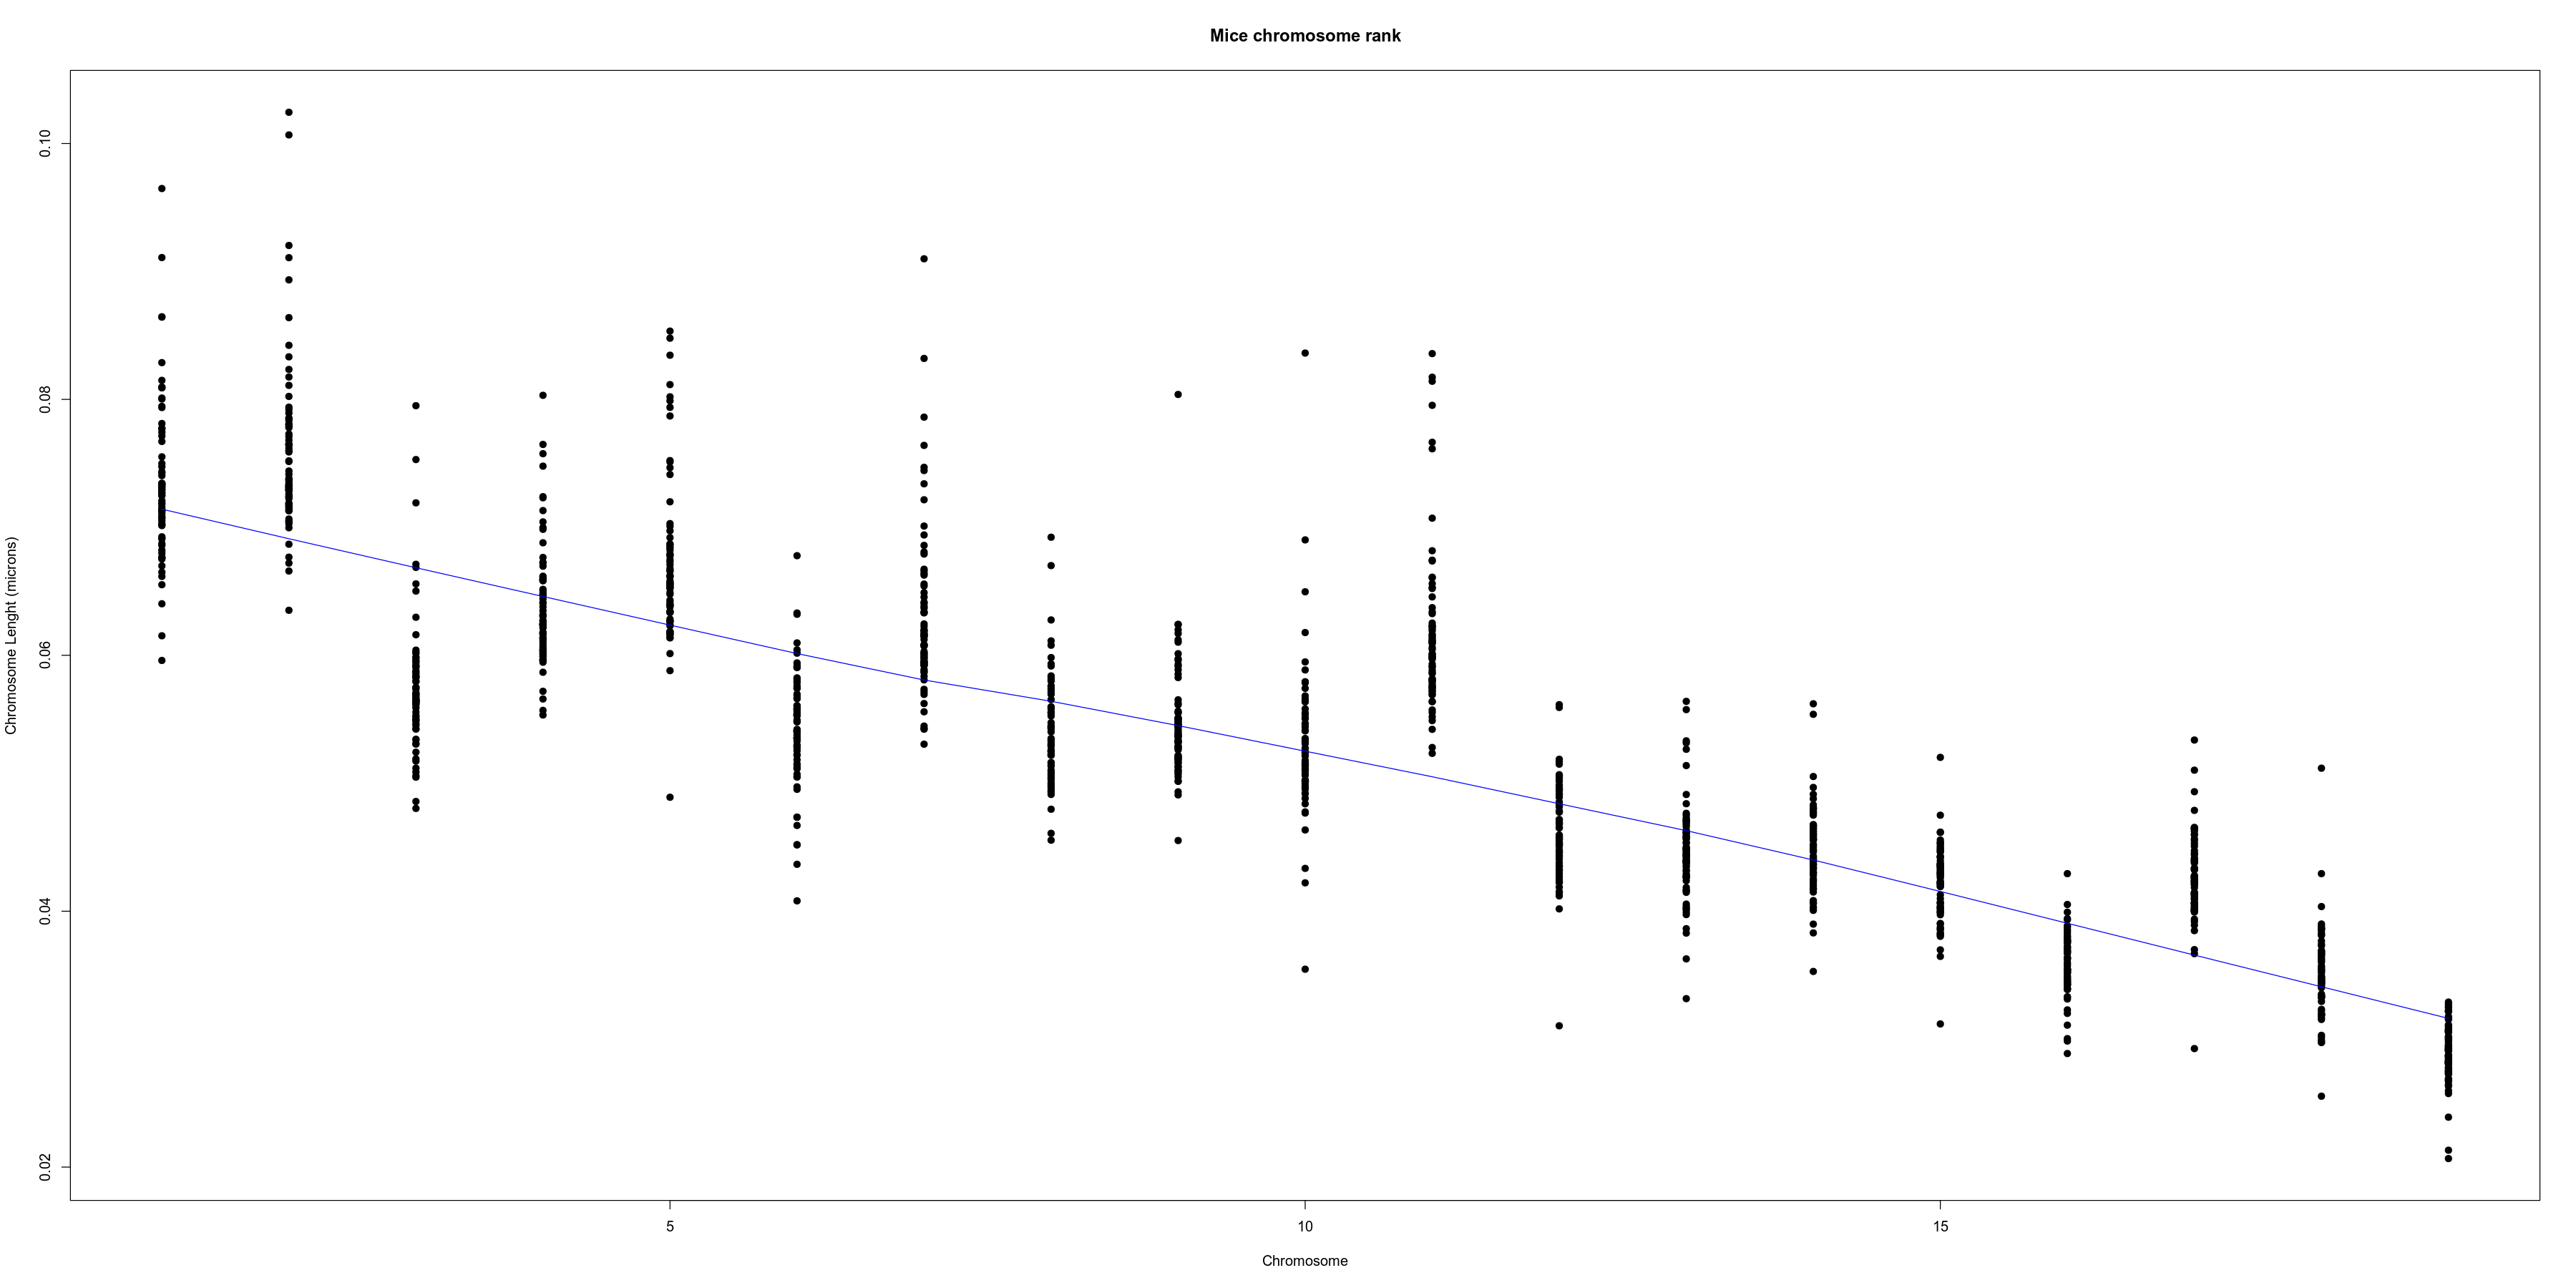

In [17]:
# Simple Scatterplot
attach(data)
plot(FITC.Rank, Rel.len, main = "Mice chromosome rank",
   xlab = "Chromosome", ylab = "Chromosome Lenght (microns)", pch = 19)

abline(lm(FITC.Rank~Rel.len), col = "red") # regression line (y~x)
lines(lowess(FITC.Rank, Rel.len), col = "blue") # lowess line (x,y)

mouse FITC.Rank Set.ID     Rel.len    Len  
1 1     1         m1-3 s4 nu 0.07181488 12.86
2 1     2         m1-3 s4 nu 0.07332749 13.13
3 1     3         m1-3 s4 nu 0.06686973 11.97
4 1     4         m1-3 s4 nu 0.06120195 10.96
5 1     5         m1-3 s4 nu 0.06388799 11.44
6 1     6         m1-3 s4 nu 0.05684487 10.18

The following objects are masked from data (pos = 3):

    FITC.Rank, Len, mouse, Rel.len, Set.ID


The following objects are masked from data (pos = 4):

    FITC.Rank, Len, mouse, Rel.len, Set.ID




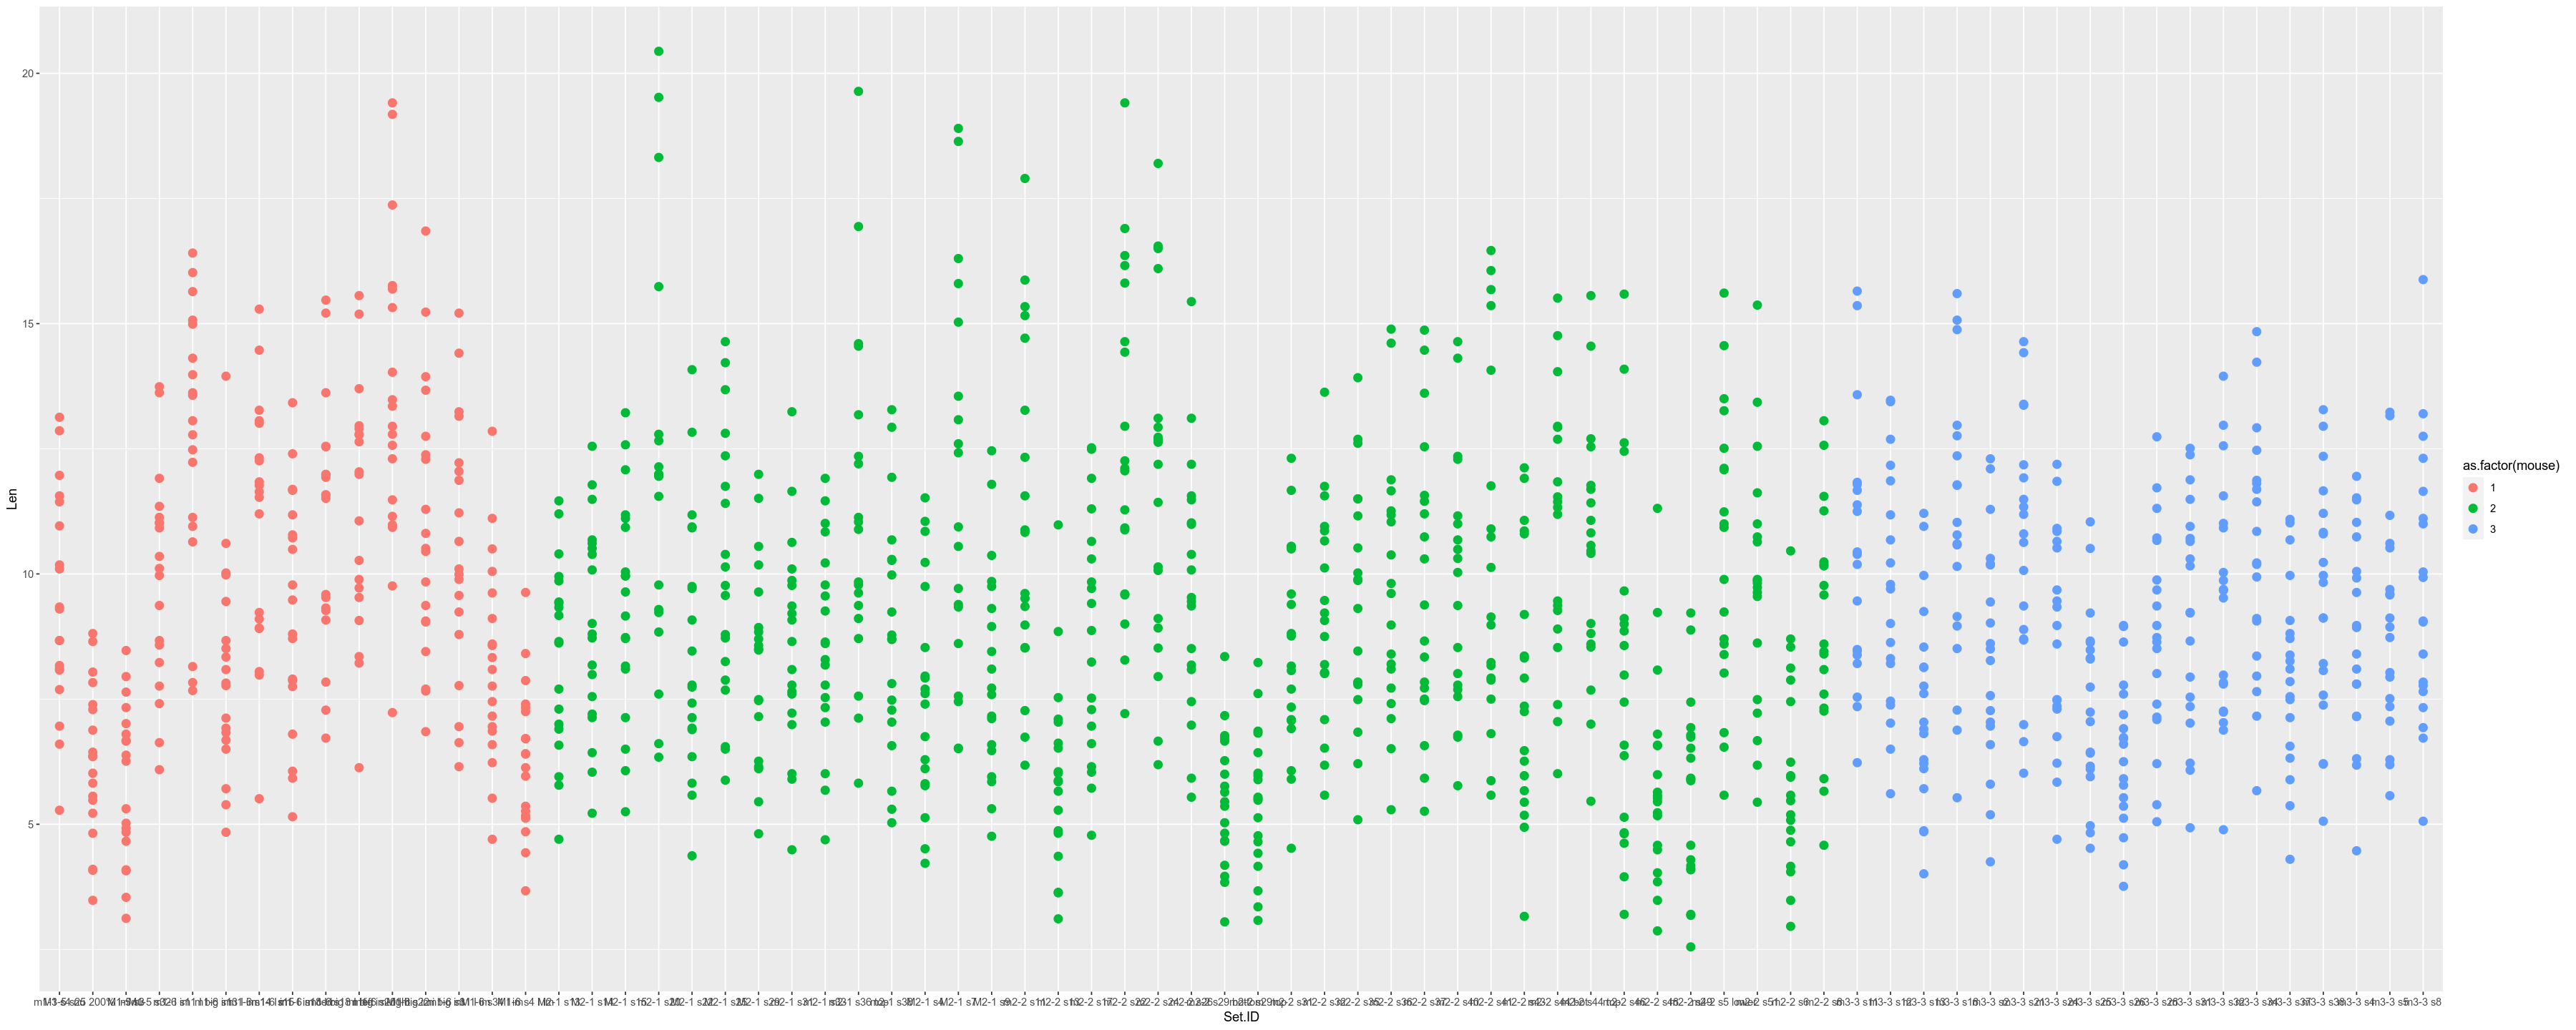

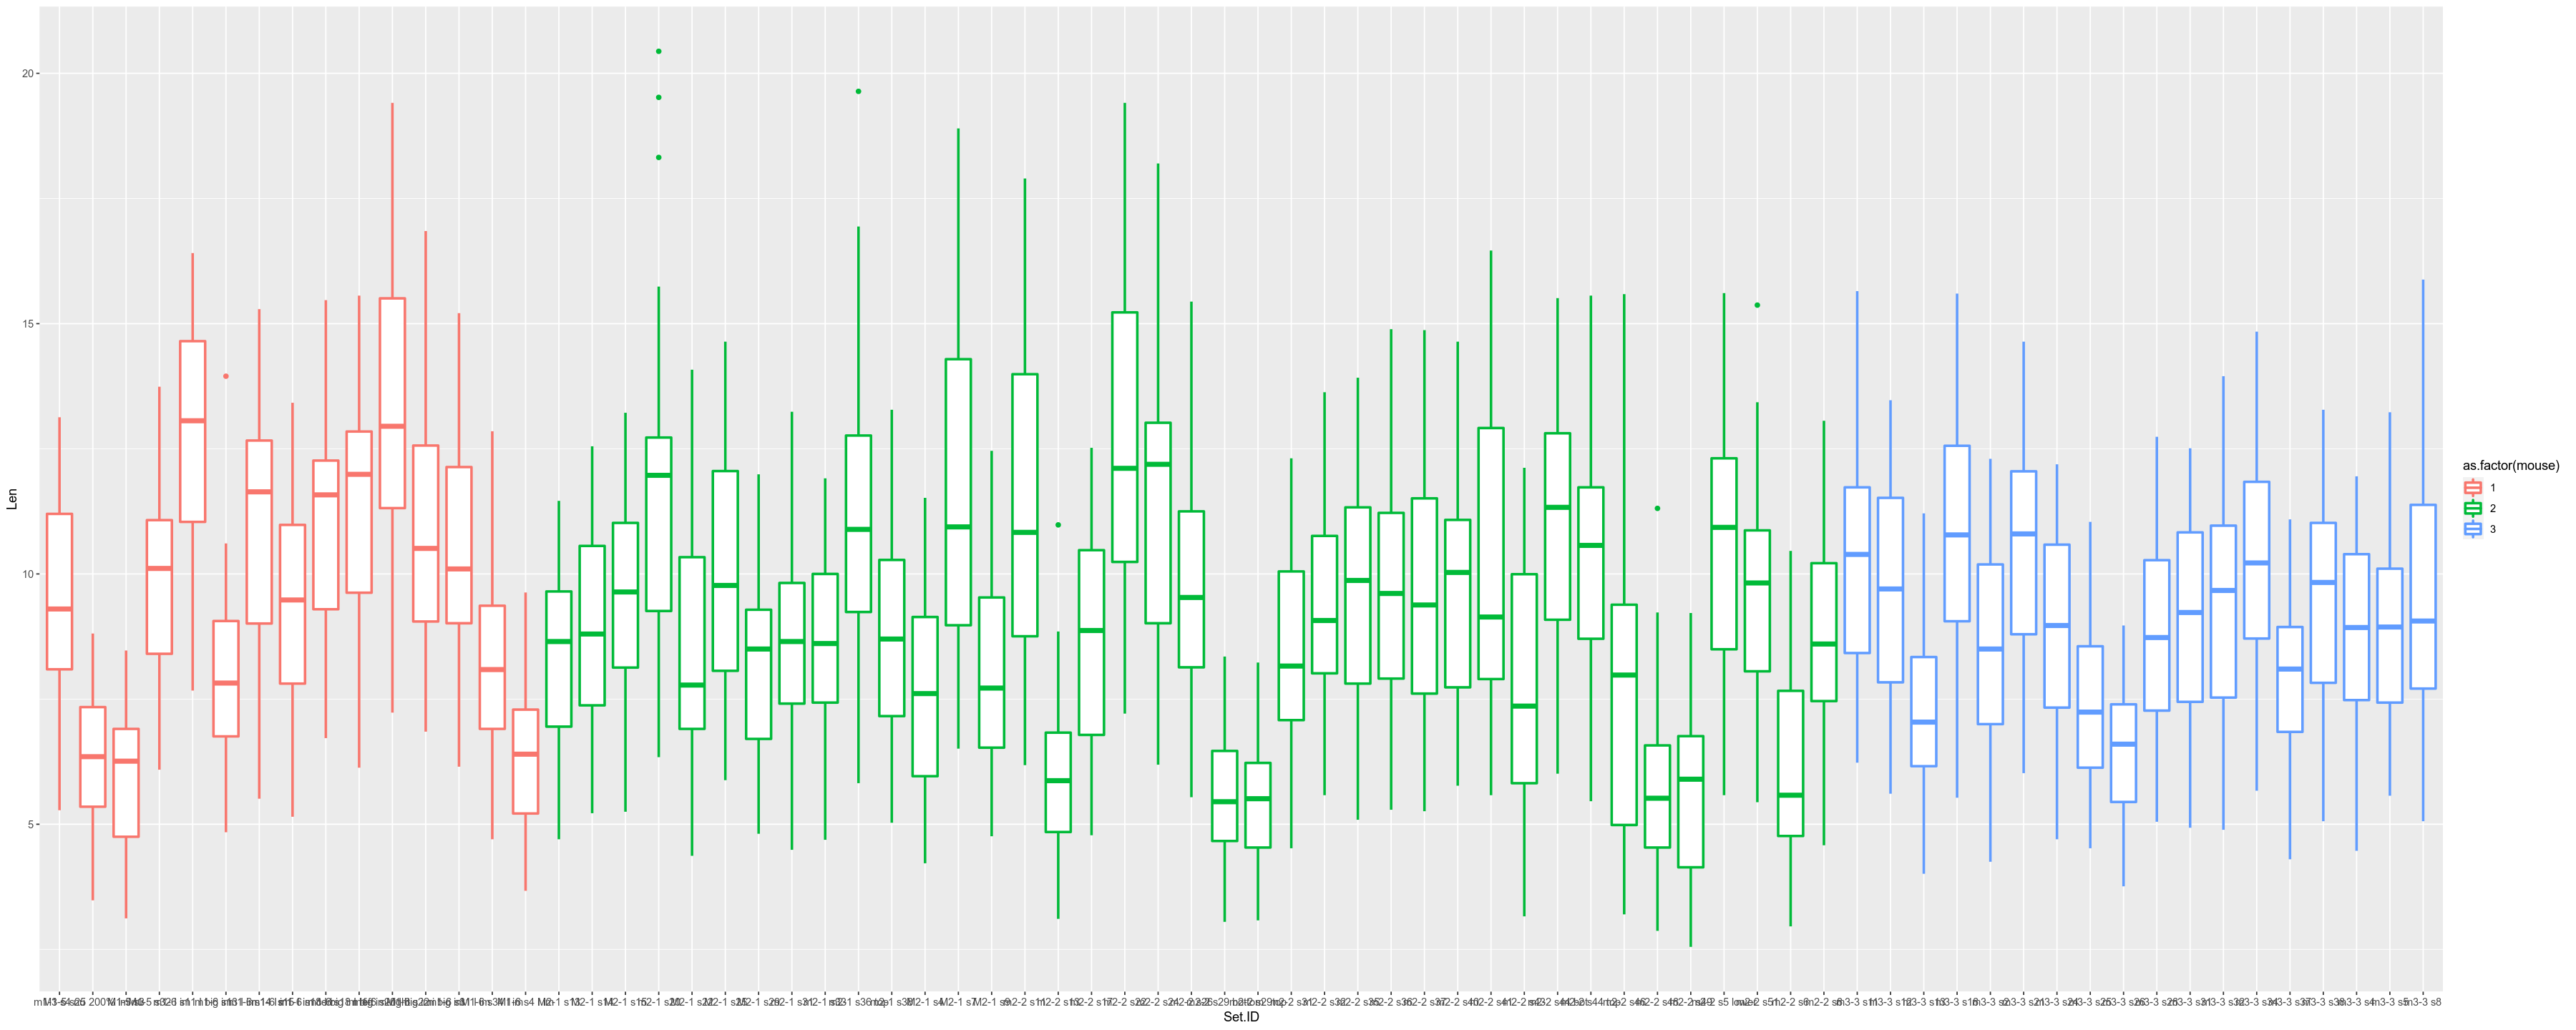

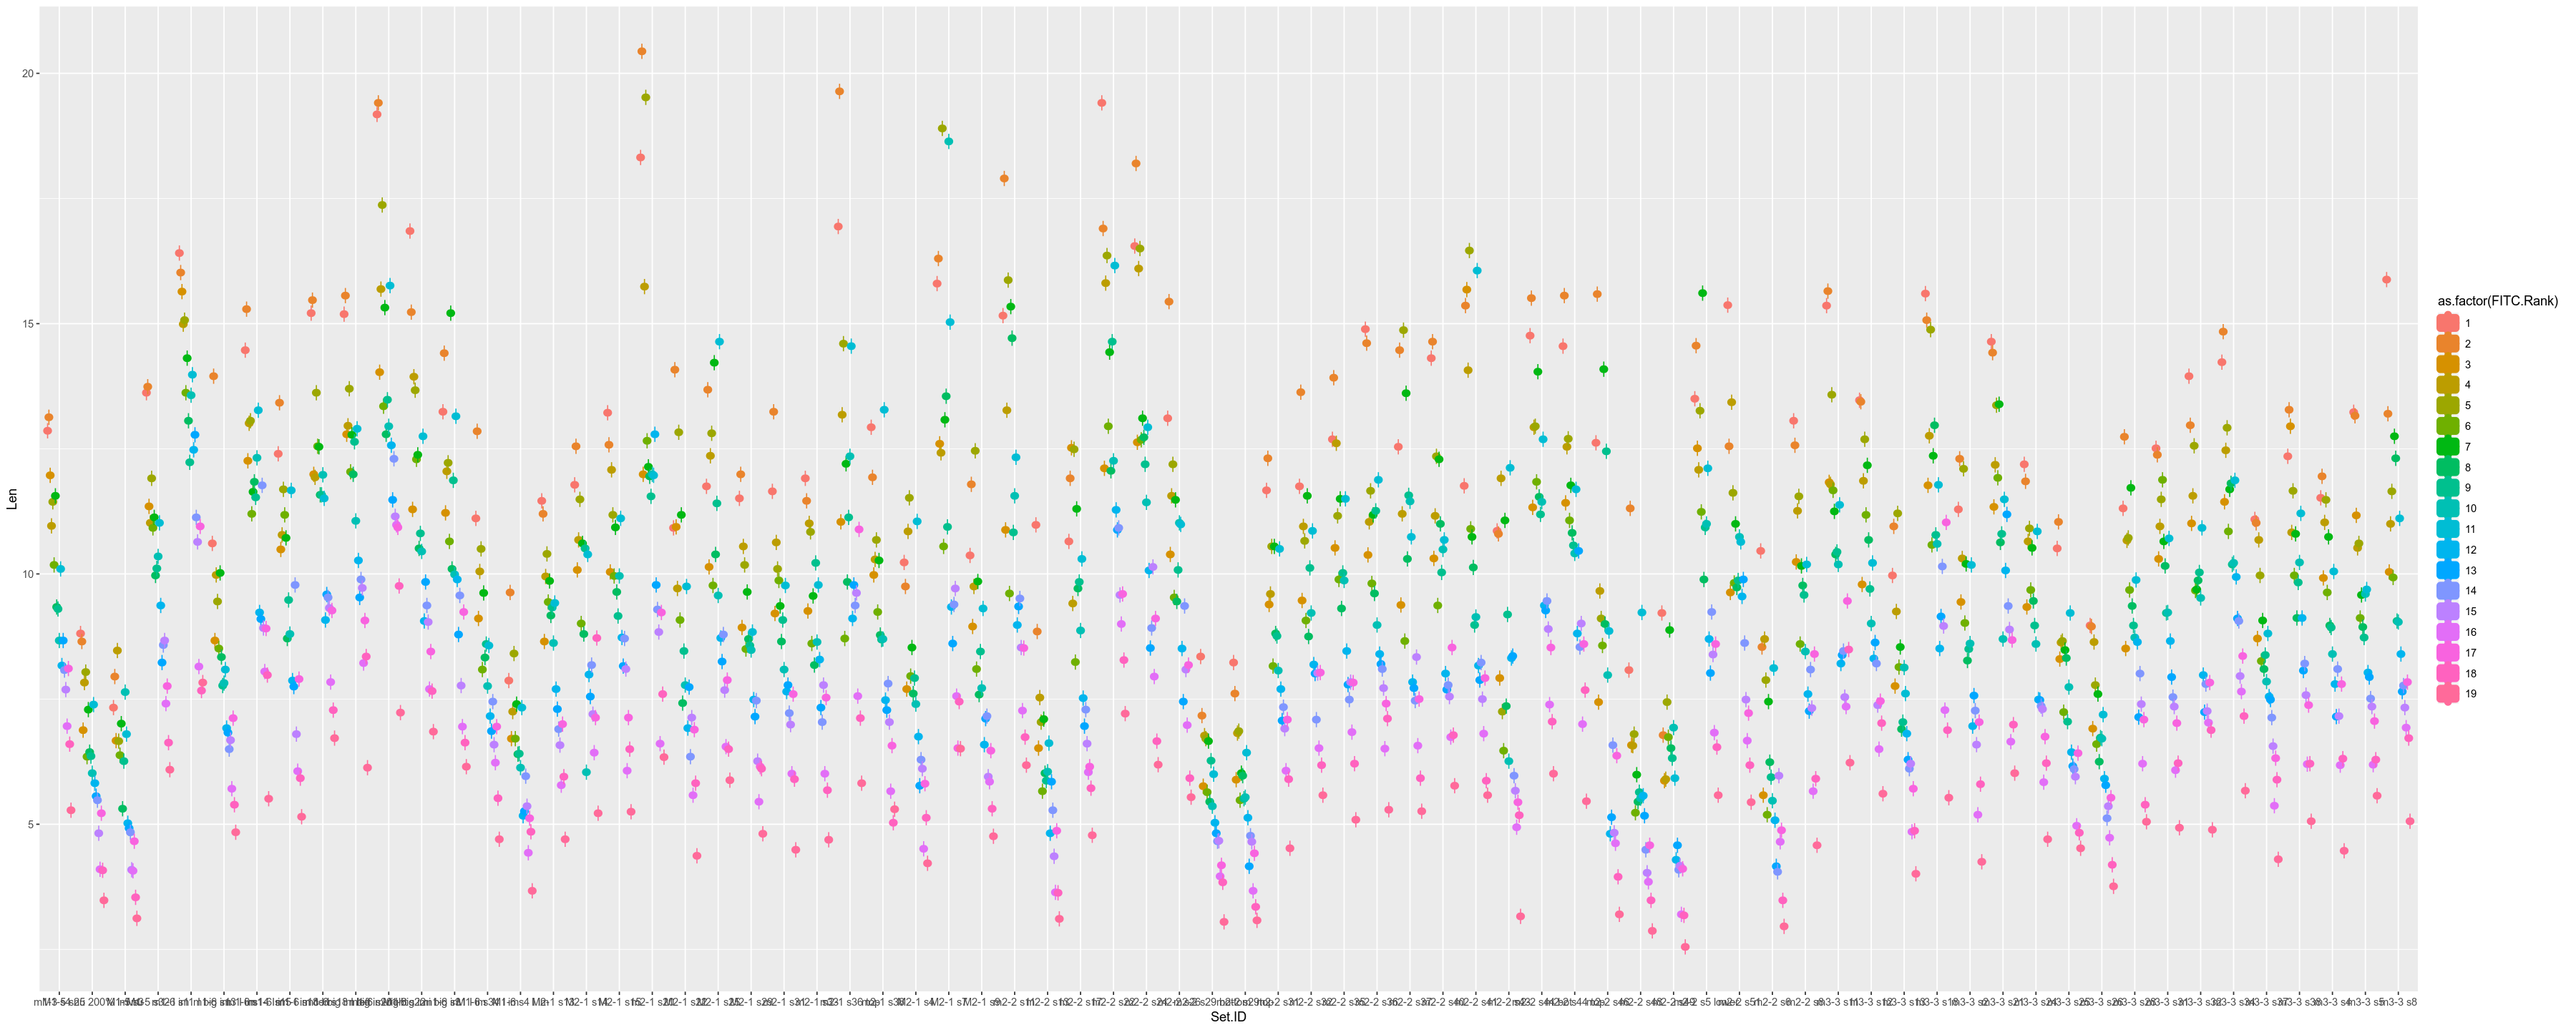

In [18]:
# Simple Scatterplot

dataplot <- data[, c("mouse", "FITC.Rank", "Set.ID", "Rel.len", "Len")]
head(dataplot)
attach(dataplot)

options(repr.plot.width=30, repr.plot.height=12) # Plot size

# install.packages("ggplot2")
library("ggplot2")

ggplot(dataplot, aes(Set.ID, Len, color = as.factor(mouse))) + geom_point(size=3)

ggplot(dataplot, aes(Set.ID, Len, color = as.factor(mouse))) + geom_boxplot(size=1)

ggplot(dataplot, aes(Set.ID, Len, color = as.factor(FITC.Rank))) + geom_boxplot(size=3)

#abline(lm(Lgth.Rank~Len), col = "red") # regression line (y~x)
#lines(lowess(Lgth.Rank, Len), col = "blue") # lowess line (x,y)

Ara anem a veure si el rang del cromosoma quadra amb el rang establert per l'Ignasi

Afegim una fila al final on guardarem el resultat (True or False)

In [19]:
data$Rank.predicted.Ignasi <- NA
head(data)
data$Rank.real <- NA
head(data)
data$Rank_interval.Match <- NA
head(data)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match Rank.predicted.Ignasi
1 FALSE      NA                   
2 FALSE      NA                   
3  TRUE      NA                   
4 FALSE      NA                   
5  TRUE      NA                   
6 FALSE      NA

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match Rank.predicted.Ignasi Rank.real
1 FALSE      NA                    NA       
2 FALSE      NA                    NA       
3  TRUE      NA                    NA       
4 FALSE      NA                    NA       
5  TRUE      NA                    NA       
6 FALSE      NA                    NA

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match Rank.predicted.Ignasi Rank.real Rank_interval.Match
1 FALSE      NA                    NA        NA                 
2 FALSE      NA                    NA        NA                 
3  TRUE      NA                    NA        NA                 
4 FALSE      NA                    NA        NA                 
5  TRUE      NA                    NA        NA                 
6 FALSE      NA                    NA        NA

In [20]:
results <- vector()

for(i in 1:nrow(data)) {
    cat("\nComparem cromosoma ", data[[i, "FITC.Rank"]], "de la celula", data[[i, "Set.ID"]])
    for(j in 1:nrow(df_ranks)){
        if ((data[[i,"FITC.Rank"]] >= df_ranks[[j,"chr_start"]]) && (data[[i,"FITC.Rank"]] <= df_ranks[[j,"chr_end"]])){
            cat("\n Sí és el rang ", j)
            #print(df_ranks[[j,"rank_interval"]])
            results <- c(results, df_ranks[[j, "rank_interval"]])
        }
        else{
            cat("\n No és el rang ", j)
        }
    }
}
head(results)
data$Rank.predicted.Ignasi <- results


Comparem cromosoma  1 de la celula m1-3 s4 nu
 Sí és el rang  1
 No és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  2 de la celula m1-3 s4 nu
 Sí és el rang  1
 No és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  3 de la celula m1-3 s4 nu
 No és el rang  1
 Sí és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  4 de la celula m1-3 s4 nu
 No és el rang  1
 Sí és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  5 de la celula m1-3 s4 nu
 No és el rang  1
 Sí és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  6 de la celula m1-3 s4 nu
 No és el rang  1
 No és el rang  2
 Sí és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  7 de la celula m1-3 s4 nu
 No és el rang  1
 No és el rang  2
 Sí és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  8 de la celula m1-3 s4 nu
 

[1] 1 1 2 2 2 3

In [21]:
results <- vector()

for(i in 1:nrow(data)) {
    cat("\nComparem cromosoma ", data[[i, "Lgth.Rank"]], "de la celula", data[[i, "Set.ID"]])
    for(j in 1:nrow(df_ranks)){
        if ((data[[i,"Lgth.Rank"]] >= df_ranks[[j,"chr_start"]]) && (data[[i,"Lgth.Rank"]] <= df_ranks[[j,"chr_end"]])){
            cat("\n Sí és el rang ", j)
            #print(df_ranks[[j,"rank_interval"]])
            results <- c(results, df_ranks[[j, "rank_interval"]])
        }
        else{
            cat("\n No és el rang ", j)
        }
    }
}
head(results)
data$Rank.real <- results


Comparem cromosoma  2 de la celula m1-3 s4 nu
 Sí és el rang  1
 No és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  1 de la celula m1-3 s4 nu
 Sí és el rang  1
 No és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  3 de la celula m1-3 s4 nu
 No és el rang  1
 Sí és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  6 de la celula m1-3 s4 nu
 No és el rang  1
 No és el rang  2
 Sí és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  5 de la celula m1-3 s4 nu
 No és el rang  1
 Sí és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  7 de la celula m1-3 s4 nu
 No és el rang  1
 No és el rang  2
 Sí és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  4 de la celula m1-3 s4 nu
 No és el rang  1
 Sí és el rang  2
 No és el rang  3
 No és el rang  4
 No és el rang  5
Comparem cromosoma  9 de la celula m1-3 s4 nu
 

[1] 1 1 2 3 2 3

In [22]:
results <- vector()
for(i in 1:nrow(data)) {       # for-loop over rows
    #print(data[[i,"FITC.Rank"]])
    if (data[[i,"Rank.predicted.Ignasi"]] == data[[i,"Rank.real"]]){
        #print("Son lo mateix.")
        results <- c(results, TRUE)
    }
    else {
        #print("No coincideixen")
        results <- c(results, FALSE)
    }
}
print(head(results))


data$Rank_interval.Match <- results # insert the values of vector "results" to the Rank.Match column in the data dataframe

[1]  TRUE  TRUE  TRUE FALSE  TRUE  TRUE


In [23]:
head(data)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match Rank.predicted.Ignasi Rank.real Rank_interval.Match
1 FALSE      1                     1          TRUE              
2 FALSE      1                     1          TRUE              
3  TRUE      2                     2          TRUE              
4 FALSE      2                     3         FALSE              
5  TRUE      2                     2          TRUE              
6 FALSE      3                     3          TRUE

Let's count the % of rank interval that matched our prediction

In [24]:
#install.packages("dplyr") # If necessary. May require to be run from a console (and 'conda install gxx_linux-64' installed)

library(dplyr)
globalpercent = sum((data[["Rank_interval.Match"]]) == TRUE)/count(data)*100
globalpercent = globalpercent[[1]]
cat(globalpercent,"% of the chromosomes fit the predicted rank interval.")

# Grouped by cell
df_count_cell = count(data,Set.ID, Rank_interval.Match)

df_count_cell$Percent <- NA

percent = vector()
len = length(unique(data$FITC.Rank)) #  Number of distinc values in the column Set.ID
percent = c(percent,df_count_cell$n / len * 100)
df_count_cell$Percent <- percent

df_count_cell <- df_count_cell[!(df_count_cell$Rank_interval.Match == FALSE),] # drop cells with FALSE

head(df_count_cell)


# Grouped by chromosome number
df_count_chr = count(data, Lgth.Rank, Rank_interval.Match)

df_count_chr$Percent <- NA

percent = vector()
len = length(unique(data$Set.ID)) #  Number of distinc values in the column Set.ID
percent = c(percent,df_count_chr$n / len*100)
df_count_chr$Percent <- percent

df_count_chr <- df_count_chr[!(df_count_chr$Rank_interval.Match == FALSE),] # drop cells with FALSE

head(df_count_chr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




71.34503 % of the chromosomes fit the predicted rank interval.

Set.ID              Rank_interval.Match n  Percent 
2  m1-3 s4 nu          TRUE                13 68.42105
4  M1-5 s25 200% im nu TRUE                15 78.94737
6  M1-5 s3             TRUE                11 57.89474
8  M1-5 s32 I im       TRUE                15 78.94737
10 m1-6 s11 I big im   TRUE                15 78.94737
12 m1-6 s13 I im       TRUE                15 78.94737

Lgth.Rank Rank_interval.Match n  Percent 
2  1         TRUE                59 81.94444
4  2         TRUE                54 75.00000
6  3         TRUE                40 55.55556
8  4         TRUE                45 62.50000
10 5         TRUE                31 43.05556
12 6         TRUE                53 73.61111

Plot the results

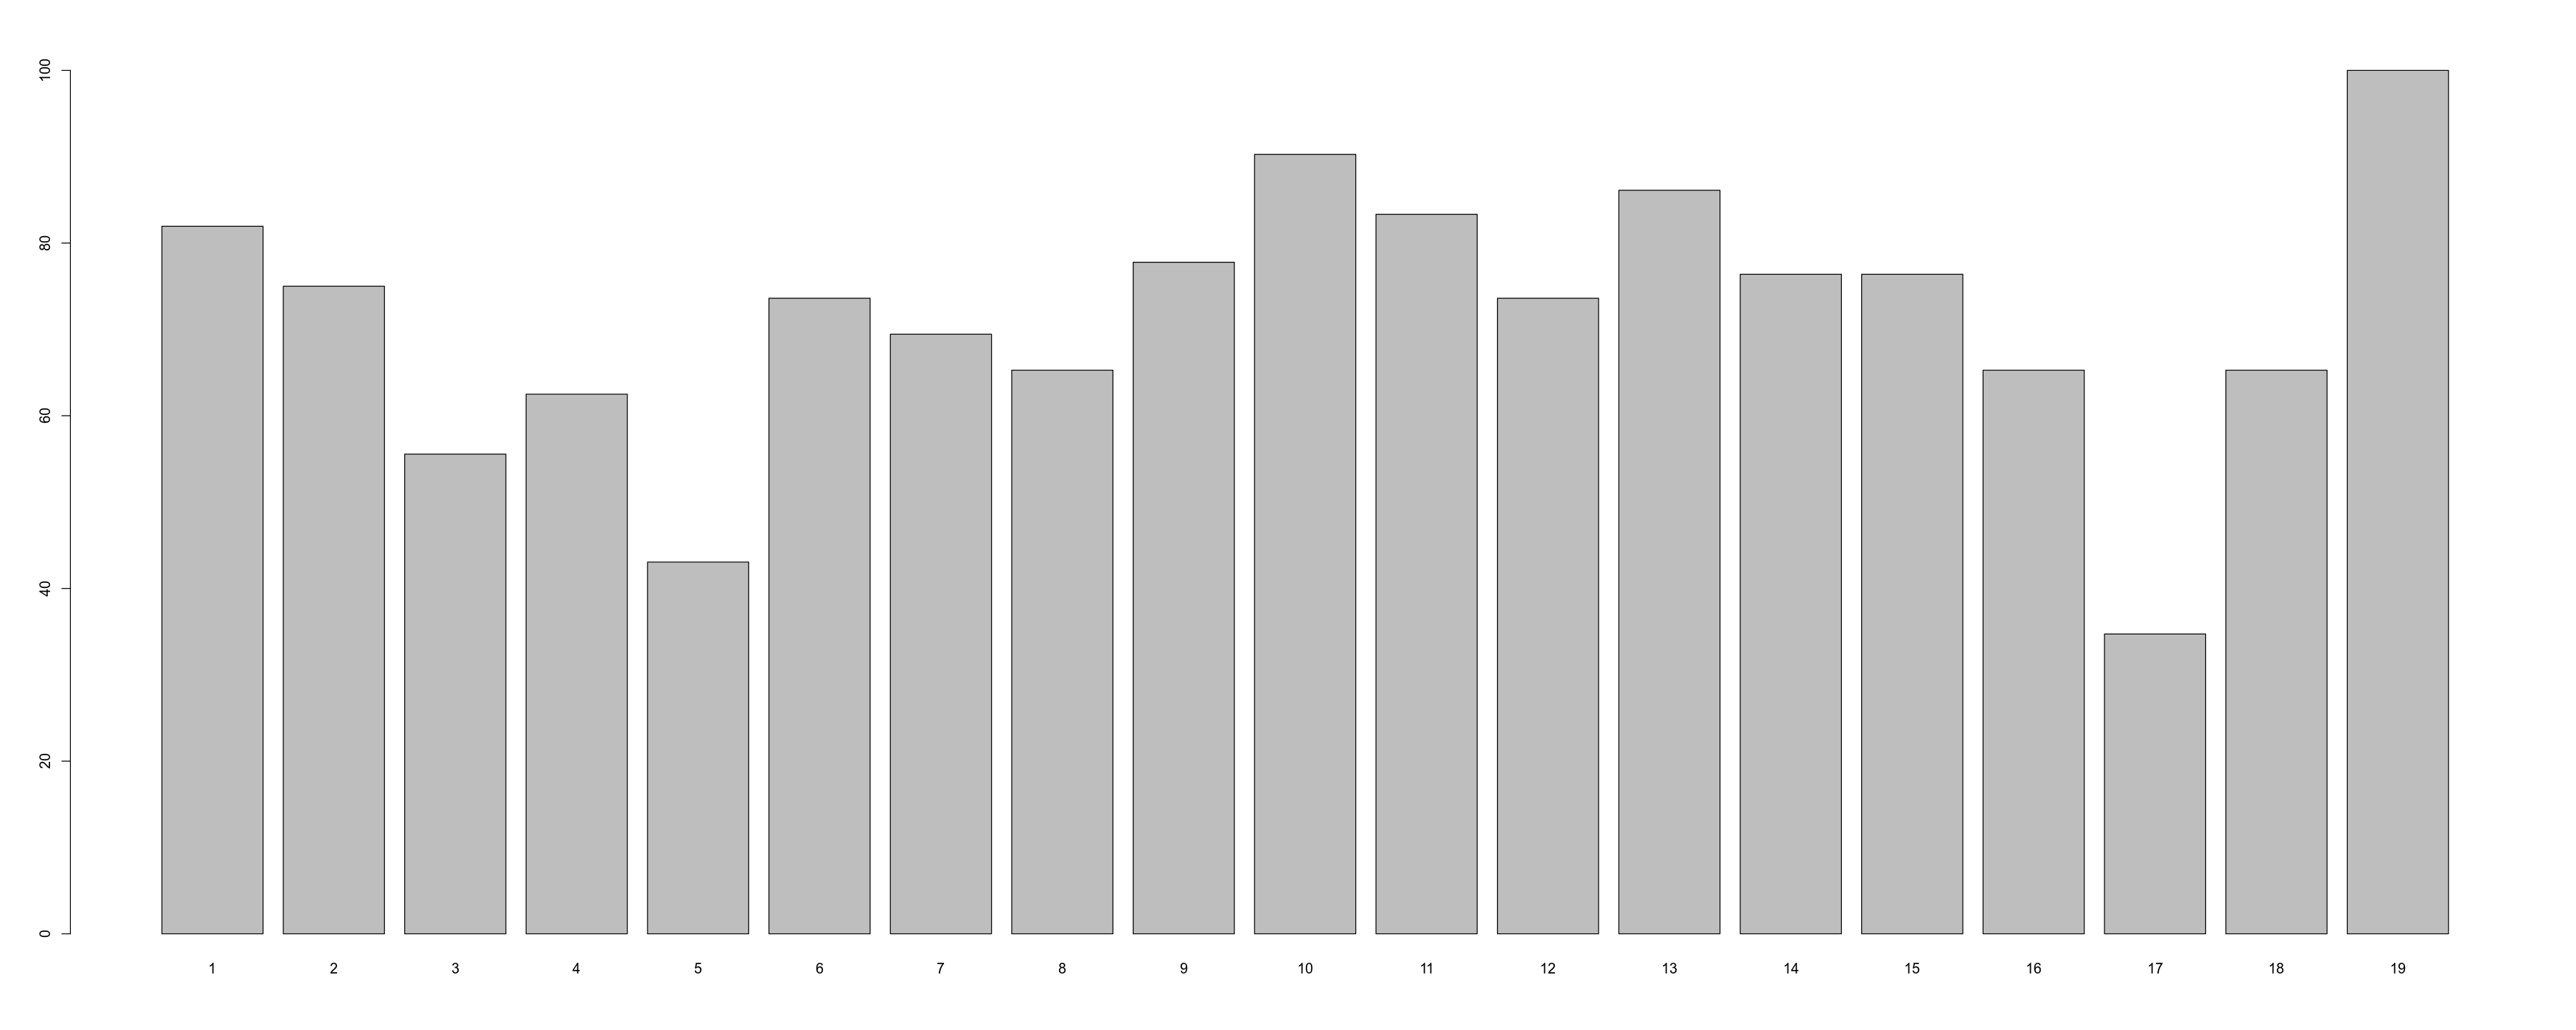

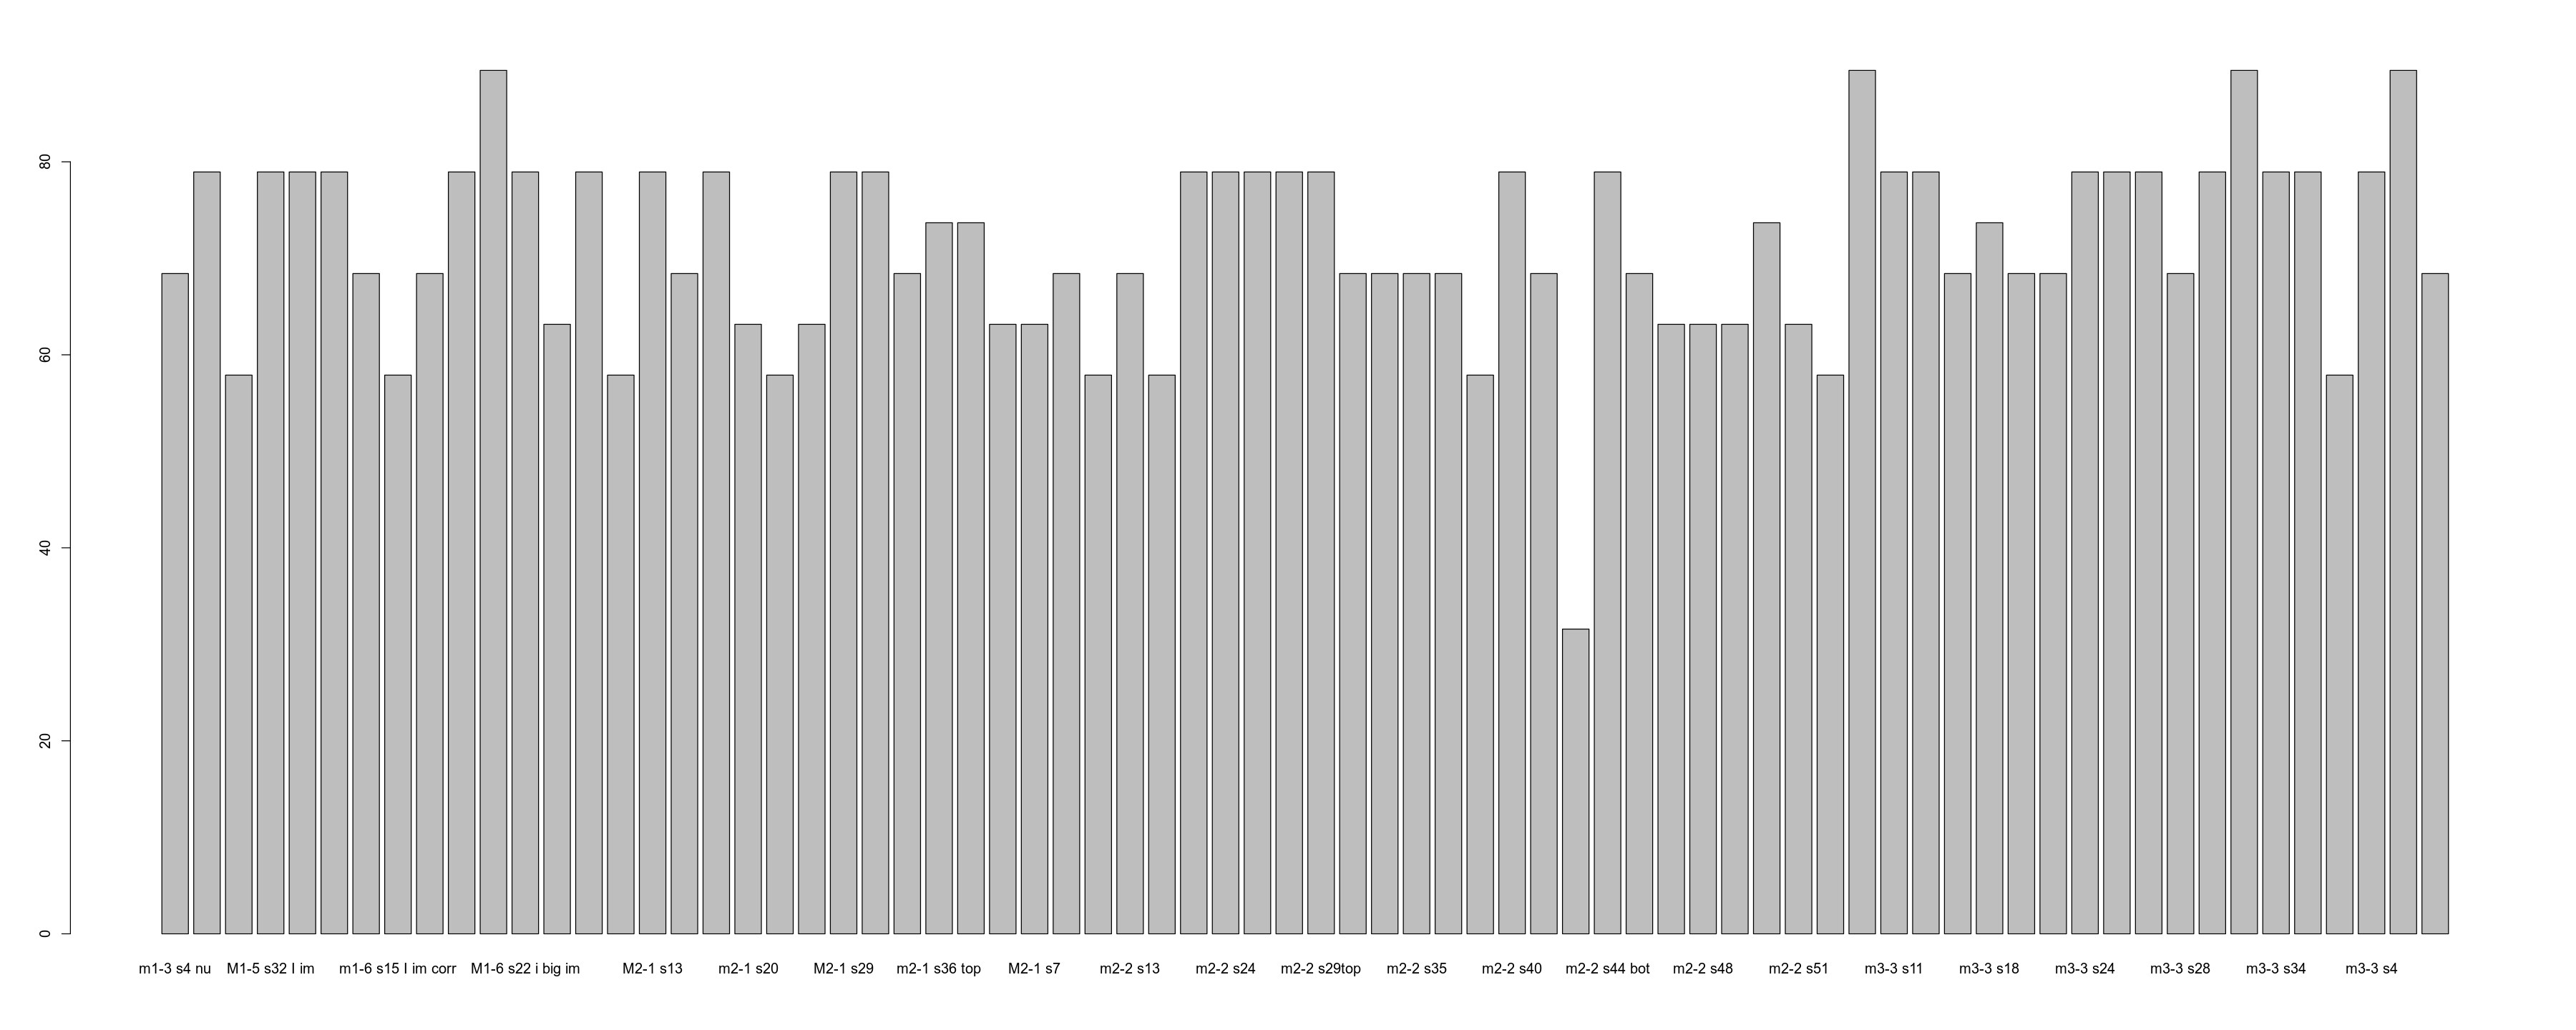

In [25]:
barplot(df_count_chr$Percent, names.arg=df_count_chr$Lgth.Rank)

barplot(df_count_cell$Percent, names.arg=df_count_cell$Set.ID)

## Univariate clustering

In [26]:
library(dplyr) # probably already loaded
#install.packages('dplyr')

head(data)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match Rank.predicted.Ignasi Rank.real Rank_interval.Match
1 FALSE      1                     1          TRUE              
2 FALSE      1                     1          TRUE              
3  TRUE      2                     2          TRUE              
4 FALSE      2                     3         FALSE              
5  TRUE      2                     2          TRUE              
6 FALSE      3                     3          TRUE

First we rescale the data

In [27]:
rescale_df <- data %>% 
mutate(RelLen_scal = scale(Rel.len), 
    Len_scal = scale(Len), 
    TotalLen_scal = scale(Total.Len)) %>% 
select(-c(Rel.len, Len, Total.Len))

head(rescale_df)
RelLen_kmeans = kmeans(rescale_df['RelLen_scal'], 5)


mouse Set.ID     FITC.Rank Lgth.Rank No_foci Rank.Match Rank.predicted.Ignasi
1 1     m1-3 s4 nu 1         2         1       FALSE      1                    
2 1     m1-3 s4 nu 2         1         1       FALSE      1                    
3 1     m1-3 s4 nu 3         3         1        TRUE      2                    
4 1     m1-3 s4 nu 4         6         2       FALSE      2                    
5 1     m1-3 s4 nu 5         5         1        TRUE      2                    
6 1     m1-3 s4 nu 6         7         1       FALSE      3                    
  Rank.real Rank_interval.Match RelLen_scal Len_scal  TotalLen_scal
1 1          TRUE               1.4077649   1.2377054 0.1520519    
2 1          TRUE               1.5187673   1.3277748 0.1520519    
3 2          TRUE               1.0448651   0.9408101 0.1520519    
4 3         FALSE               0.6289360   0.6038838 0.1520519    
5 2          TRUE               0.8260504   0.7640072 0.1520519    
6 3          TRUE               0.3091920   0.3436834 0.1520519

Lgth.Rank RelLen_scal
1 2         1.4077649  
2 1         1.5187673  
3 3         1.0448651  
4 6         0.6289360  
5 5         0.8260504  
6 7         0.3091920

K-means clustering with 5 clusters of sizes 288, 288, 216, 288, 288

Cluster means:
  Lgth.Rank RelLen_scal
1      14.5  -0.7082406
2       6.5   0.4780045
3      18.0  -1.4314273
4      10.5  -0.1045822
5       2.5   1.4083888

Clustering vector:
   [1] 5 5 5 2 2 2 5 4 4 4 2 1 4 1 1 3 1 3 3 5 5 2 5 5 4 2 2 4 4 2 4 1 1 1 3 1 3
  [38] 3 5 5 2 5 2 4 2 4 4 5 2 4 1 1 1 3 1 3 3 5 5 5 2 5 2 2 4 4 4 2 4 1 1 1 3 1
  [75] 3 3 5 5 5 2 5 2 2 4 1 4 2 4 4 1 1 3 1 3 3 5 5 2 5 2 2 5 2 4 4 4 1 1 1 1 3
 [112] 4 3 3 5 5 2 2 5 4 4 2 4 2 5 1 1 4 1 3 1 3 3 5 5 2 2 5 2 2 4 4 4 5 1 1 4 1
 [149] 3 1 3 3 5 5 2 2 5 5 2 4 4 2 4 1 4 1 1 3 1 3 3 5 5 2 5 5 4 2 4 2 4 2 4 1 1
 [186] 1 3 1 3 3 5 5 2 2 5 4 2 4 2 4 5 4 1 1 1 1 3 3 3 5 5 2 5 5 2 2 4 4 4 2 1 4
 [223] 1 1 3 1 3 3 5 5 2 2 2 4 5 4 2 4 5 4 1 1 1 3 1 3 3 5 5 2 5 5 4 2 4 2 4 2 1
 [260] 1 4 1 3 1 3 3 5 5 2 2 5 2 5 4 4 4 2 1 1 4 1 3 1 3 3 5 5 4 5 5 2 2 4 2 4 2
 [297] 4 1 1 1 3 1 3 3 5 5 2 5 5 4 2 4 2 3 2 1 1 4 1 3 1 4 3 5 5 2 5 5 2 2 4 4 4
 [334] 2 4 1 1 1 3 1 3 

   
     1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  1  0  0  0  0  0  0  0  0  0  0  0  0 72 72 72 72  0  0  0
  2  0  0  0  0 72 72 72 72  0  0  0  0  0  0  0  0  0  0  0
  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 72 72 72
  4  0  0  0  0  0  0  0  0 72 72 72 72  0  0  0  0  0  0  0
  5 72 72 72 72  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

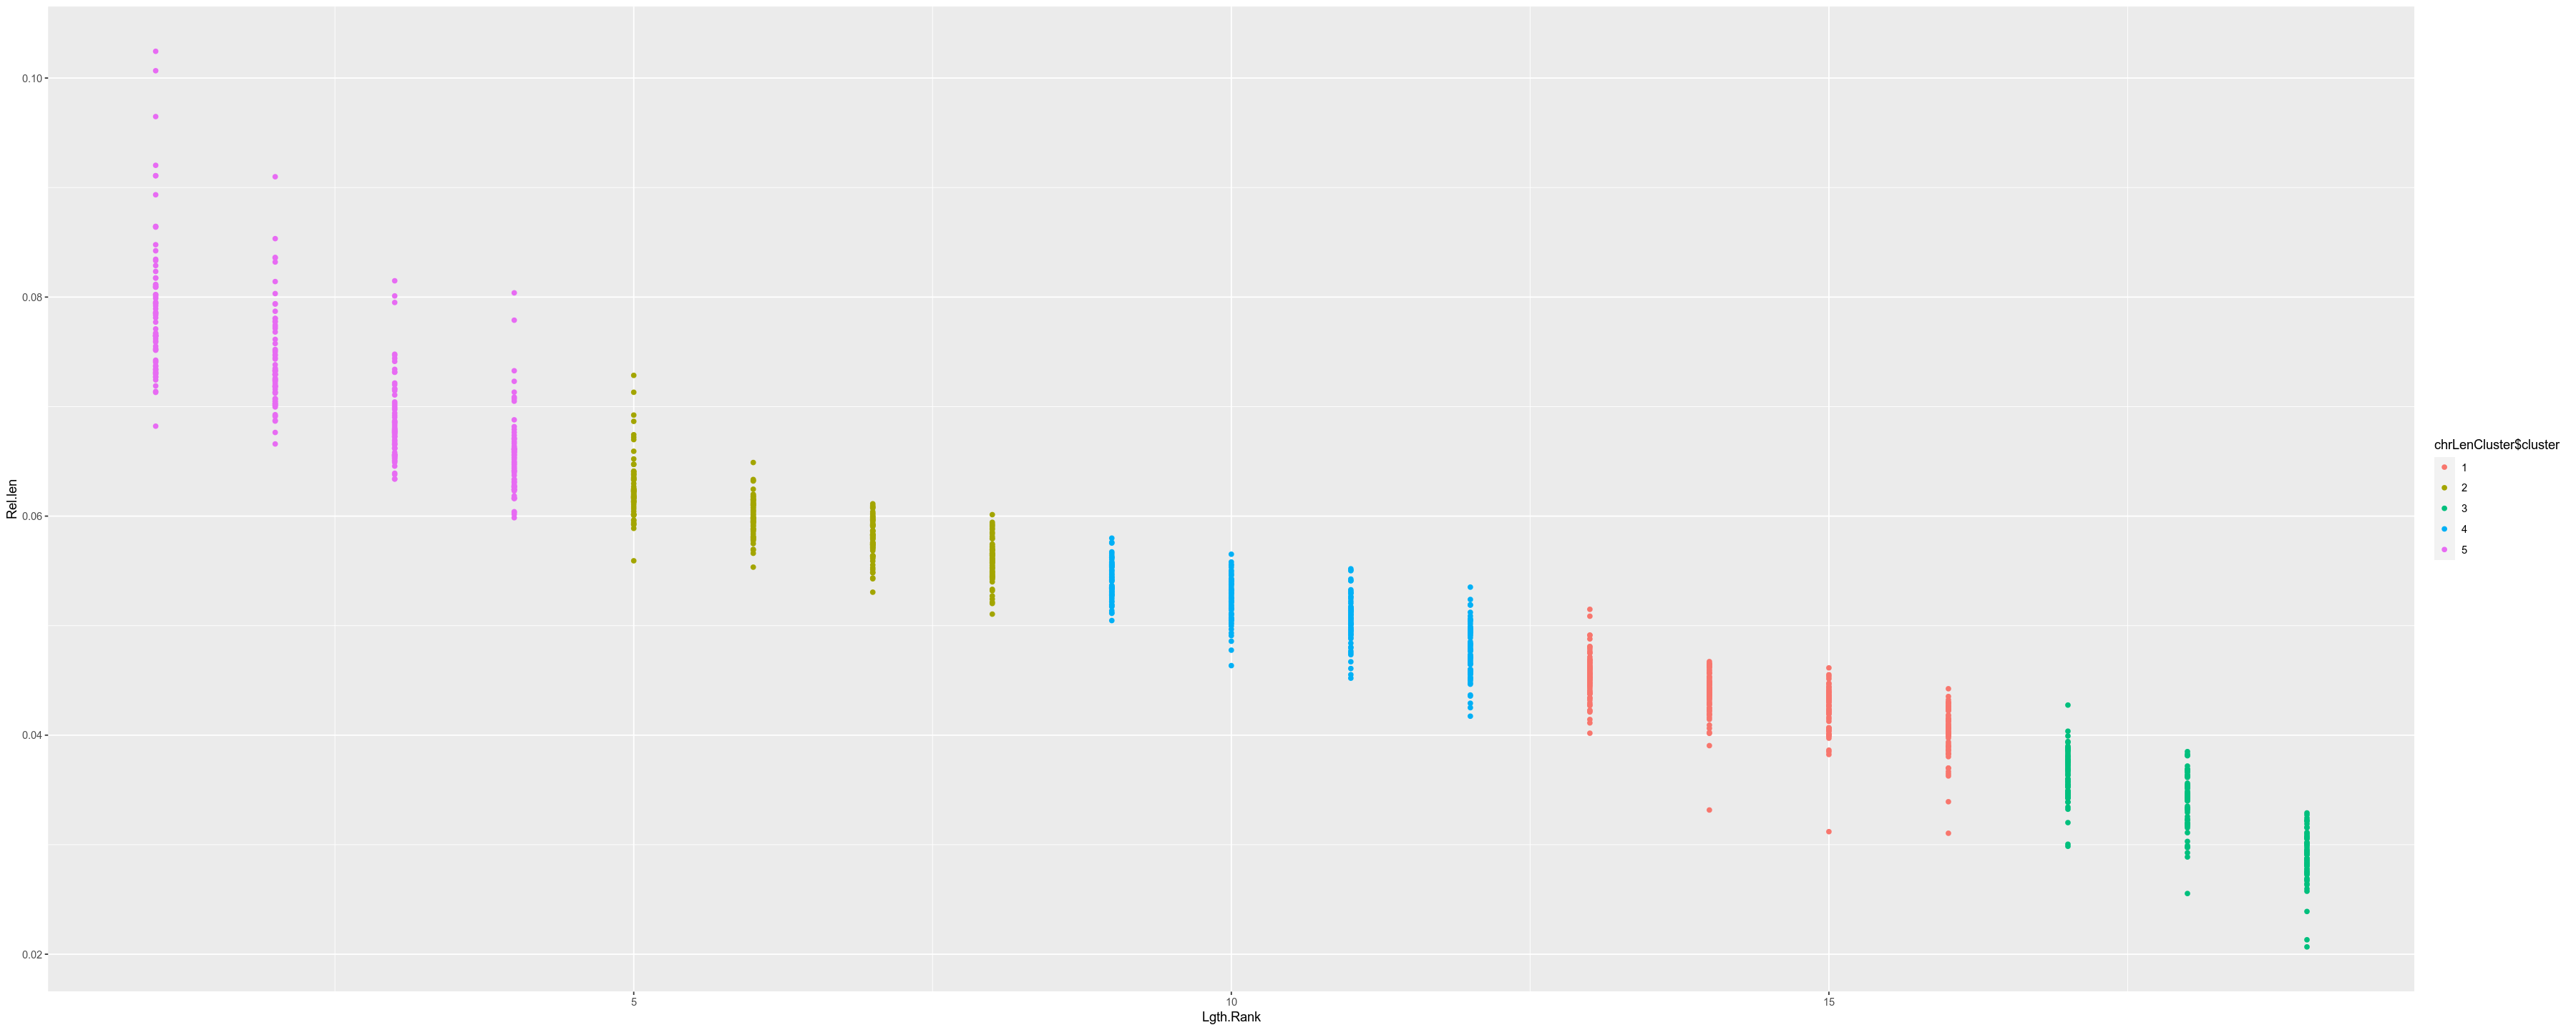

In [28]:
# Based on relative lenght
data_new <- rescale_df[, c("Lgth.Rank", "RelLen_scal")]
head(data_new)

library(ggplot2)

nclusters = 5

set.seed(20)
chrLenCluster <- kmeans(data_new, nclusters, nstart = 20)
chrLenCluster

table(chrLenCluster$cluster, data$Lgth.Rank)


chrLenCluster$cluster <- as.factor(chrLenCluster$cluster)
ggplot(data, aes(Lgth.Rank, Rel.len, color = chrLenCluster$cluster)) + geom_point()

K-means clustering with 5 clusters of sizes 225, 288, 279, 288, 288

Cluster means:
  Lgth.Rank   Len_scal
1  2.080000  1.2660384
2 13.500000 -0.4523349
3  5.548387  0.4610378
4  9.500000  0.0384714
5 17.500000 -1.0218593

Clustering vector:
   [1] 1 1 1 3 3 3 3 4 4 2 4 2 4 2 5 5 2 5 5 1 1 3 3 1 4 3 4 4 4 3 2 2 2 5 5 2 5
  [38] 5 3 1 3 1 4 4 3 4 4 1 3 2 2 2 5 5 2 5 5 1 1 3 3 1 4 3 4 4 4 3 2 2 2 2 5 5
  [75] 5 5 1 1 1 3 1 4 3 4 2 4 3 2 4 2 5 5 2 5 5 1 1 3 3 3 3 1 4 4 4 4 2 2 5 2 5
 [112] 2 5 5 1 1 3 3 3 2 4 4 4 3 1 2 2 4 2 5 5 5 5 1 1 4 3 1 3 3 2 4 4 3 2 2 4 5
 [149] 5 2 5 5 1 1 3 4 1 3 3 4 4 3 4 5 2 2 2 5 2 5 5 1 1 3 3 1 4 3 4 4 4 3 2 2 2
 [186] 2 5 5 5 5 1 1 3 3 1 4 3 4 4 4 1 2 2 2 2 5 5 5 5 1 1 4 1 3 3 3 4 4 4 3 2 2
 [223] 2 2 5 5 5 5 1 1 4 3 3 4 1 4 3 4 3 2 2 2 5 5 2 5 5 1 1 3 3 1 4 3 4 3 4 4 2
 [260] 2 2 5 5 2 5 5 1 1 3 3 1 4 3 4 4 4 3 2 2 2 2 5 5 5 5 1 1 4 3 1 3 3 4 4 4 3
 [297] 2 2 2 5 5 2 5 5 1 1 4 3 1 4 3 4 3 5 3 2 2 2 2 5 5 4 5 1 1 3 1 3 4 3 4 4 4
 [334] 3 2 2 2 2 5 5 5 5 1 1 

   
     1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  1 72 72 72  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  2  0  0  0  0  0  0  0  0  0  0  0 72 72 72 72  0  0  0  0
  3  0  0  0 63 72 72 72  0  0  0  0  0  0  0  0  0  0  0  0
  4  0  0  0  0  0  0  0 72 72 72 72  0  0  0  0  0  0  0  0
  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 72 72 72 72

[1] 1368

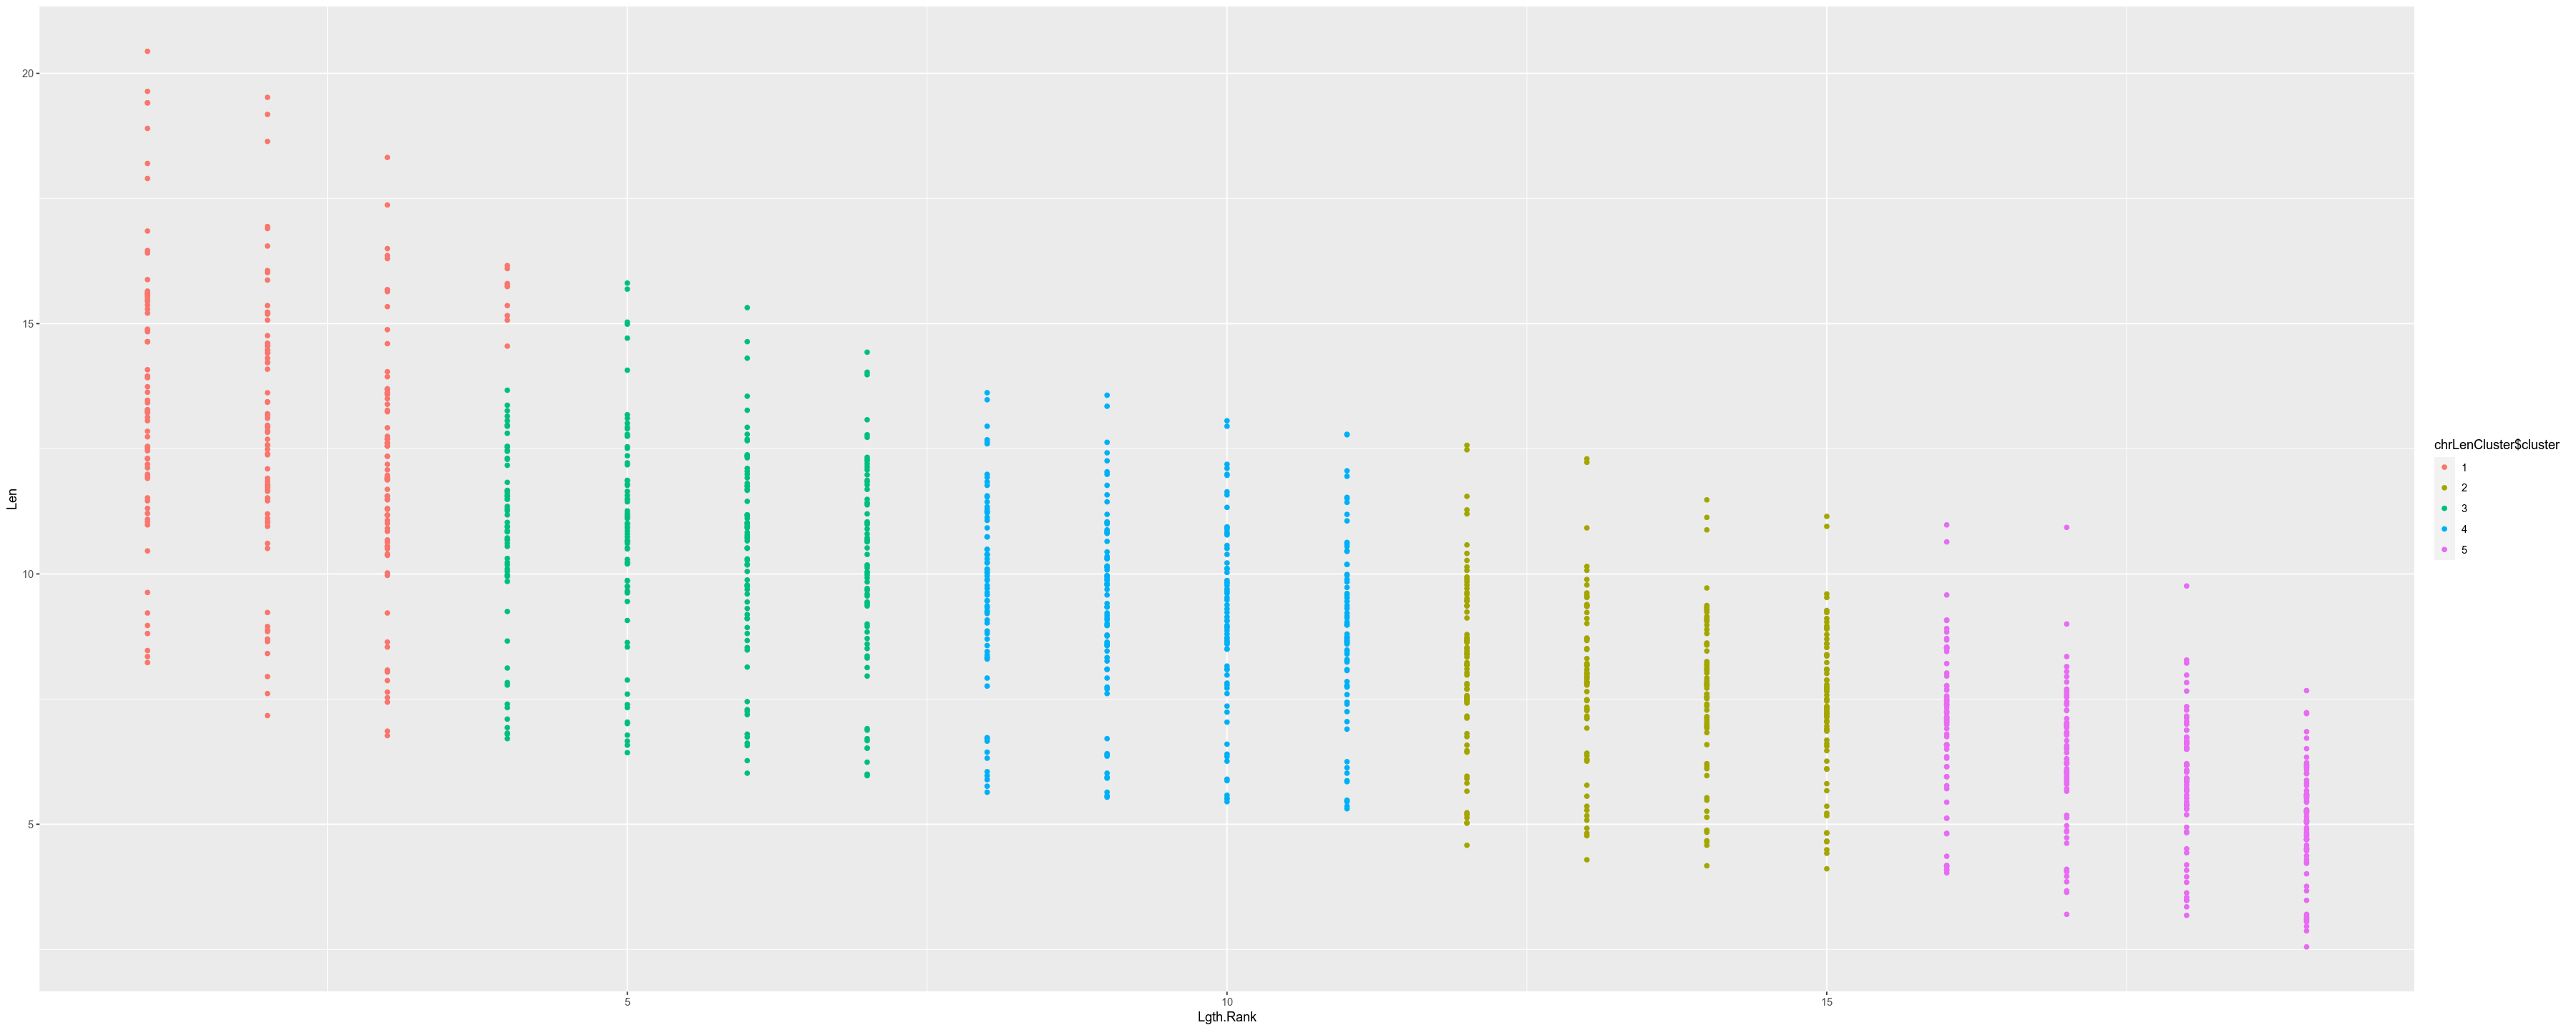

In [29]:
# Same, but for absolute lengh
#head(data)

data_new <- rescale_df[, c("Lgth.Rank", "Len_scal")]
#head(data_new)

library(ggplot2)

nclusters = 5

set.seed(20)
chrLenCluster <- kmeans(data_new, nclusters, nstart = 20)
chrLenCluster

table(chrLenCluster$cluster, data$Lgth.Rank)

length(chrLenCluster$cluster)
chrLenCluster$cluster <- as.factor(chrLenCluster$cluster)
ggplot(data, aes(Lgth.Rank, Len, color = chrLenCluster$cluster)) + geom_point()

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match Rank.predicted.Ignasi Rank.real Rank_interval.Match
1 FALSE      1                     1          TRUE              
2 FALSE      1                     1          TRUE              
3  TRUE      2                     2          TRUE              
4 FALSE      2                     3         FALSE              
5  TRUE      2                     2          TRUE              
6 FALSE      3                     3          TRUE

Group.1 x         
1   1      0.07343736
2   2      0.07602749
3   3      0.05760970
4   4      0.06403823
5   5      0.06726448
6   6      0.05437383
7   7      0.06318861
8   8      0.05406925
9   9      0.05481595
10 10      0.05299165
11 11      0.06186476
12 12      0.04620980
13 13      0.04470865
14 14      0.04483018
15 15      0.04218584
16 16      0.03582912
17 17      0.04258188
18 18      0.03507235
19 19      0.02890088

K-means clustering with 5 clusters of sizes 4, 3, 5, 5, 2

Cluster means:
           x
1 0.06408902
2 0.03326745
3 0.05477207
4 0.04410327
5 0.07473242

Clustering vector:
 [1] 5 5 3 1 1 3 1 3 3 3 1 4 4 4 4 2 4 2 2

Within cluster sum of squares by cluster:
[1] 1.584416e-05 2.888673e-05 1.187652e-05 1.132350e-05 3.354381e-06
 (between_SS / total_SS =  97.7 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

   
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  1 0 0 0 1 1 0 1 0 0  0  1  0  0  0  0  0  0  0  0
  2 0 0 0 0 0 0 0 0 0  0  0  0  0  0  0  1  0  1  1
  3 0 0 1 0 0 1 0 1 1  1  0  0  0  0  0  0  0  0  0
  4 0 0 0 0 0 0 0 0 0  0  0  1  1  1  1  0  1  0  0
  5 1 1 0 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0

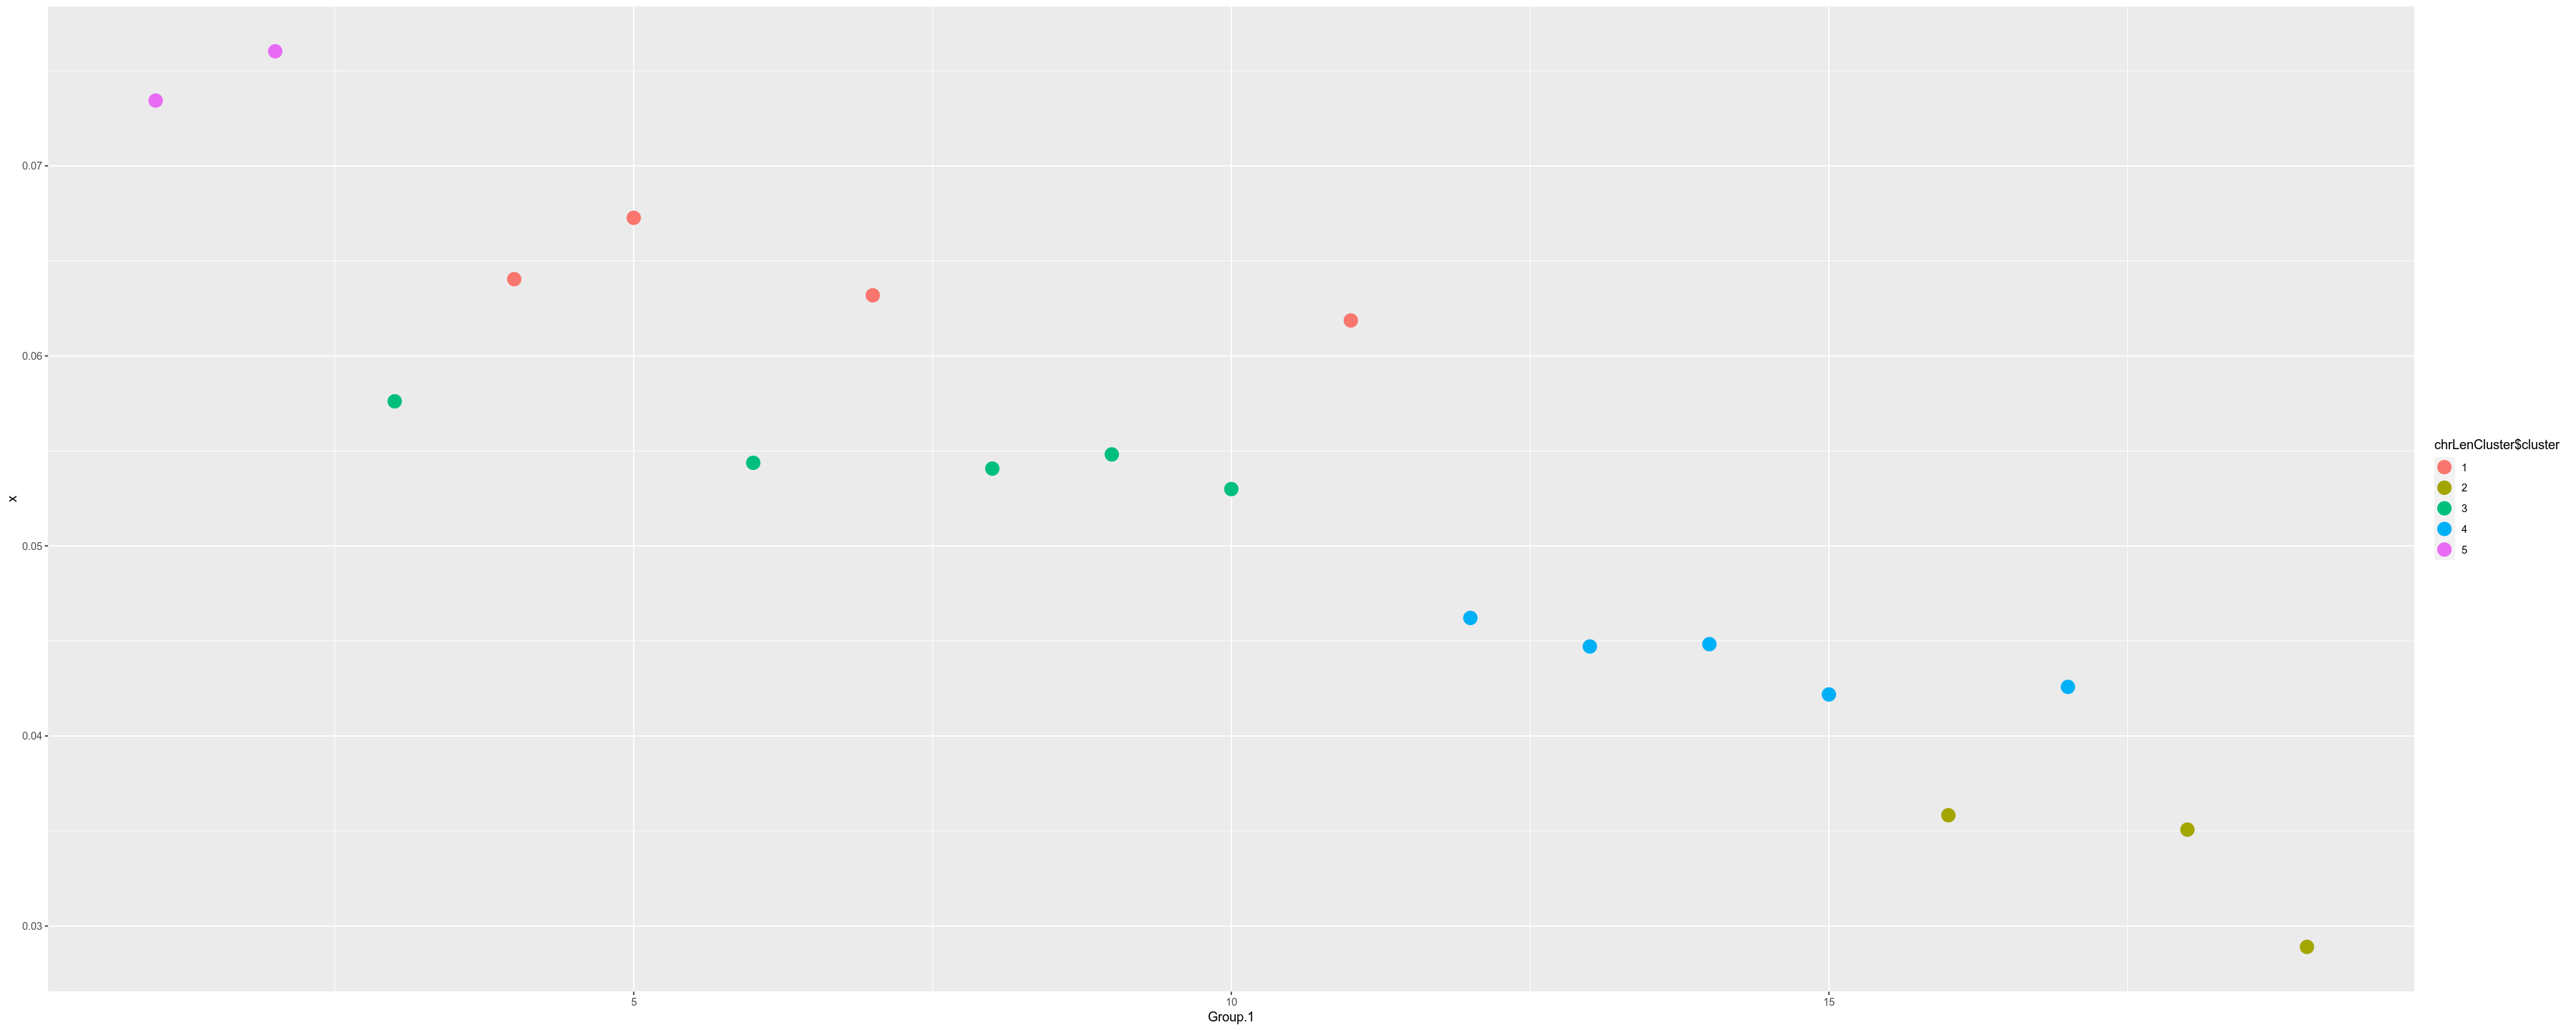

In [30]:
# Means of the Lenght of each ranked chromosome

head(data)
data_summary <- aggregate(data$Rel.len, list(data$FITC.Rank), FUN=mean) 
data_summary


library(ggplot2)

nclusters <- 5

set.seed(20)
chrLenCluster <- kmeans(data_summary["x"], nclusters, nstart = 20)
chrLenCluster

table(chrLenCluster$cluster, data_summary$Group.1)


chrLenCluster$cluster <- as.factor(chrLenCluster$cluster)
ggplot(data_summary, aes(Group.1, x, color = chrLenCluster$cluster)) + geom_point(size=5)

## Chromosome clustering by relative length

### Preparing table (data_chr):

cols: chromosomes

rows: cells

The values are all relative lenghts.

In [50]:
head(data)

remove(data_chr)

data_chr <- data.frame(matrix(ncol = 0, nrow = 72)) # New dataframe with 0 columns and 72 rows
data_setid = data[data['FITC.Rank'] == 1, ]['Set.ID'] # Cell name for each row

rownames(data_chr) <- data_setid$Set.ID # Set cell names as row names

#head(data_chr)


for(i in 1:max(data['FITC.Rank'])){
   data_chri <- data[data['FITC.Rank'] == i, ]['Rel.len'] # dataframe for just chromosome i and Relative lenght
   head(data_chri)
   colname <- paste("chr",  "_", i, sep="")
   colnames(data_chri) <- c(colname)
   data_chr <- cbind(data_chr, Chr1 = data_chri)
}

head(data_chr)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match Rank.predicted.Ignasi Rank.real Rank_interval.Match
1 FALSE      1                     1          TRUE              
2 FALSE      1                     1          TRUE              
3  TRUE      2                     2          TRUE              
4 FALSE      2                     3         FALSE              
5  TRUE      2                     2          TRUE              
6 FALSE      3                     3          TRUE

chr_1      chr_2      chr_3      chr_4      chr_5     
m1-3 s4 nu          0.07181488 0.07332749 0.06686973 0.06120195 0.06388799
M1-5 s25 200% im nu 0.07423803 0.07289955 0.05797476 0.06600863 0.06776698
M1-5 s3             0.06616516 0.07177734 0.06025146 0.07648032 0.06013468
M1-5 s32 I im       0.07247781 0.07315966 0.06040350 0.05867513 0.06338719
m1-6 s11 I big im   0.06821410 0.06658921 0.06502067 0.06230622 0.06266721
m1-6 s13 I im       0.06926172 0.09107591 0.05660622 0.06515490 0.06171065
                    chr_6      chr_7      chr_8      chr_9      chr_10    
m1-3 s4 nu          0.05684487 0.06454571 0.05218385 0.05194977 0.04839435
M1-5 s25 200% im nu 0.05351623 0.06149446 0.05428805 0.05365397 0.05072373
M1-5 s3             0.05760277 0.06331358 0.04796924 0.05652113 0.06901942
M1-5 s32 I im       0.05813895 0.05922439 0.05304315 0.05379115 0.05509515
m1-6 s11 I big im   0.05663123 0.05947835 0.05430311 0.05086237 0.05639818
m1-6 s13 I im       0.05554052 0.06541675 0.05446307 0.05069808 0.05104729
                    chr_11     chr_12     chr_13     chr_14     chr_15    
m1-3 s4 nu          0.05638663 0.04560650 0.04840017 0.04514794 0.04294018
M1-5 s25 200% im nu 0.06230845 0.04909638 0.04690260 0.04621895 0.04060671
M1-5 s3             0.06139199 0.04530324 0.04443659 0.04367428 0.03697767
M1-5 s32 I im       0.05866392 0.04985432 0.04379789 0.04565418 0.04615515
m1-6 s11 I big im   0.05812957 0.05187380 0.05314977 0.04626517 0.04423950
m1-6 s13 I im       0.05279507 0.04516327 0.04460430 0.04239561 0.04358979
                    chr_16     chr_17     chr_18     chr_19    
m1-3 s4 nu          0.03885597 0.04529196 0.03684251 0.02950755
M1-5 s25 200% im nu 0.03460567 0.04400270 0.03439514 0.02929897
M1-5 s3             0.03677593 0.04206872 0.03198613 0.02815037
M1-5 s32 I im       0.03941744 0.04131270 0.03531170 0.03243662
m1-6 s11 I big im   0.03389015 0.04552246 0.03189697 0.03256195
m1-6 s13 I im       0.03724646 0.04644555 0.03518729 0.03159758

## Finding out the appropiate number of clusters

In [32]:
# transpose the data, since we want to group chromosomes, not cells
data_chr_transpose <- as.data.frame(t(as.matrix(data_chr))) 
head(data_chr_transpose)

m1-3 s4 nu M1-5 s25 200% im nu M1-5 s3    M1-5 s32 I im m1-6 s11 I big im
chr_1 0.07181488 0.07423803          0.06616516 0.07247781    0.06821410       
chr_2 0.07332749 0.07289955          0.07177734 0.07315966    0.06658921       
chr_3 0.06686973 0.05797476          0.06025146 0.06040350    0.06502067       
chr_4 0.06120195 0.06600863          0.07648032 0.05867513    0.06230622       
chr_5 0.06388799 0.06776698          0.06013468 0.06338719    0.06266721       
chr_6 0.05684487 0.05351623          0.05760277 0.05813895    0.05663123       
      m1-6 s13 I im m1-6 s14 I im m1-6 s15 I im corr m1-6 s18 I big im left
chr_1 0.06926172    0.06910275    0.07020489         0.07293312            
chr_2 0.09107591    0.07302975    0.07599537         0.07414206            
chr_3 0.05660622    0.05855709    0.05943591         0.05748871            
chr_4 0.06515490    0.06214521    0.06104691         0.05718657            
chr_5 0.06171065    0.06240982    0.06622637         0.06529225            
chr_6 0.05554052    0.05351671    0.06330382         0.06016536            
      m1-6 s18 I big im-right ⋯ m3-3 s26   m3-3 s28   m3-3 s31   m3-3 s32  
chr_1 0.07070936              ⋯ 0.07308402 0.06762872 0.07137805 0.07811411
chr_2 0.07243904              ⋯ 0.07297226 0.07619723 0.07065261 0.07258807
chr_3 0.05955204              ⋯ 0.05633274 0.05088306 0.05878843 0.06160697
chr_4 0.06033423              ⋯ 0.07042623 0.06379898 0.06247677 0.06470165
chr_5 0.06379692              ⋯ 0.06336385 0.06414078 0.06558084 0.07029196
chr_6 0.05605017              ⋯ 0.05378717 0.05787241 0.06778443 0.05411108
      m3-3 s34   m3-3 s37   m3-3 s38   m3-3 s4    m3-3 s5    m3-3 s8   
chr_1 0.07207745 0.07270626 0.06859766 0.06872517 0.07771221 0.08643069
chr_2 0.07514555 0.07225271 0.07372841 0.07130032 0.07729449 0.07188475
chr_3 0.05795584 0.05706016 0.07191406 0.05921083 0.06558197 0.05464649
chr_4 0.06316887 0.06998517 0.06014828 0.06582258 0.06178992 0.05987722
chr_5 0.06542715 0.06536404 0.06477363 0.06849884 0.06230284 0.06343320
chr_6 0.05493619 0.05413906 0.05536149 0.05745068 0.05355971 0.05407800

In [40]:
head(data)

remove(data_rank) # delete the old table in case we want to re-run the process

data_rank <- data.frame(matrix(ncol = 0, nrow = 72)) # New dataframe with 0 columns and 72 rows
data_setid = data[data['Lgth.Rank'] == 1, ]['Set.ID'] # Cell name for each row

rownames(data_rank) <- data_setid$Set.ID # Set cell names as row names

#head(data_chr)


for(i in 1:max(data['Lgth.Rank'])){
   data_chri <- data[data['Lgth.Rank'] == i, ]['Rel.len'] # dataframe for just chromosome i and Relative lenght
   head(data_chri)
   colname <- paste("rnk",  "_", i, sep="")
   colnames(data_chri) <- c(colname)
   data_rank <- cbind(data_rank, Chr1 = data_chri)
}


head(data_rank)

# transpose the data, since we want to group chromosomes, not cells
data_rank_transpose <- as.data.frame(t(as.matrix(data_rank))) 
head(data_rank_transpose)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1      
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1      
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1      
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2      
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1      
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1      
  Rank.Match Rank.predicted.Ignasi Rank.real Rank_interval.Match
1 FALSE      1                     1          TRUE              
2 FALSE      1                     1          TRUE              
3  TRUE      2                     2          TRUE              
4 FALSE      2                     3         FALSE              
5  TRUE      2                     2          TRUE              
6 FALSE      3                     3          TRUE

rnk_1      rnk_2      rnk_3      rnk_4      rnk_5     
m1-3 s4 nu          0.07332749 0.07181488 0.06686973 0.06454571 0.06388799
M1-5 s25 200% im nu 0.07423803 0.07289955 0.06776698 0.06600863 0.06230845
M1-5 s3             0.07648032 0.07177734 0.06901942 0.06616516 0.06331358
M1-5 s32 I im       0.07315966 0.07247781 0.06338719 0.06040350 0.05922439
m1-6 s11 I big im   0.06821410 0.06658921 0.06502067 0.06266721 0.06230622
m1-6 s13 I im       0.09107591 0.06926172 0.06541675 0.06515490 0.06171065
                    rnk_6      rnk_7      rnk_8      rnk_9      rnk_10    
m1-3 s4 nu          0.06120195 0.05684487 0.05638663 0.05218385 0.05194977
M1-5 s25 200% im nu 0.06149446 0.05797476 0.05428805 0.05365397 0.05351623
M1-5 s3             0.06139199 0.06025146 0.06013468 0.05760277 0.05652113
M1-5 s32 I im       0.05867513 0.05866392 0.05813895 0.05509515 0.05379115
m1-6 s11 I big im   0.05947835 0.05812957 0.05663123 0.05639818 0.05430311
m1-6 s13 I im       0.05660622 0.05554052 0.05446307 0.05279507 0.05104729
                    rnk_11     rnk_12     rnk_13     rnk_14     rnk_15    
m1-3 s4 nu          0.04840017 0.04839435 0.04560650 0.04529196 0.04514794
M1-5 s25 200% im nu 0.05072373 0.04909638 0.04690260 0.04621895 0.04400270
M1-5 s3             0.04796924 0.04530324 0.04443659 0.04367428 0.04206872
M1-5 s32 I im       0.05304315 0.04985432 0.04615515 0.04565418 0.04379789
m1-6 s11 I big im   0.05314977 0.05187380 0.05086237 0.04626517 0.04552246
m1-6 s13 I im       0.05069808 0.04644555 0.04516327 0.04460430 0.04358979
                    rnk_16     rnk_17     rnk_18     rnk_19    
m1-3 s4 nu          0.04294018 0.03885597 0.03684251 0.02950755
M1-5 s25 200% im nu 0.04060671 0.03460567 0.03439514 0.02929897
M1-5 s3             0.03697767 0.03677593 0.03198613 0.02815037
M1-5 s32 I im       0.04131270 0.03941744 0.03531170 0.03243662
m1-6 s11 I big im   0.04423950 0.03389015 0.03256195 0.03189697
m1-6 s13 I im       0.04239561 0.03724646 0.03518729 0.03159758

m1-3 s4 nu M1-5 s25 200% im nu M1-5 s3    M1-5 s32 I im m1-6 s11 I big im
rnk_1 0.07332749 0.07423803          0.07648032 0.07315966    0.06821410       
rnk_2 0.07181488 0.07289955          0.07177734 0.07247781    0.06658921       
rnk_3 0.06686973 0.06776698          0.06901942 0.06338719    0.06502067       
rnk_4 0.06454571 0.06600863          0.06616516 0.06040350    0.06266721       
rnk_5 0.06388799 0.06230845          0.06331358 0.05922439    0.06230622       
rnk_6 0.06120195 0.06149446          0.06139199 0.05867513    0.05947835       
      m1-6 s13 I im m1-6 s14 I im m1-6 s15 I im corr m1-6 s18 I big im left
rnk_1 0.09107591    0.07302975    0.07599537         0.07414206            
rnk_2 0.06926172    0.06910275    0.07020489         0.07293312            
rnk_3 0.06541675    0.06339218    0.06622637         0.06529225            
rnk_4 0.06515490    0.06240982    0.06610386         0.06016536            
rnk_5 0.06171065    0.06214521    0.06330382         0.06013736            
rnk_6 0.05660622    0.05885542    0.06104691         0.05748871            
      m1-6 s18 I big im-right ⋯ m3-3 s26   m3-3 s28   m3-3 s31   m3-3 s32  
rnk_1 0.07243904              ⋯ 0.07308402 0.07619723 0.07137805 0.07811411
rnk_2 0.07070936              ⋯ 0.07297226 0.07010068 0.07065261 0.07258807
rnk_3 0.06379692              ⋯ 0.07042623 0.06762872 0.06778443 0.07029196
rnk_4 0.06033423              ⋯ 0.06336385 0.06414078 0.06558084 0.06470165
rnk_5 0.06007399              ⋯ 0.06195132 0.06379898 0.06247677 0.06160697
rnk_6 0.05955204              ⋯ 0.05857631 0.05911540 0.06111016 0.06110092
      m3-3 s34   m3-3 s37   m3-3 s38   m3-3 s4    m3-3 s5    m3-3 s8   
rnk_1 0.07514555 0.07270626 0.07372841 0.07130032 0.07771221 0.08643069
rnk_2 0.07207745 0.07225271 0.07191406 0.06872517 0.07729449 0.07188475
rnk_3 0.06542715 0.06998517 0.06859766 0.06849884 0.06558197 0.06940563
rnk_4 0.06316887 0.06536404 0.06477363 0.06582258 0.06230284 0.06701133
rnk_5 0.06011926 0.05943335 0.06227223 0.06406208 0.06178992 0.06343320
rnk_6 0.05982334 0.05775858 0.06014828 0.05997983 0.05690265 0.06047187

In [43]:
# Install the required packages if necessary
#pkgs <- c("factoextra",  "NbClust") 
#install.packages(pkgs)

library(factoextra)
library(NbClust)

# Standardize the data
data_chr_transpose_scaled <- scale(data_chr_transpose)
head(data_chr_transpose_scaled)

m1-3 s4 nu M1-5 s25 200% im nu M1-5 s3   M1-5 s32 I im m1-6 s11 I big im
chr_1 1.5850728  1.67306670          0.9584992 1.7433980     1.3953117        
chr_2 1.7100559  1.56942287          1.3559754 1.8032953     1.2498135        
chr_3 1.1764658  0.41374235          0.5396692 0.6827263     1.1093616        
chr_4 0.7081504  1.03583359          1.6890582 0.5308978     0.8663003        
chr_5 0.9300914  1.17198949          0.5313981 0.9448295     0.8986244        
chr_6 0.3481347  0.06850193          0.3520788 0.4837970     0.3581427        
      m1-6 s13 I im m1-6 s14 I im m1-6 s15 I im corr m1-6 s18 I big im left
chr_1 1.1892863     1.37848768    1.3182749          1.7219460             
chr_2 2.7493048     1.70714217    1.7526523          1.8244872             
chr_3 0.2842421     0.49591168    0.5104323          0.4119749             
chr_4 0.8955915     0.79620472    0.6312822          0.3863473             
chr_5 0.6492798     0.81835002    1.0198238          1.0738594             
chr_6 0.2080296     0.07407742    0.8005862          0.6390038             
      m1-6 s18 I big im-right ⋯ m3-3 s26   m3-3 s28   m3-3 s31  m3-3 s32 
chr_1 1.5689463               ⋯ 1.65725625  1.1847776 1.4475181 1.9092925
chr_2 1.7190626               ⋯ 1.64820050  1.8616920 1.3915027 1.4952507
chr_3 0.6006170               ⋯ 0.29990399 -0.1381333 0.4754040 0.6724858
chr_4 0.6685026               ⋯ 1.44189652  0.8822273 0.7602010 0.9043566
chr_5 0.9690249               ⋯ 0.86963376  0.9092297 0.9998835 1.3232135
chr_6 0.2966945               ⋯ 0.09363691  0.4140267 1.1700346 0.1108521
      m3-3 s34  m3-3 s37  m3-3 s38  m3-3 s4   m3-3 s5    m3-3 s8   
chr_1 1.5788171 1.6317237 1.2206300 1.3077458 1.97871271 2.29527129
chr_2 1.8279172 1.5948582 1.6128832 1.5170001 1.94575719 1.30746816
chr_3 0.4322789 0.3599669 1.4741738 0.5346219 1.02170856 0.13683087
chr_4 0.8555261 1.4105461 0.5746629 1.0718847 0.72253842 0.49204570
chr_5 1.0388767 1.0349284 0.9282778 1.2893547 0.76300497 0.73352984
chr_6 0.1871120 0.1225325 0.2087055 0.3915941 0.07322412 0.09822504

Elbow Method

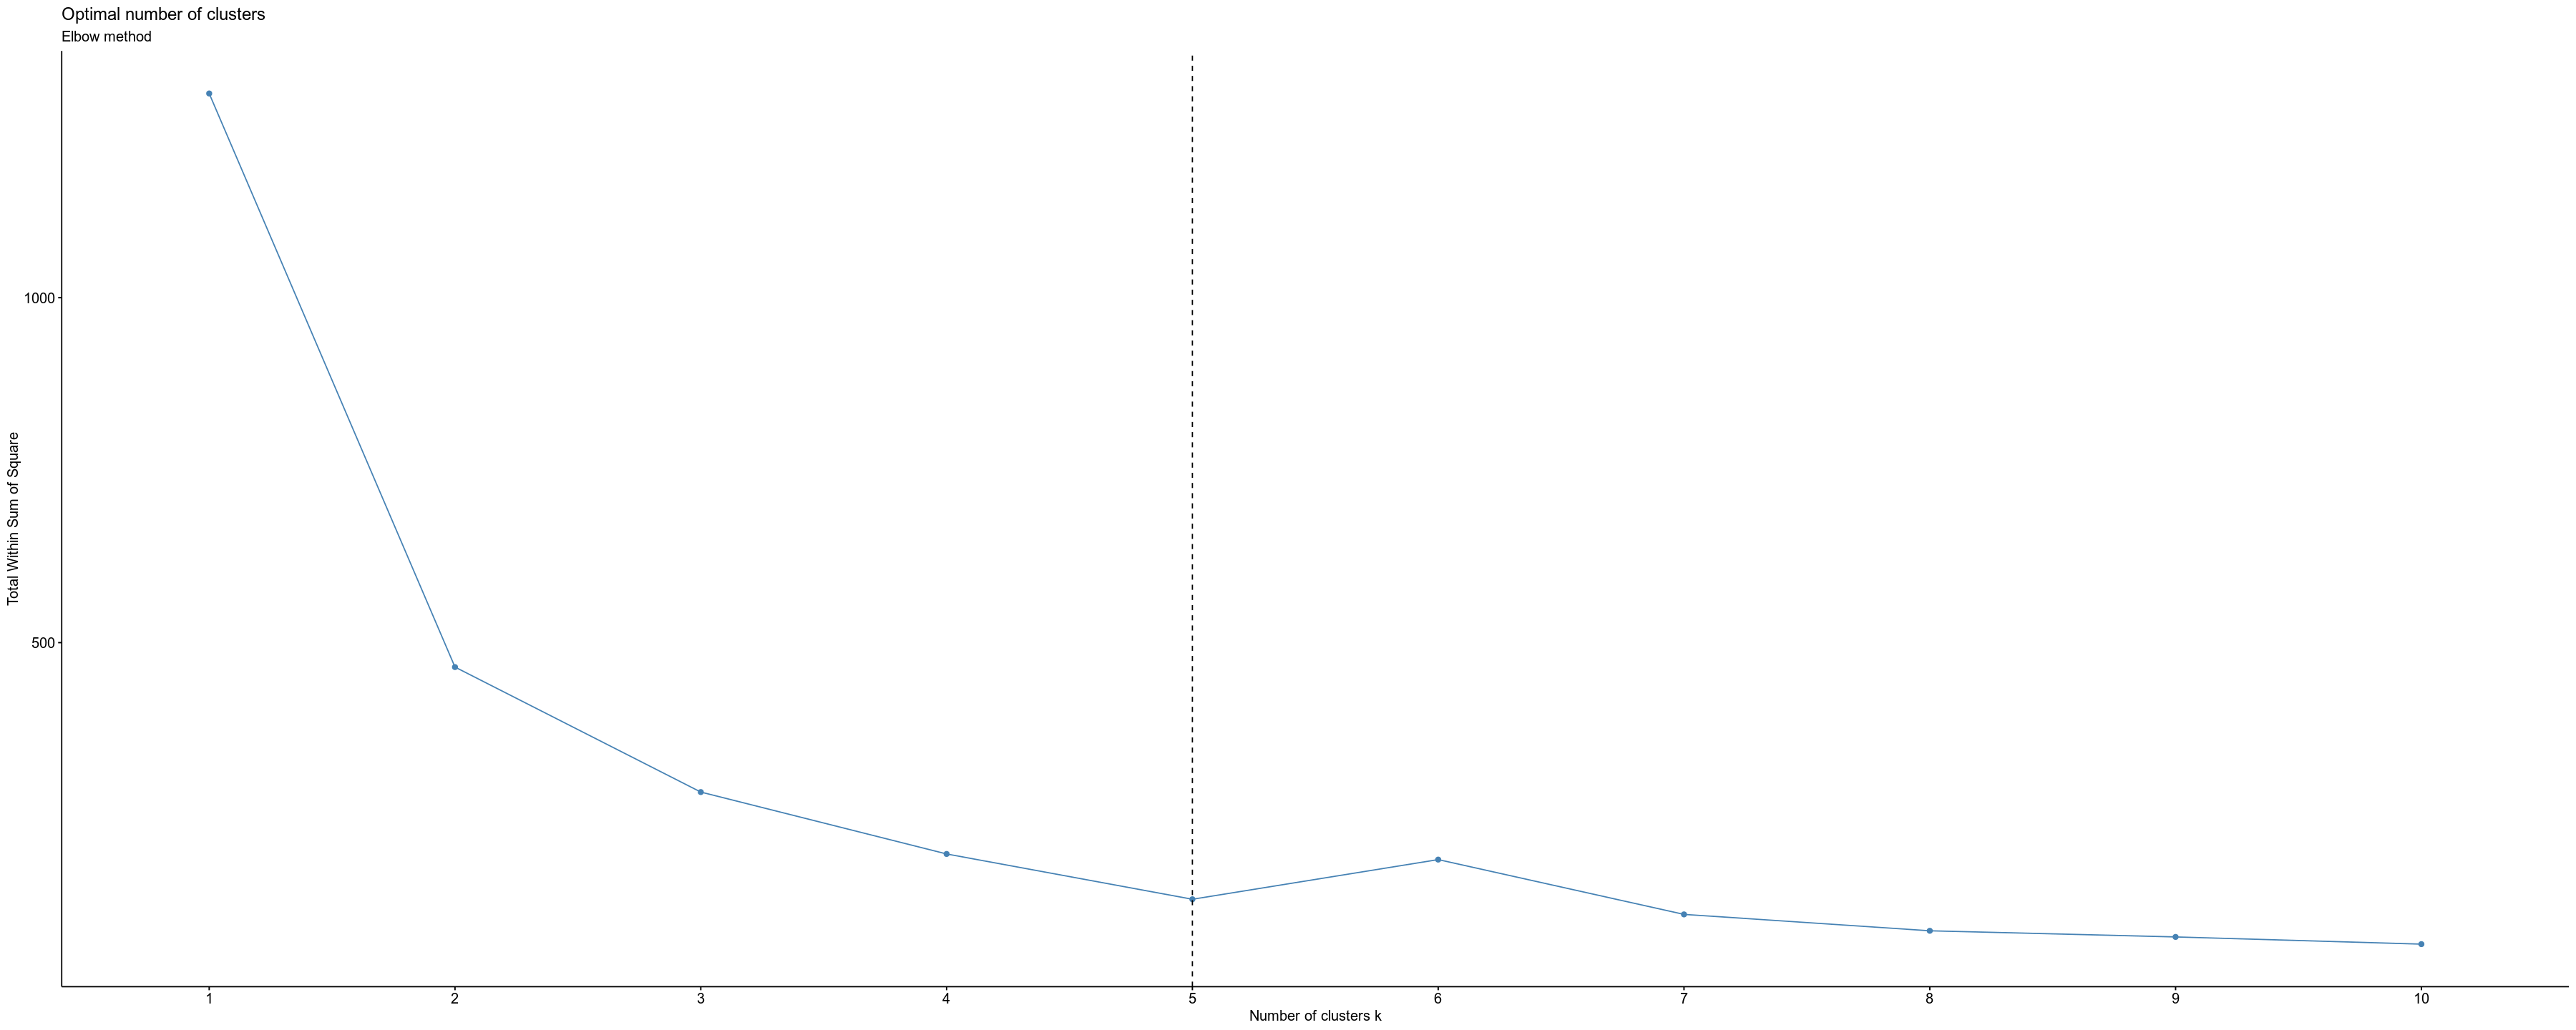

In [44]:
# Elbow method
fviz_nbclust(data_chr_transpose_scaled, kmeans, method = "wss") +
    geom_vline(xintercept = 5, linetype = 2)+
  labs(subtitle = "Elbow method")

Silhouette method

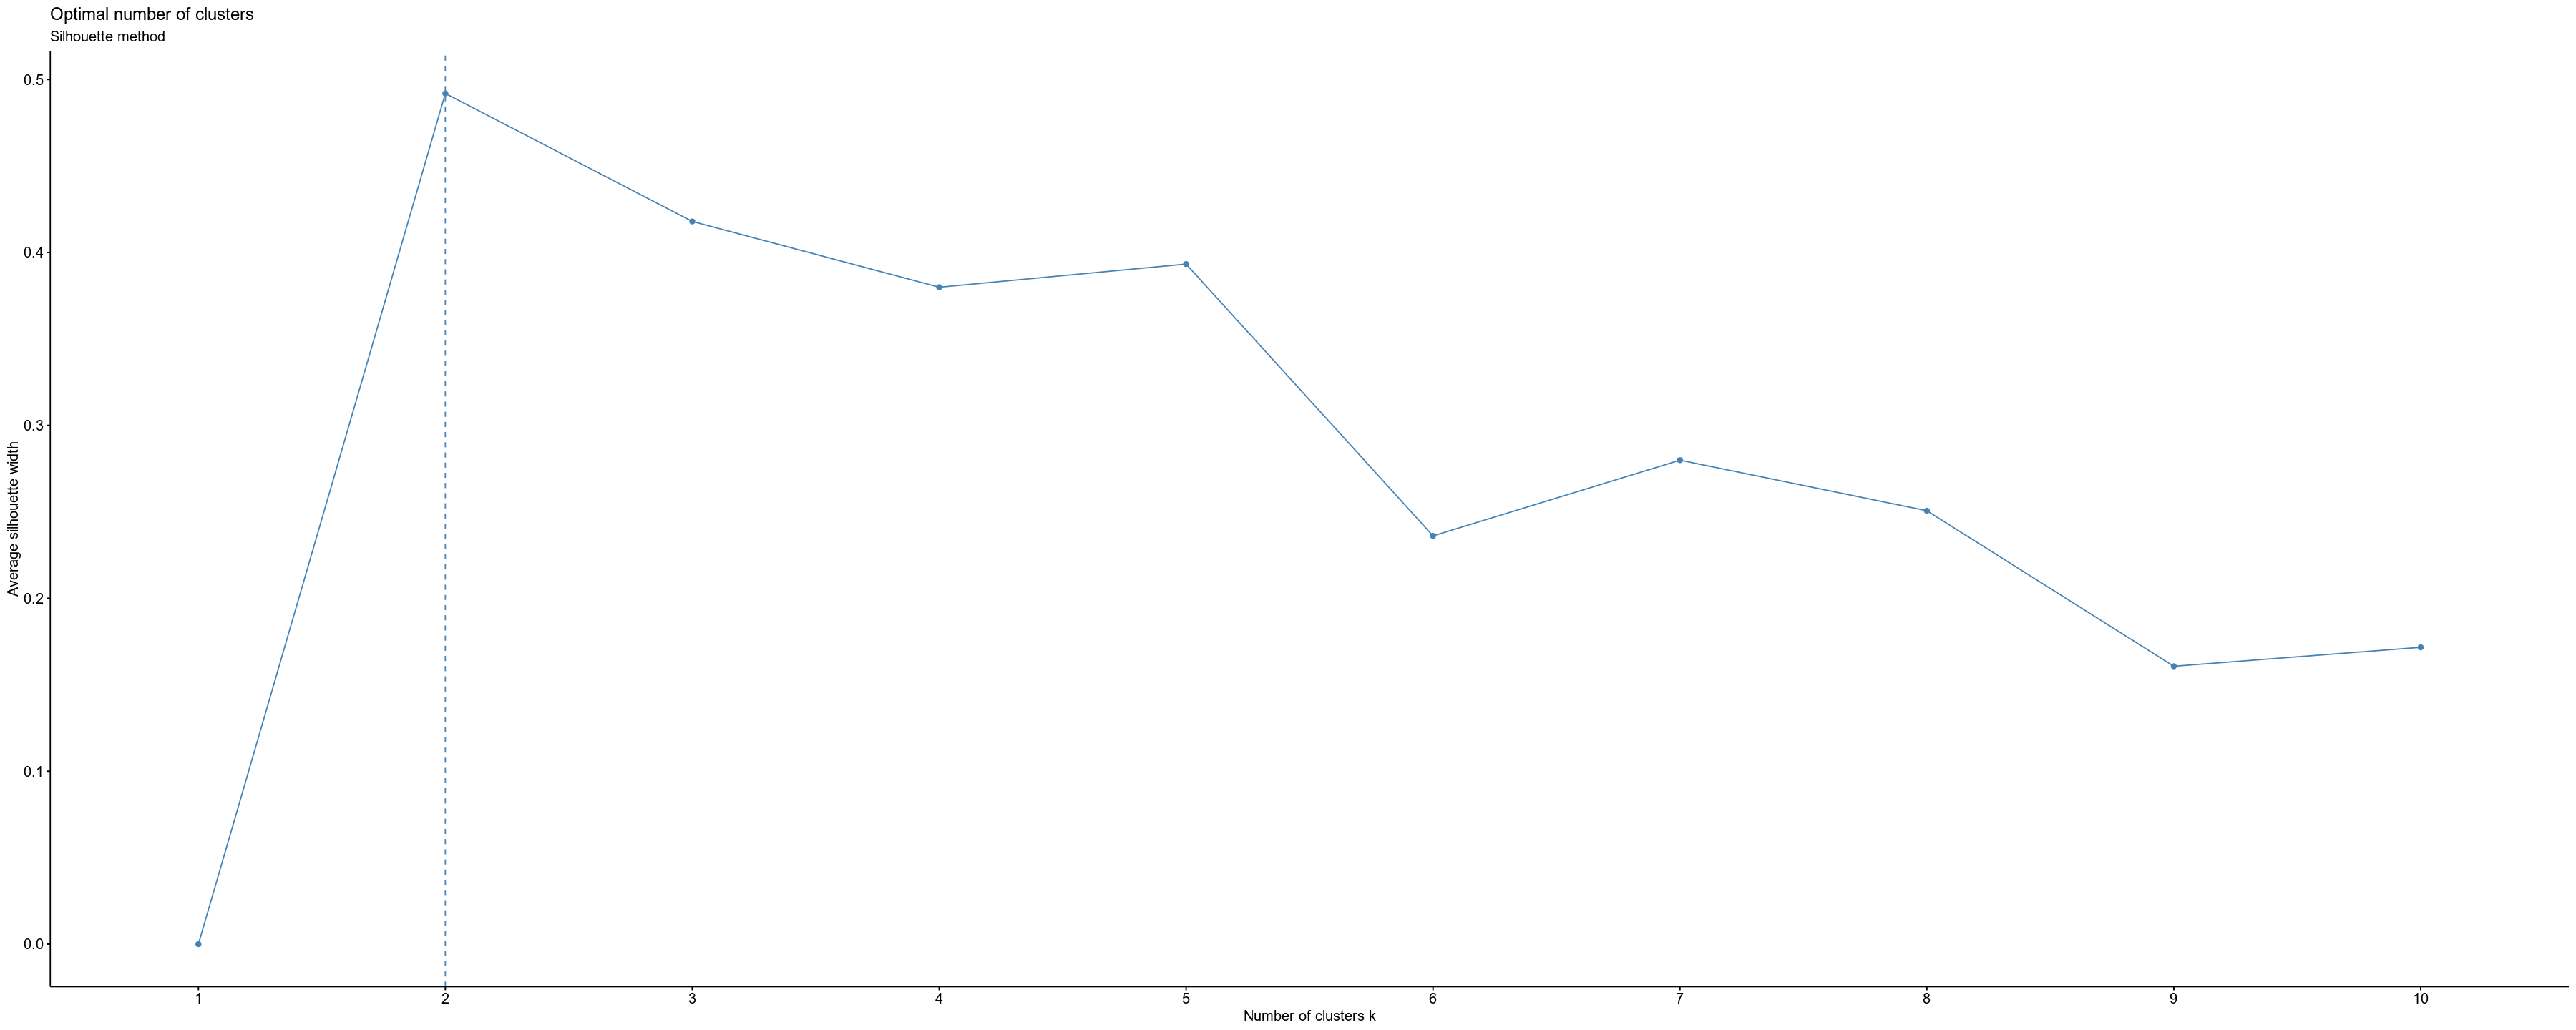

In [45]:
# Silhouette method
fviz_nbclust(data_chr_transpose_scaled, kmeans, method = "silhouette")+
  labs(subtitle = "Silhouette method")

Gap statistic

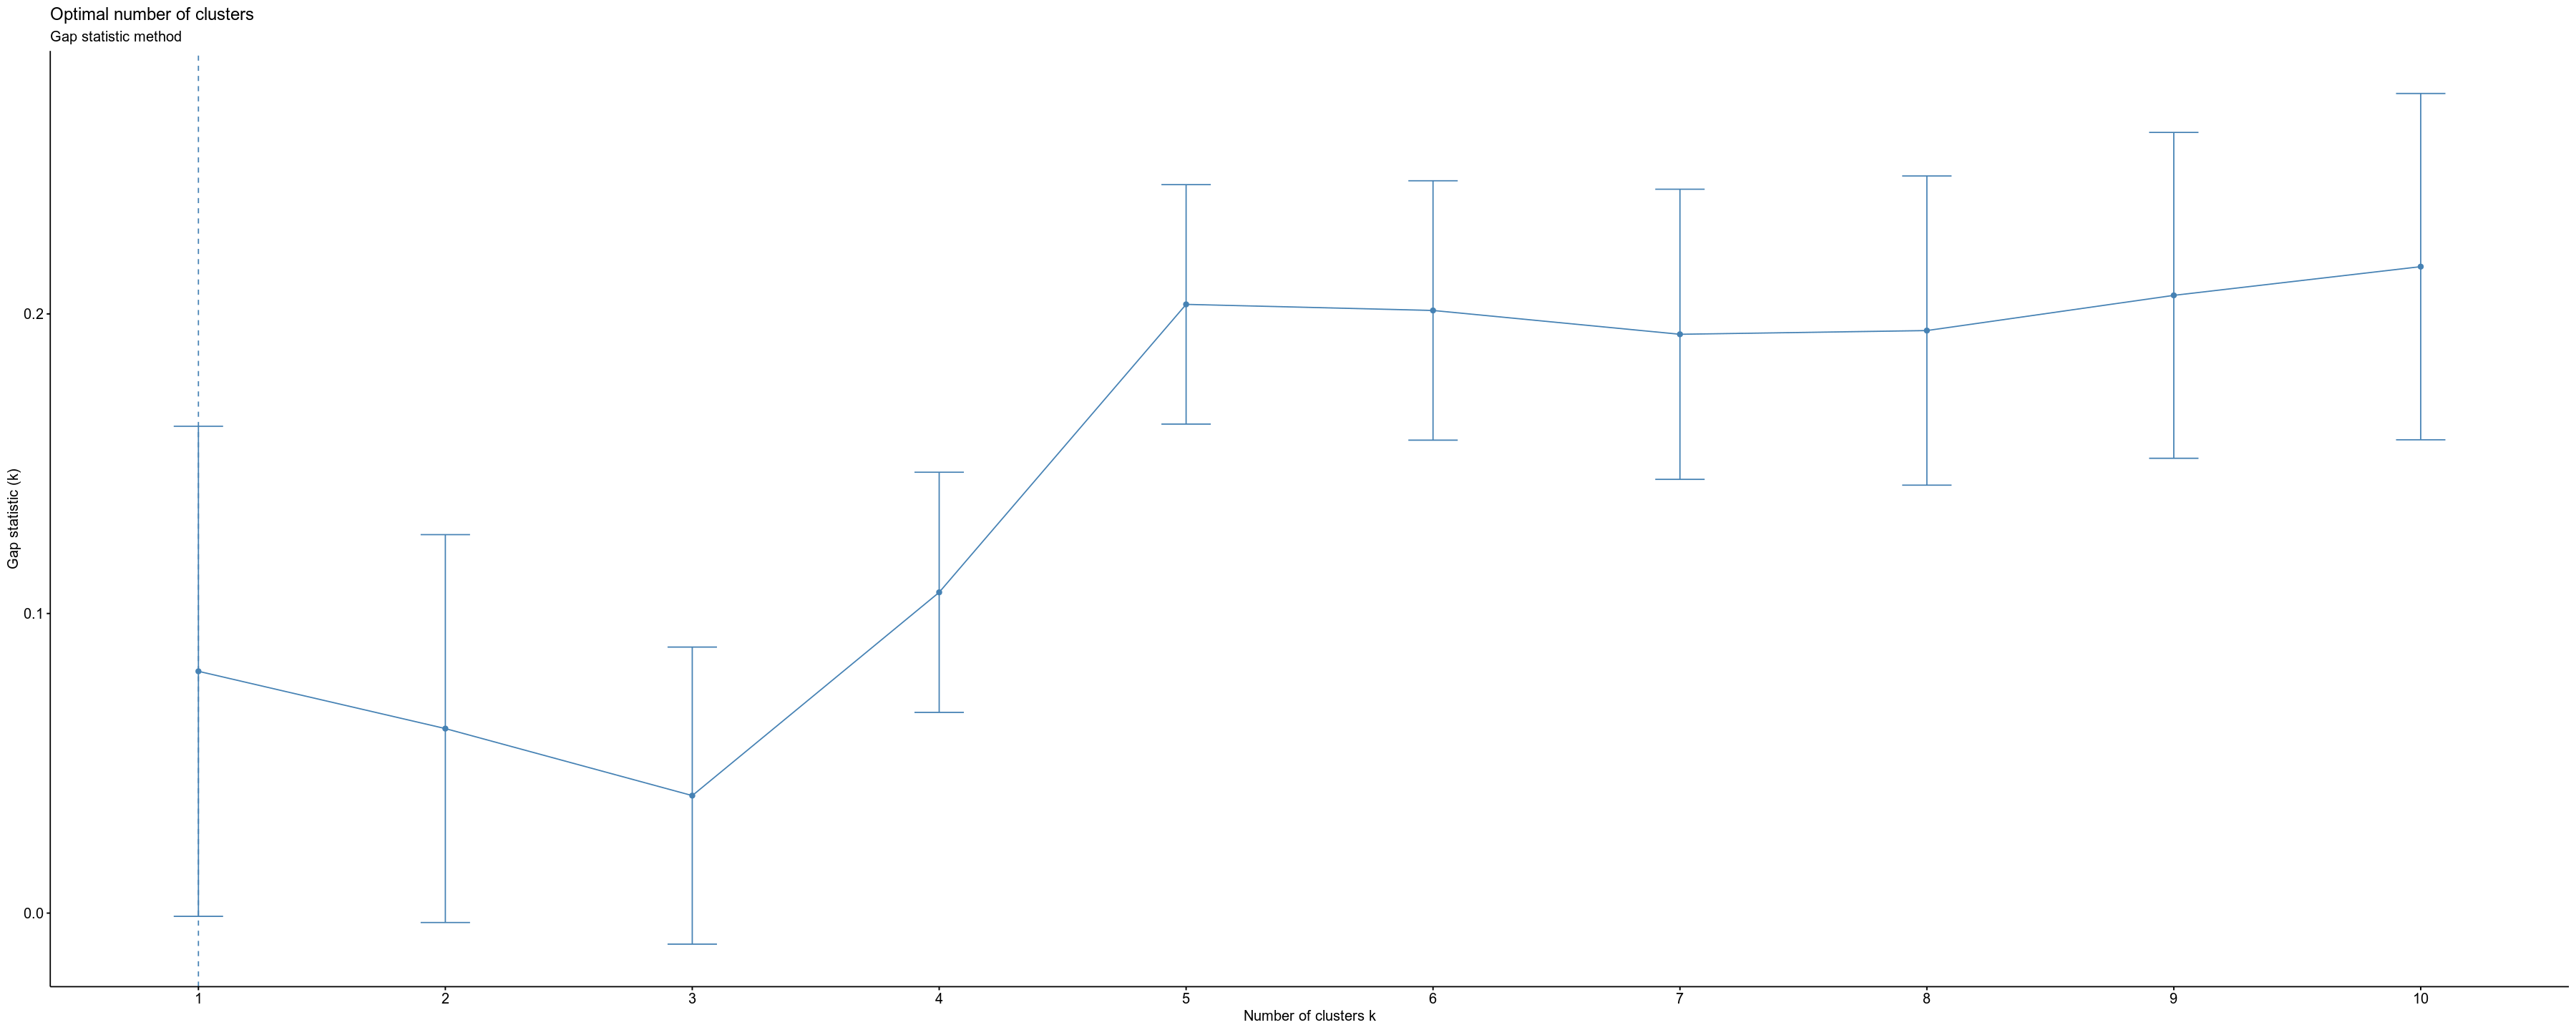

In [46]:
# Gap statistic
# nboot = 50 to keep the function speedy. 
# recommended value: nboot= 500 for your analysis.
# Use verbose = FALSE to hide computing progression.
set.seed(123)
fviz_nbclust(data_chr_transpose_scaled, kmeans, nstart = 25,  method = "gap_stat", nboot = 50)+
  labs(subtitle = "Gap statistic method")

## K-means based on 5 clusters

In [47]:
nclusters <- 5

set.seed(20)
chrLenCluster <- kmeans(data_chr_transpose, nclusters, nstart = 20)
chrLenCluster

#length(chrLenCluster$cluster)
#rownames(data_chr_transpose)
table(chrLenCluster$cluster, rownames(data_chr_transpose))

K-means clustering with 5 clusters of sizes 5, 5, 4, 2, 3

Cluster means:
  m1-3 s4 nu M1-5 s25 200% im nu    M1-5 s3 M1-5 s32 I im m1-6 s11 I big im
1 0.04547735          0.04536547 0.04249210    0.04535485        0.04821014
2 0.05524851          0.05403135 0.05827281    0.05609438        0.05664311
3 0.06150557          0.06439463 0.06533014    0.05998766        0.06064534
4 0.07257118          0.07356879 0.06897125    0.07281874        0.06740165
5 0.03506868          0.03276660 0.03230414    0.03572192        0.03278302
  m1-6 s13 I im m1-6 s14 I im m1-6 s15 I im corr m1-6 s18 I big im left
1    0.04443970    0.04578201         0.04542340             0.04485848
2    0.05367104    0.05650819         0.05511655             0.05722327
3    0.06126934    0.06088243         0.06352480             0.05945175
4    0.08016881    0.07106625         0.07310013             0.07353759
5    0.03467711    0.03429560         0.03233360             0.03490301
  m1-6 s18 I big im-right m1-6 s20 I b

   
    chr_1 chr_10 chr_11 chr_12 chr_13 chr_14 chr_15 chr_16 chr_17 chr_18 chr_19
  1     0      0      0      1      1      1      1      0      1      0      0
  2     0      1      0      0      0      0      0      0      0      0      0
  3     0      0      1      0      0      0      0      0      0      0      0
  4     1      0      0      0      0      0      0      0      0      0      0
  5     0      0      0      0      0      0      0      1      0      1      1
   
    chr_2 chr_3 chr_4 chr_5 chr_6 chr_7 chr_8 chr_9
  1     0     0     0     0     0     0     0     0
  2     0     1     0     0     1     0     1     1
  3     0     0     1     1     0     1     0     0
  4     1     0     0     0     0     0     0     0
  5     0     0     0     0     0     0     0     0

### Heatmap

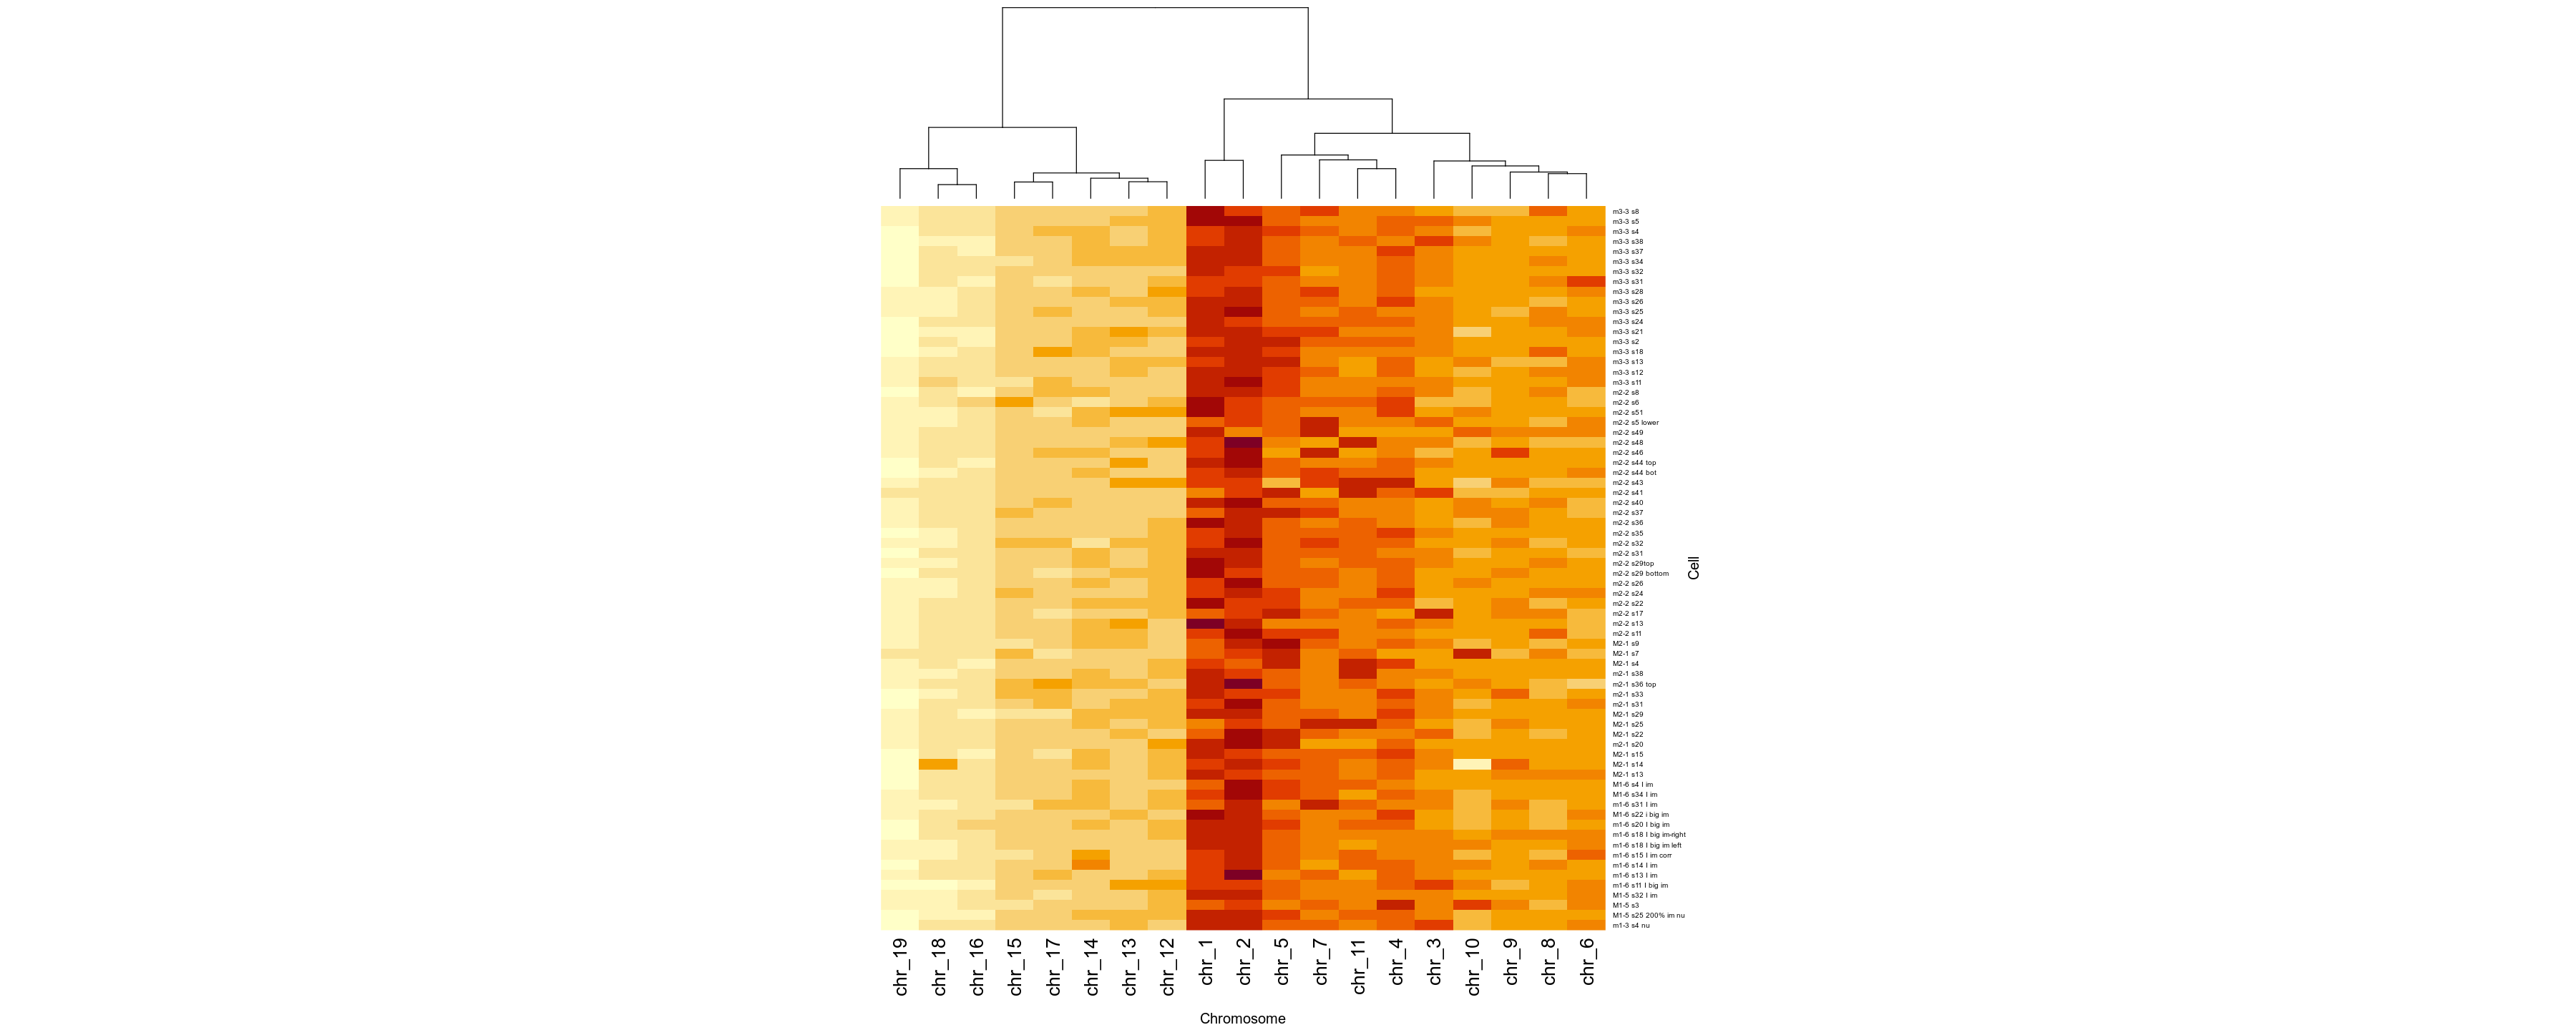

In [51]:
heatmap(as.matrix(data_chr), Rowv = NA, cexRow = 0.6, cexCol = 1.6, margins = c(7, 7), xlab = "Chromosome", ylab = "Cell")
#heatmap(as.matrix(corr), Colv = NA, Rowv = NA)

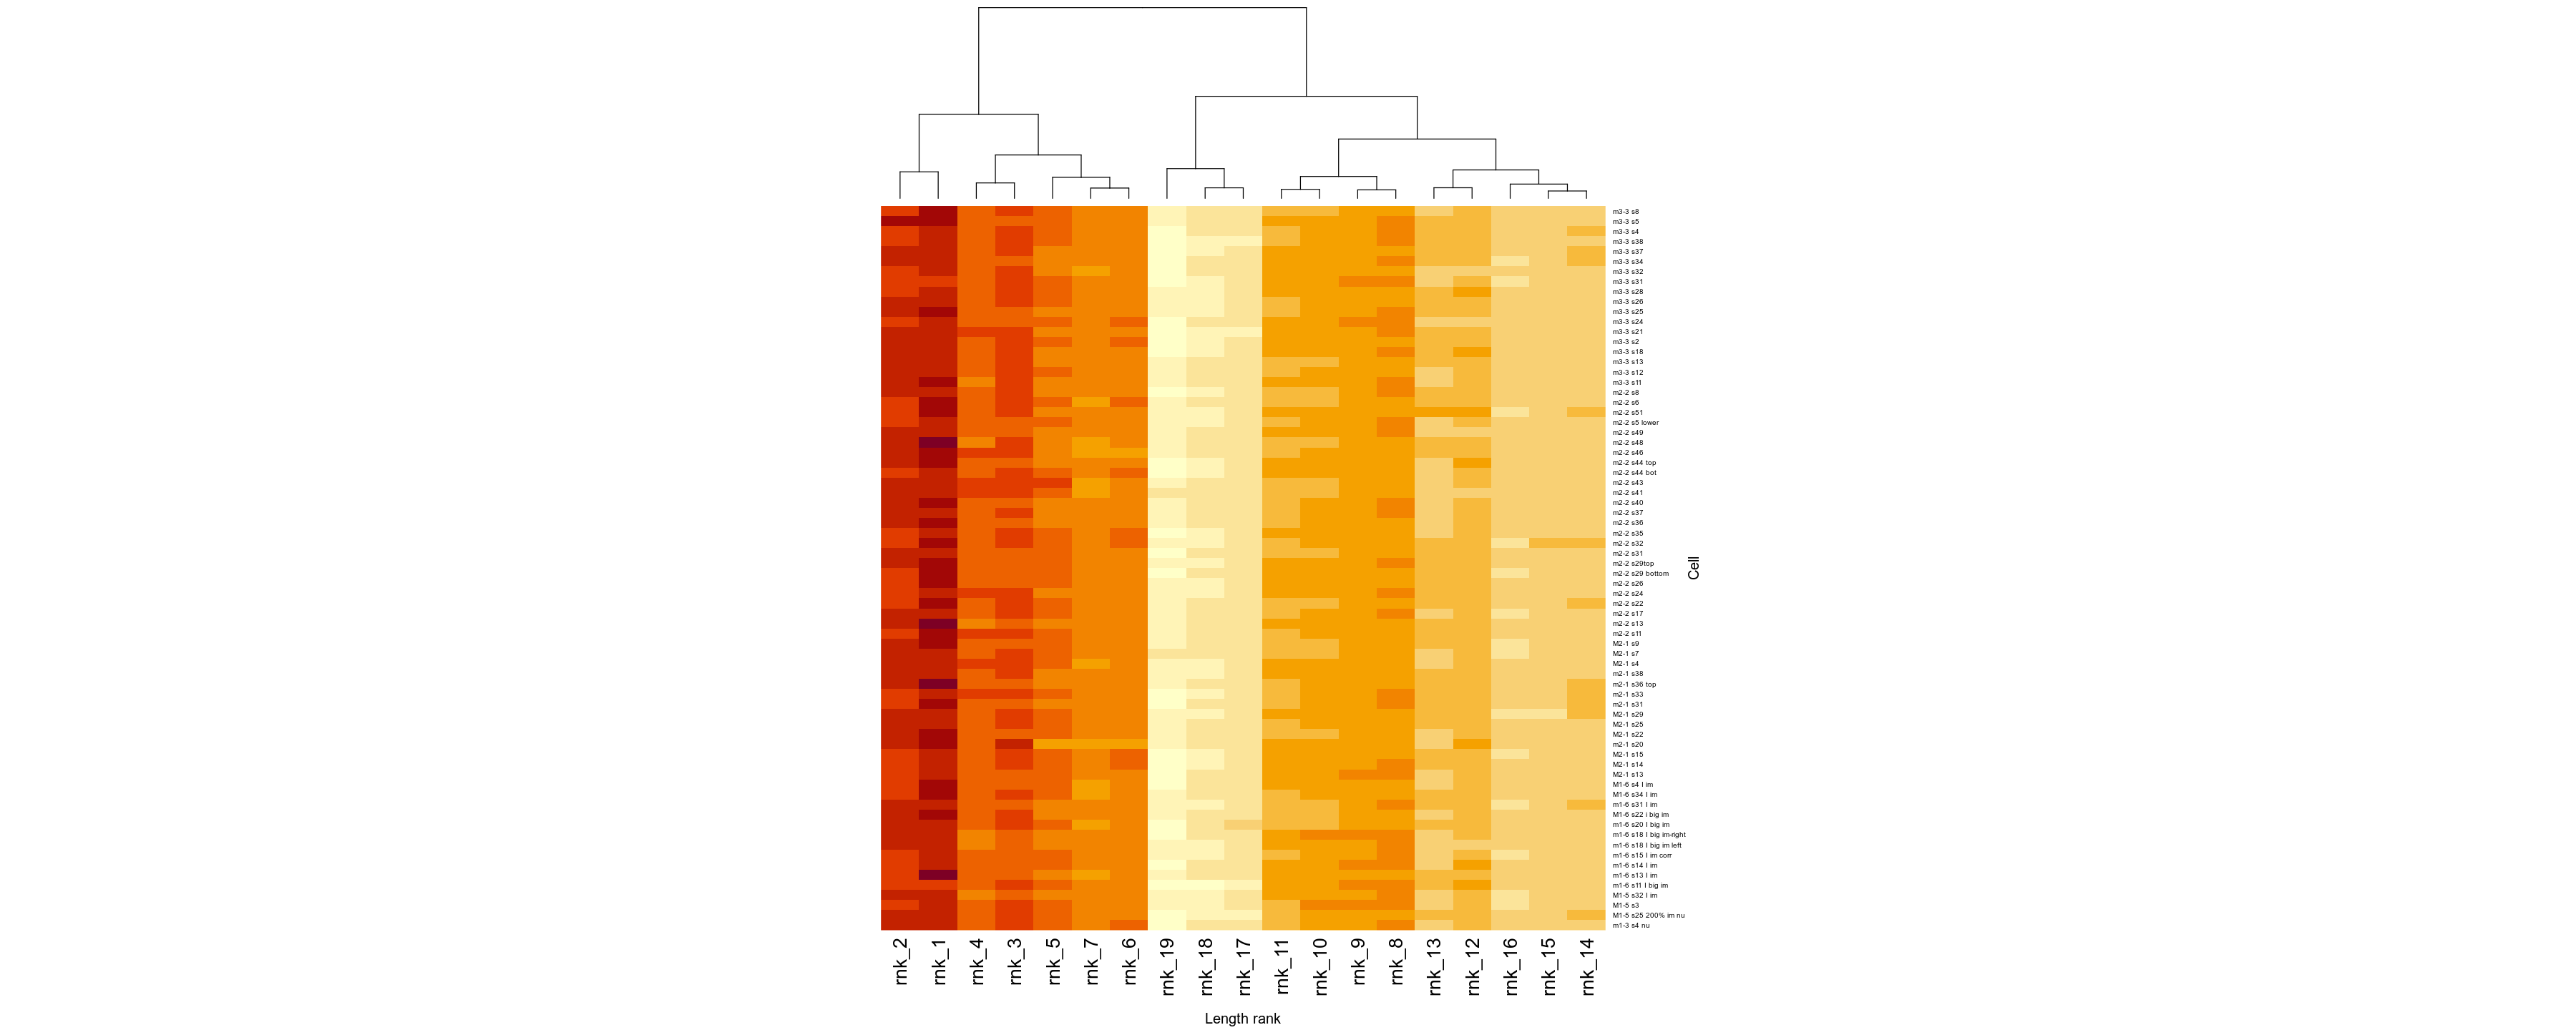

In [52]:
# Second hitmap, but with rank instead of chromosome number
heatmap(as.matrix(data_rank), Rowv = NA, cexRow = 0.6, cexCol = 1.6, margins = c(7, 7), xlab = "Length rank", ylab = "Cell")
#heatmap(as.matrix(corr), Colv = NA, Rowv = NA)

Correlation table

In [ ]:
#install.packages("Hmisc") # necessary for rcorr
#rcorr(x, type = c("pearson","spearman"))

corr <- cor(data_chr, method = c("pearson", "kendall", "spearman"))
corr

chr_1         chr_2       chr_3        chr_4       chr_5      
chr_1   1.0000000000  0.01220937 -0.419533821  0.08906325 -0.19613696
chr_2   0.0122093679  1.00000000 -0.111492686 -0.11550918  0.05165968
chr_3  -0.4195338212 -0.11149269  1.000000000 -0.19950674  0.13959543
chr_4   0.0890632454 -0.11550918 -0.199506743  1.00000000 -0.10700662
chr_5  -0.1961369560  0.05165968  0.139595429 -0.10700662  1.00000000
chr_6  -0.1288464110 -0.29313274  0.154909343 -0.13857820 -0.05187214
chr_7  -0.0172558960  0.03618320 -0.267173720 -0.14275177 -0.17259455
chr_8   0.1880109770 -0.13456710 -0.176246270 -0.26602189  0.06548661
chr_9   0.0302139952  0.07173201 -0.298999831 -0.01005924 -0.28641918
chr_10 -0.0006964467 -0.09622455 -0.056547734 -0.20414259  0.19686997
chr_11 -0.1564246763  0.01980853  0.116074646  0.23581960 -0.05621662
chr_12 -0.1113544396 -0.27032386  0.004977617  0.29875631 -0.23891738
chr_13  0.0051180028 -0.21106239  0.048942830  0.11248600 -0.35588113
chr_14 -0.2363061689 -0.20348309  0.075421418 -0.20030786 -0.17500329
chr_15 -0.0160434906 -0.26329084 -0.091214010  0.01758115  0.04169036
chr_16 -0.0952089670 -0.12409252  0.048440181 -0.04274071 -0.20850440
chr_17 -0.0027702368  0.16455557  0.001391356 -0.07738749 -0.21844844
chr_18 -0.1313213289 -0.21518583  0.081183584 -0.13539113 -0.08137847
chr_19 -0.2336118114 -0.22501298  0.130815449 -0.21980013  0.03660537
       chr_6         chr_7       chr_8        chr_9       chr_10       
chr_1  -0.1288464110 -0.01725590  0.188010977  0.03021400 -0.0006964467
chr_2  -0.2931327351  0.03618320 -0.134567097  0.07173201 -0.0962245496
chr_3   0.1549093434 -0.26717372 -0.176246270 -0.29899983 -0.0565477337
chr_4  -0.1385782045 -0.14275177 -0.266021890 -0.01005924 -0.2041425863
chr_5  -0.0518721445 -0.17259455  0.065486605 -0.28641918  0.1968699724
chr_6   1.0000000000 -0.02017553 -0.008548141 -0.04544858 -0.0528094633
chr_7  -0.0201755292  1.00000000  0.210695227  0.56319158 -0.0216370860
chr_8  -0.0085481408  0.21069523  1.000000000 -0.04559987  0.1761394461
chr_9  -0.0454485841  0.56319158 -0.045599869  1.00000000 -0.1210697669
chr_10 -0.0528094633 -0.02163709  0.176139446 -0.12106977  1.0000000000
chr_11 -0.3468939483 -0.05779970 -0.232759376 -0.05053311 -0.1558668043
chr_12  0.0197921989 -0.34789569 -0.238880808 -0.22673714 -0.1906854270
chr_13  0.0660524393 -0.16629980 -0.277172700 -0.19117465 -0.2187055596
chr_14  0.1721551355 -0.17807422 -0.039350115 -0.05180035 -0.0711824337
chr_15 -0.0724720767 -0.29217033 -0.068581572 -0.27419283  0.0372017001
chr_16 -0.0821934305 -0.28358630 -0.089802759 -0.11970088 -0.1171337428
chr_17  0.0003383122 -0.13073117 -0.112643564 -0.06099501 -0.2992019315
chr_18  0.1430607908 -0.32402183 -0.086141742 -0.05457494 -0.3388144325
chr_19  0.1919547272 -0.34289045 -0.069560030 -0.36330671  0.0500360336
       chr_11      chr_12       chr_13       chr_14      chr_15     
chr_1  -0.15642468 -0.111354440  0.005118003 -0.23630617 -0.01604349
chr_2   0.01980853 -0.270323865 -0.211062386 -0.20348309 -0.26329084
chr_3   0.11607465  0.004977617  0.048942830  0.07542142 -0.09121401
chr_4   0.23581960  0.298756313  0.112486000 -0.20030786  0.01758115
chr_5  -0.05621662 -0.238917382 -0.355881130 -0.17500329  0.04169036
chr_6  -0.34689395  0.019792199  0.066052439  0.17215514 -0.07247208
chr_7  -0.05779970 -0.347895691 -0.166299797 -0.17807422 -0.29217033
chr_8  -0.23275938 -0.238880808 -0.277172700 -0.03935011 -0.06858157
chr_9  -0.05053311 -0.226737143 -0.191174646 -0.05180035 -0.27419283
chr_10 -0.15586680 -0.190685427 -0.218705560 -0.07118243  0.03720170
chr_11  1.00000000  0.071270113 -0.067711183 -0.10927597 -0.14893937
chr_12  0.07127011  1.000000000  0.482057134  0.06565831  0.21755649
chr_13 -0.06771118  0.482057134  1.000000000  0.12585033  0.03607267
chr_14 -0.10927597  0.065658307  0.125850334  1.00000000 -0.05325308
chr_15 -0.14893937  0.217556490  0.036072669 -0.05325308  1.00000000
chr_16 -0.11588304  0.121380842 -0.037083136  0.15045065  0.422

### Chromosome grouping

Based on this, if we cluster the data in 5 groups, the chromosomes would be grouped the following way:

Group 1: 1, 2

Group 2: 5, 7, 11, 4

Group 3: 3, 10, 9, 8, 6

Group 4: 15, 17, 14, 13, 12

Group 5: 19, 18, 16


And Ranked:

Group 1: 1, 2

Group 2: 3, 4, 5, 6

Group 3: 7, 8, 9, 10, 11

Group 4: 12, 13, 14, 15, 16

Group 5: 17, 18, 19

In [ ]:
chr_group1 <- c(1, 2)
chr_group2 <- c(5, 7, 11, 4)
chr_group3 <- c(3, 10, 9, 8, 6)
chr_group4 <- c(15, 17, 14, 13, 12)
chr_group5 <- c(19, 18, 16)
chr_groups <- list(chr_group1, chr_group2, chr_group3, chr_group4, chr_group5)

rnk_group1 <- c(1:2)
rnk_group2 <- c(3:6)
rnk_group3 <- c(7:11)
rnk_group4 <- c(12:16)
rnk_group5 <- c(17:19)
rnk_groups <- list(rnk_group1, rnk_group2, rnk_group3, rnk_group4, rnk_group5)

rnk_groups[[2]][1] # Example of how to get a value

data <- read.csv("mouse data Froenicke et al 2002.csv", sep = ";")
head(data)

[1] 3

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2
1   NA 0.60       NA    
2   NA 0.49       NA    
3   NA 0.65       NA    
4 0.96 0.33     0.96    
5   NA 0.42       NA    
6   NA 0.38       NA

Compare the chromosome groups and rank groups

In [ ]:
# add columns to the main dataframe to store the comparisons
data$chr_group <- NA
head(data)
data$rnk_group <- NA
head(data)
data$group_match <- NA
head(data)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2 chr_group
1   NA 0.60       NA     NA       
2   NA 0.49       NA     NA       
3   NA 0.65       NA     NA       
4 0.96 0.33     0.96     NA       
5   NA 0.42       NA     NA       
6   NA 0.38       NA     NA

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2 chr_group rnk_group
1   NA 0.60       NA     NA        NA       
2   NA 0.49       NA     NA        NA       
3   NA 0.65       NA     NA        NA       
4 0.96 0.33     0.96     NA        NA       
5   NA 0.42       NA     NA        NA       
6   NA 0.38       NA     NA        NA

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2 chr_group rnk_group group_match
1   NA 0.60       NA     NA        NA        NA         
2   NA 0.49       NA     NA        NA        NA         
3   NA 0.65       NA     NA        NA        NA         
4 0.96 0.33     0.96     NA        NA        NA         
5   NA 0.42       NA     NA        NA        NA         
6   NA 0.38       NA     NA        NA        NA

In [ ]:
# Check to which chromosome group corresponds each FITC.Rank

results <- vector() #new empty vector



for (i in 1:nrow(data)) {
    #cat("\nRow", i, "Comparing chromosome ", data[[i, "FITC.Rank"]], "of cell", data[[i, "Set.ID"]])
    for (group in 1:length(chr_groups)){ # groups 1 to 5
        #cat("\n Group", group, "that contains the chromosomes:", chr_groups[[group]])
        stop <- FALSE
        for (element in 1:length(chr_groups[[group]])){ # for each chromosome in group
            #cat("\n  Chromosome:", element)
            if (data[[i,"FITC.Rank"]] == chr_groups[[group]][element]){
                #cat("\n    Sí és el element", element,"del grup", group)
                results <- c(results, group)
                stop <- TRUE
                break
            }
            else{
                #cat("\n    NO és el element ", element,"del grup" , group)
            }
            
        }
        if (stop == TRUE ){ break } # Break the outer loop when the flag is fired 
    }
}
nrow(data)
length(results) # they must match in size. Otherwise something is wrong.
#head(results)
data$chr_group <- results
head(data)

[1] 1368

[1] 1368

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2 chr_group rnk_group group_match
1   NA 0.60       NA     1         NA        NA         
2   NA 0.49       NA     1         NA        NA         
3   NA 0.65       NA     3         NA        NA         
4 0.96 0.33     0.96     2         NA        NA         
5   NA 0.42       NA     2         NA        NA         
6   NA 0.38       NA     3         NA        NA

In [ ]:
# Check to which rank group corresponds each Lgth.Rank

results <- vector() #new empty vector



for (i in 1:nrow(data)) {
    #cat("\nRow", i, "Comparing chromosome ", data[[i, "FITC.Rank"]], "of cell", data[[i, "Set.ID"]])
    for (group in 1:length(rnk_groups)){ # groups 1 to 5
        #cat("\n Group", group, "that contains the chromosomes:", chr_groups[[group]])
        stop <- FALSE
        for (element in 1:length(rnk_groups[[group]])){ # for each chromosome in group
            #cat("\n  Chromosome:", element)
            if (data[[i,"Lgth.Rank"]] == rnk_groups[[group]][element]){
                #cat("\n    Sí és el element", element,"del grup", group)
                results <- c(results, group)
                stop <- TRUE
                break
            }
            else{
                #cat("\n    NO és el element ", element,"del grup" , group)
            }
            
        }
        if (stop == TRUE ){ break } # Break the outer loop when the flag is fired 
    }
}
nrow(data)
length(results) # they must match in size. Otherwise something is wrong.
#head(results)
data$rnk_group <- results
head(data)

[1] 1368

[1] 1368

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2 chr_group rnk_group group_match
1   NA 0.60       NA     1         1         NA         
2   NA 0.49       NA     1         1         NA         
3   NA 0.65       NA     3         2         NA         
4 0.96 0.33     0.96     2         2         NA         
5   NA 0.42       NA     2         2         NA         
6   NA 0.38       NA     3         3         NA

In [ ]:
results <- vector()
for(i in 1:nrow(data)) {       # for-loop over rows
    #print(data[[i,"FITC.Rank"]])
    if (data[[i,"chr_group"]] == data[[i,"rnk_group"]]){
        #print("Son lo mateix.")
        results <- c(results, TRUE)
    }
    else {
        #print("No coincideixen")
        results <- c(results, FALSE)
    }
}
print(head(results))


data$group_match <- results # insert the values of vector "results" to the Rank.Match column in the data dataframe
head(data)
#write.csv(data,"rankmatches.csv", row.names = FALSE)


[1]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE


mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2 chr_group rnk_group group_match
1   NA 0.60       NA     1         1          TRUE      
2   NA 0.49       NA     1         1          TRUE      
3   NA 0.65       NA     3         2         FALSE      
4 0.96 0.33     0.96     2         2          TRUE      
5   NA 0.42       NA     2         2          TRUE      
6   NA 0.38       NA     3         3          TRUE

In [ ]:
library(dplyr)

# Remove the 3 outlier cells
#data <- data[!(data$Set.ID == "m2-2 s43"), ]
#data <- data[!(data$Set.ID == "M2-1 s7"), ]
#data <- data[!(data$Set.ID == "m2-1 s20"), ]


globalpercent = sum((data[["group_match"]]) == TRUE)/count(data)*100
globalpercent = globalpercent[[1]]
cat(globalpercent,"% of the chromosomes fit the predicted rank interval.")

# Grouped by cell
df_count_cell = count(data, Set.ID, group_match)
#df_count_cell

df_count_cell$Percent <- NA

percent = vector()
len = length(unique(data$FITC.Rank)) #  Number of distinc values in the column Set.ID
percent = c(percent, df_count_cell$n / len * 100)
df_count_cell$Percent <- percent

df_count_cell <- df_count_cell[!(df_count_cell$group_match == FALSE),] # drop cells with FALSE


write.csv(df_count_cell,"cellcount.csv", row.names = FALSE)


df_count_cell

# Grouped by chromosome
df_count_chr = count(data, FITC.Rank, group_match)
#df_count_cell

df_count_chr$Percent <- NA

percent = vector()
len = length(unique(data$Set.ID)) #  Number of distinc values in the column Set.ID
percent = c(percent, df_count_chr$n / len * 100)
df_count_chr$Percent <- percent

df_count_chr <- df_count_chr[!(df_count_chr$group_match == FALSE),] # drop cells with FALSE


df_count_chr

84.64912 % of the chromosomes fit the predicted rank interval.

Set.ID                  group_match n  Percent  
1   M1-5 s25 200% im nu     TRUE        19 100.00000
3   M1-5 s3                 TRUE        15  78.94737
5   M1-5 s32 I im           TRUE        17  89.47368
6   M1-6 s22 i big im       TRUE        19 100.00000
8   M1-6 s34 I im           TRUE        17  89.47368
10  M1-6 s4 I im            TRUE        17  89.47368
12  M2-1 s13                TRUE        17  89.47368
14  M2-1 s14                TRUE        15  78.94737
15  M2-1 s15                TRUE        19 100.00000
17  M2-1 s22                TRUE        13  68.42105
19  M2-1 s25                TRUE        15  78.94737
21  M2-1 s29                TRUE        17  89.47368
23  M2-1 s4                 TRUE        15  78.94737
25  M2-1 s7                 TRUE        10  52.63158
27  M2-1 s9                 TRUE        17  89.47368
29  m1-3 s4 nu              TRUE        15  78.94737
31  m1-6 s11 I big im       TRUE        15  78.94737
33  m1-6 s13 I im           TRUE        17  89.47368
35  m1-6 s14 I im           TRUE        15  78.94737
37  m1-6 s15 I im corr      TRUE        15  78.94737
39  m1-6 s18 I big im left  TRUE        15  78.94737
41  m1-6 s18 I big im-right TRUE        17  89.47368
43  m1-6 s20 I big im       TRUE        17  89.47368
45  m1-6 s31 I im           TRUE        17  89.47368
47  m2-1 s20                TRUE        12  63.15789
49  m2-1 s31                TRUE        17  89.47368
51  m2-1 s33                TRUE        15  78.94737
53  m2-1 s36 top            TRUE        15  78.94737
55  m2-1 s38                TRUE        17  89.47368
57  m2-2 s11                TRUE        15  78.94737
<U+22EE>   <U+22EE>                <U+22EE>    <U+22EE> <U+22EE> 
78  m2-2 s40                TRUE        17  89.47368
80  m2-2 s41                TRUE        13  68.42105
82  m2-2 s43                TRUE         9  47.36842
83  m2-2 s44 bot            TRUE        19 100.00000
85  m2-2 s44 top            TRUE        17  89.47368
87  m2-2 s46                TRUE        15  78.94737
89  m2-2 s48                TRUE        13  68.42105
91  m2-2 s49                TRUE        13  68.42105
93  m2-2 s5 lower           TRUE        15  78.94737
95  m2-2 s51                TRUE        13  68.42105
97  m2-2 s6                 TRUE        13  68.42105
99  m2-2 s8                 TRUE        17  89.47368
101 m3-3 s11                TRUE        13  68.42105
103 m3-3 s12                TRUE        17  89.47368
105 m3-3 s13                TRUE        15  78.94737
107 m3-3 s18                TRUE        15  78.94737
109 m3-3 s2                 TRUE        17  89.47368
111 m3-3 s21                TRUE        15  78.94737
112 m3-3 s24                TRUE        19 100.00000
113 m3-3 s25                TRUE        19 100.00000
114 m3-3 s26                TRUE        19 100.00000
116 m3-3 s28                TRUE        15  78.94737
118 m3-3 s31                TRUE        17  89.47368
120 m3-3 s32                TRUE        17  89.47368
122 m3-3 s34                TRUE        17  89.47368
123 m3-3 s37                TRUE        19 100.00000
125 m3-3 s38                TRUE        14  73.68421
126 m3-3 s4                 TRUE        19 100.00000
128 m3-3 s5                 TRUE        17  89.47368
130 m3-3 s8                 TRUE        17  89.47368

FITC.Rank group_match n  Percent  
2   1        TRUE        51  70.83333
4   2        TRUE        62  86.11111
6   3        TRUE        52  72.22222
8   4        TRUE        59  81.94444
10  5        TRUE        58  80.55556
12  6        TRUE        54  75.00000
14  7        TRUE        48  66.66667
16  8        TRUE        62  86.11111
18  9        TRUE        62  86.11111
20 10        TRUE        59  81.94444
22 11        TRUE        43  59.72222
24 12        TRUE        66  91.66667
26 13        TRUE        64  88.88889
28 14        TRUE        69  95.83333
30 15        TRUE        70  97.22222
32 16        TRUE        69  95.83333
34 17        TRUE        68  94.44444
36 18        TRUE        70  97.22222
37 19        TRUE        72 100.00000

Plots

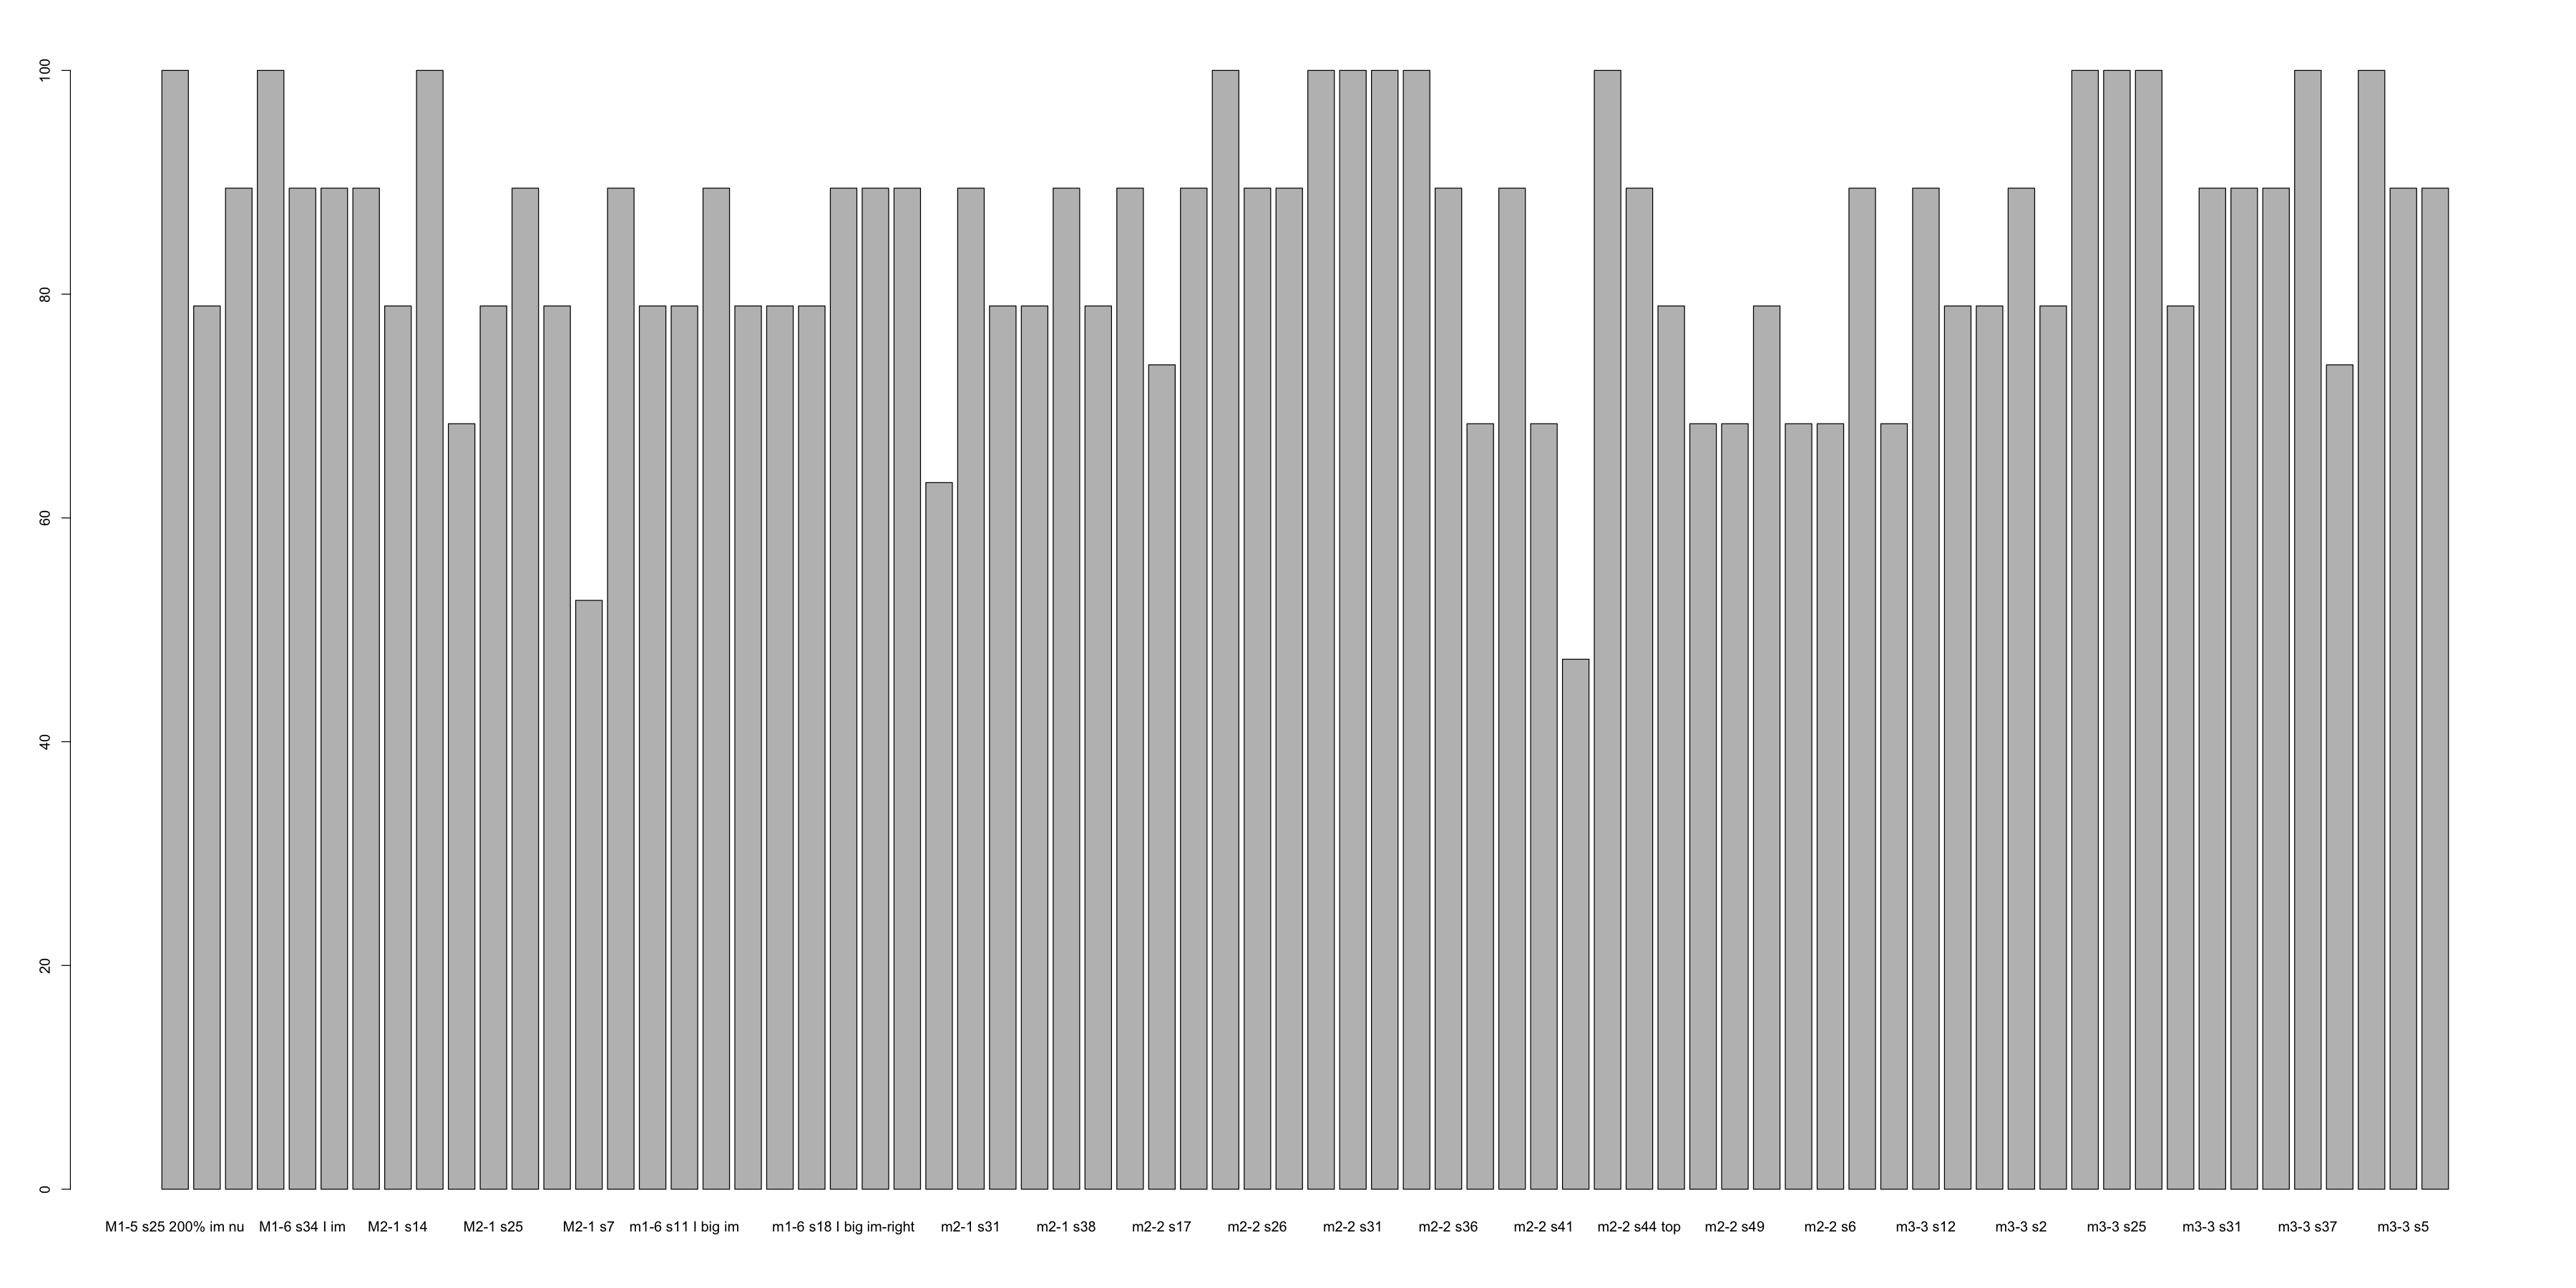

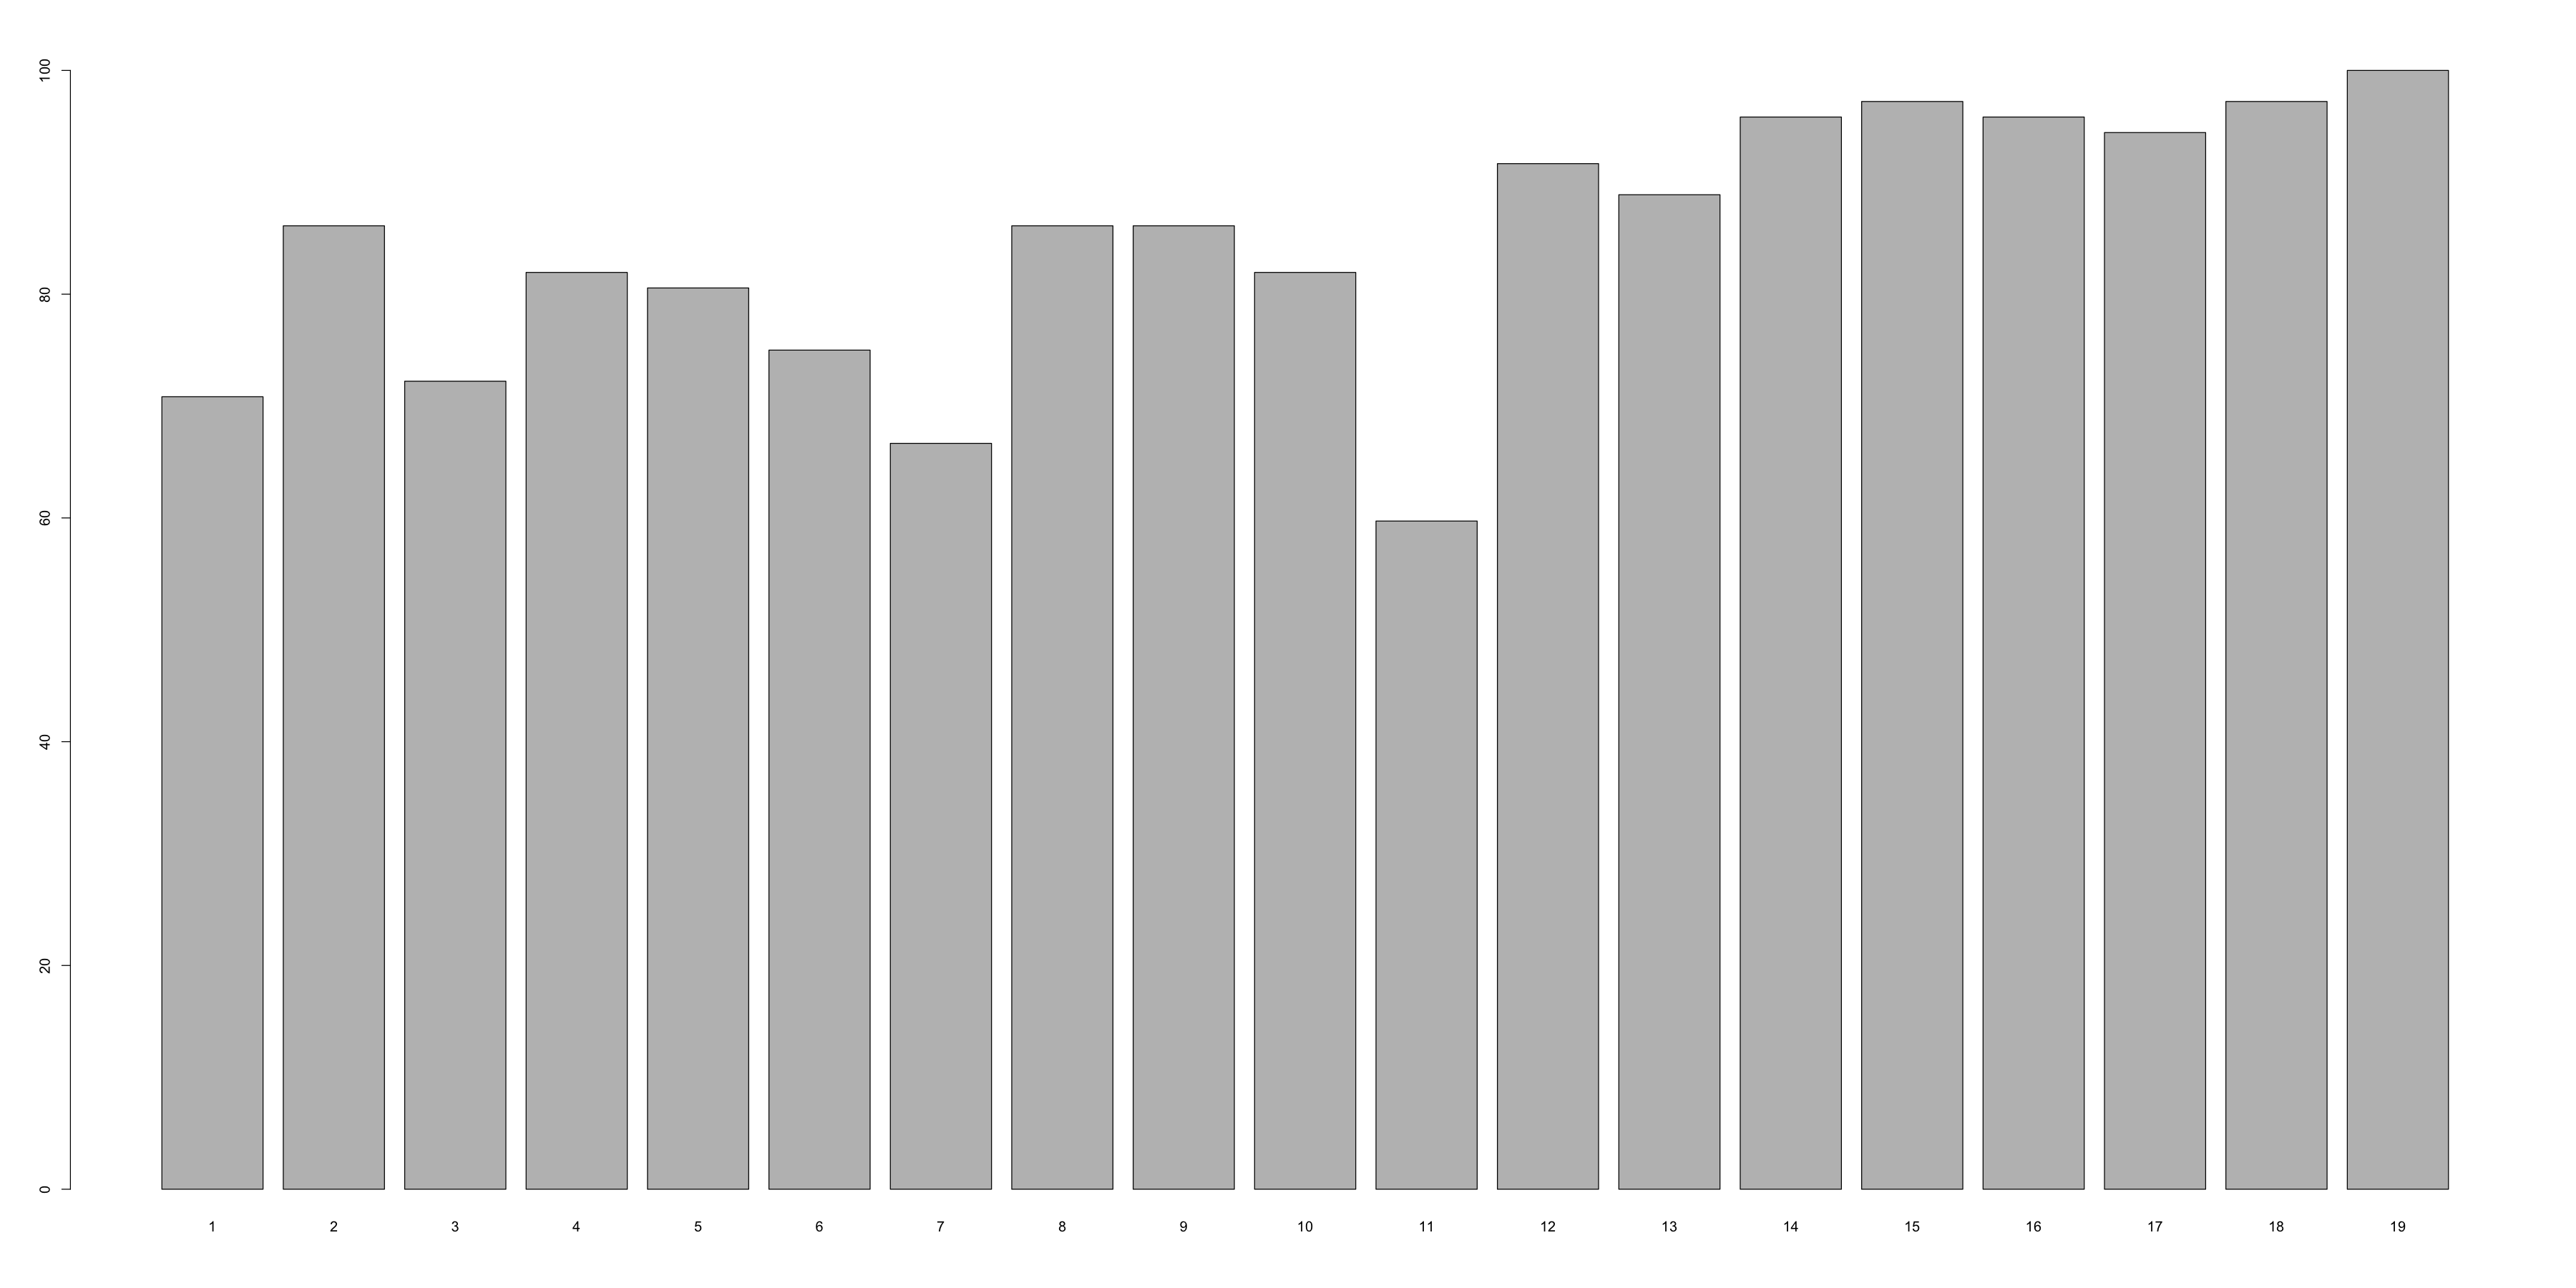

In [ ]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size

barplot(df_count_cell$Percent, names.arg=df_count_cell$Set.ID)

barplot(df_count_chr$Percent, names.arg=df_count_chr$FITC.Rank)

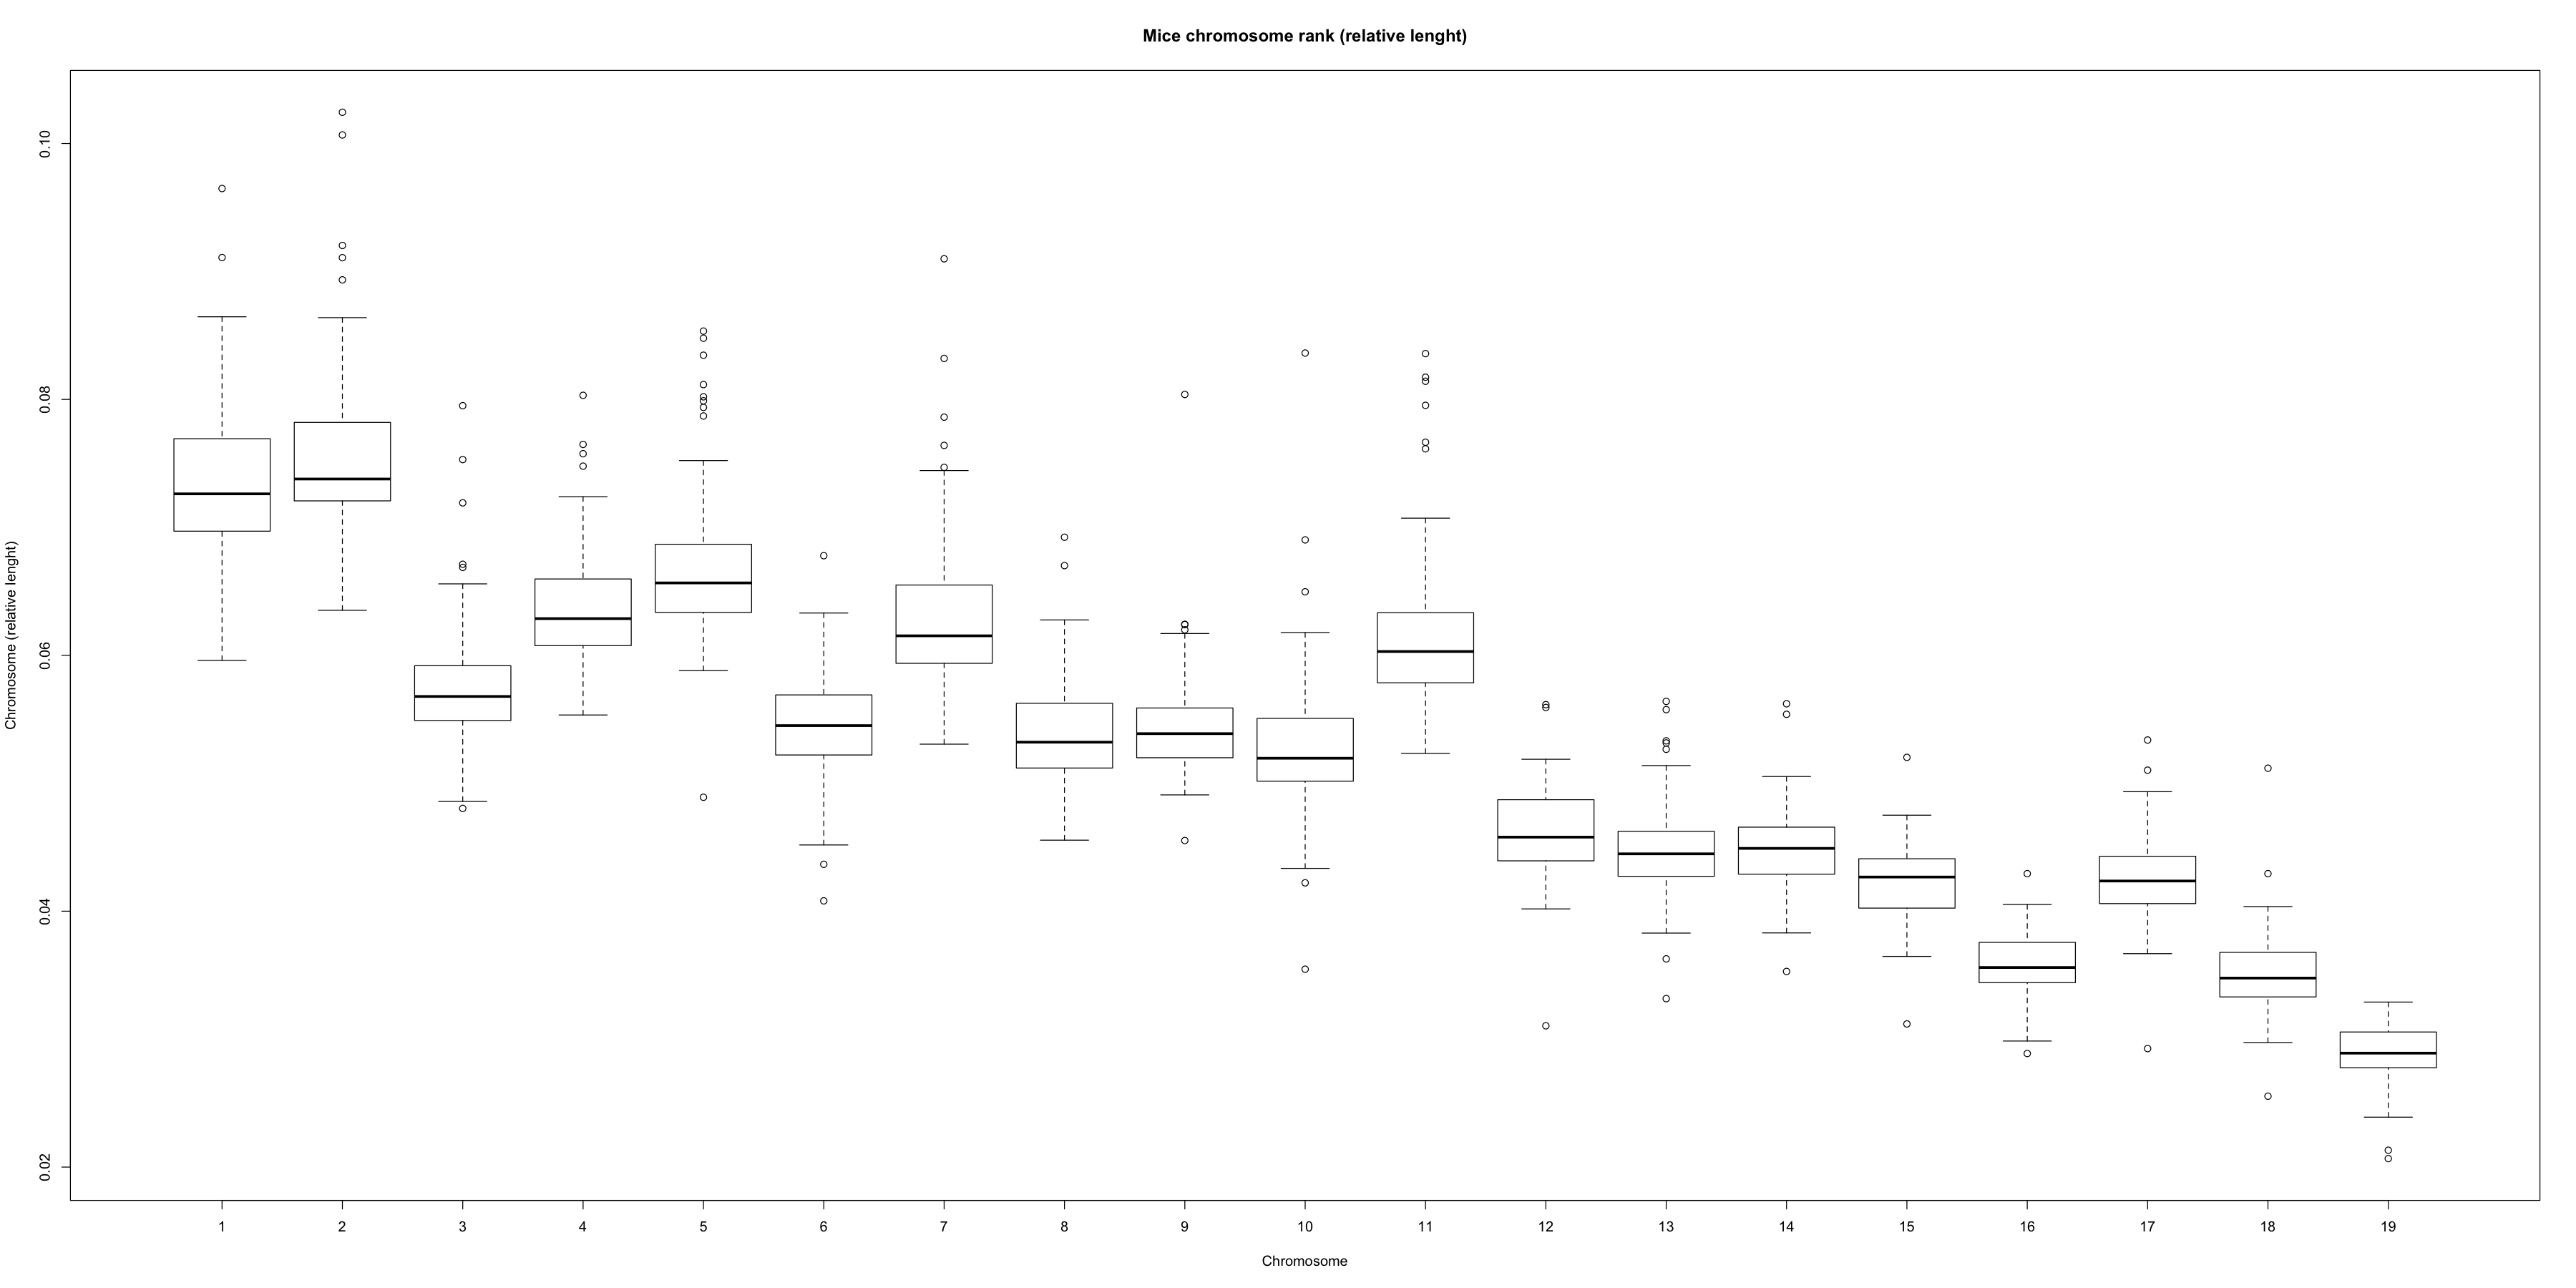

In [ ]:
myColors <- ifelse(levels(data$chr_group)=='1' , rgb(0.1,0.1,0.7,0.5) , 
              ifelse(levels(data$chr_group)=='2', rgb(0.8,0.1,0.3,0.6),
              "grey90" ) )
boxplot(Rel.len ~ FITC.Rank, data = data, main = "Mice chromosome rank (relative lenght)",
   xlab = "Chromosome", ylab = "Chromosome (relative lenght)", col=myColors)

mouse Set.ID     FITC.Rank Lgth.Rank Rel.len    Total.Len Len   No_foci F1  
1 1     m1-3 s4 nu 1         2         0.07181488 179.06    12.86 1       0.60
2 1     m1-3 s4 nu 2         1         0.07332749 179.06    13.13 1       0.49
3 1     m1-3 s4 nu 3         3         0.06686973 179.06    11.97 1       0.65
4 1     m1-3 s4 nu 4         6         0.06120195 179.06    10.96 2       0.33
5 1     m1-3 s4 nu 5         5         0.06388799 179.06    11.44 1       0.42
6 1     m1-3 s4 nu 6         7         0.05684487 179.06    10.18 1       0.38
  F2   round.F1 round.F2 chr_group rnk_group group_match
1   NA 0.60       NA     1         1          TRUE      
2   NA 0.49       NA     1         1          TRUE      
3   NA 0.65       NA     3         2         FALSE      
4 0.96 0.33     0.96     2         2          TRUE      
5   NA 0.42       NA     2         2          TRUE      
6   NA 0.38       NA     3         3          TRUE

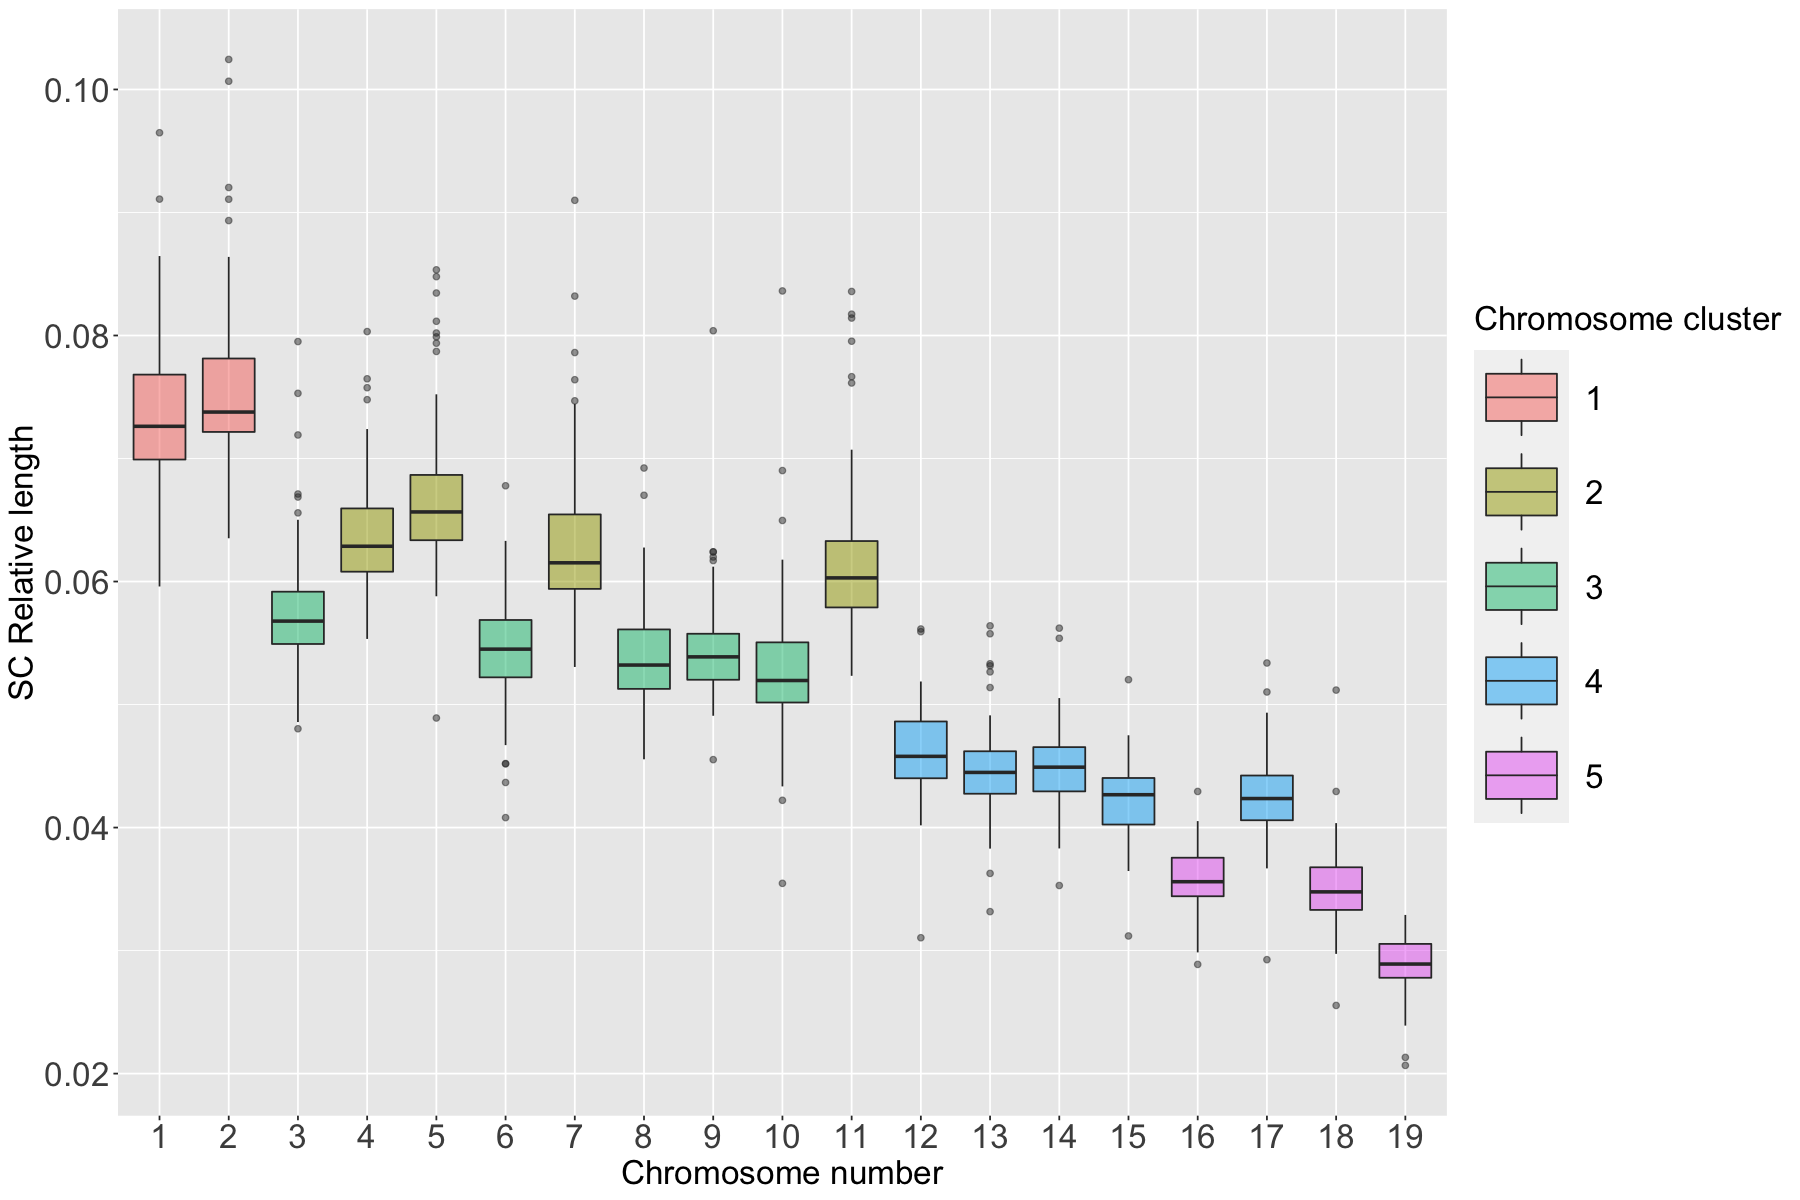

In [ ]:
head(data)

options(repr.plot.width=15, repr.plot.height=10) # Plot size

ggplot(data, aes(x=as.factor(FITC.Rank), y=Rel.len, group=FITC.Rank, fill=as.factor(chr_group))) +
    geom_boxplot(alpha=0.5) + # type boxplot
    xlab("Chromosome number") + # X axis label
    ylab("SC Relative length") + # Y axis label
    scale_fill_discrete(name = "Chromosome cluster") + # Legend title
    theme(legend.key.size = unit(2, 'cm')) + # Legend key size
    theme(legend.title = element_text(size=20)) + # Legend title size
    theme(legend.text = element_text(size=20)) + # Legend text size
    theme(axis.text.x = element_text(size=20)) + # X axis tics size
    theme(axis.text.y = element_text(size=20)) + # Y axis tics size
    theme(axis.title.x = element_text(size=20)) + # X label size
    theme(axis.title.y = element_text(size=20)) # Y label size